In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

import time
import wandb

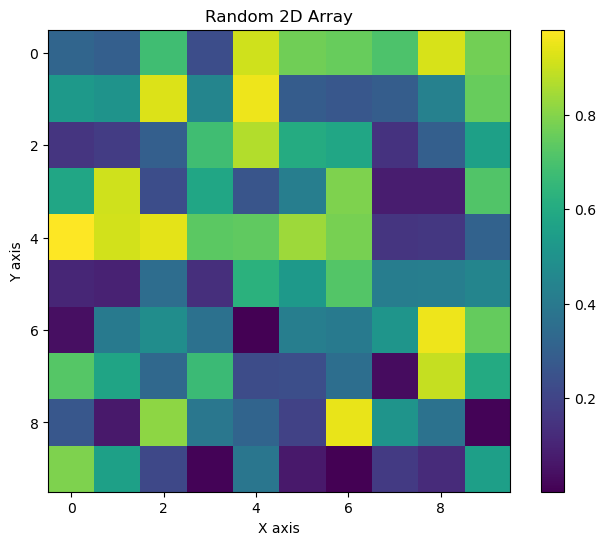

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                  FC_RESERVOIR=False):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight
        self.FC_RESERVOIR = FC_RESERVOIR

        self.out_channel = 1

        # 파라미터 
        if self.FC_RESERVOIR == True:
            self.reservoir = nn.Linear(in_features=self.in_channel*self.in_spike_size*self.in_spike_size, out_features=self.in_channel*self.in_spike_size*self.in_spike_size, bias=True)
        else:
            self.reservoir = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                            kernel_size=self.receptive_size, 
                                            stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.reservoir.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.reservoir.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # depthwise conv reservoir: pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            # fc conv reservoir: pre_spike[t] [batch_size, in_channel*in_spike_size*in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
                
            recurrent_current = self.reservoir(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                 no_reservoir = False, FC_RESERVOIR=False):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.no_reservoir = no_reservoir
        self.FC_RESERVOIR = FC_RESERVOIR

        if self.no_reservoir == False:
            self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight,
                                       FC_RESERVOIR=FC_RESERVOIR)
        
        self.classifier = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        assert self.TIME_STEP == x.size(1), f"Time step mismatch: {x.size(1)} vs {self.TIME_STEP}"

        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        if (self.FC_RESERVOIR == True):
            x = x.reshape(x.size(0), x.size(1), -1)

        if self.no_reservoir == False:
            with torch.no_grad():
                x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape

        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.classifier(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        
        ## 11번째 클래스 배제 ########################################################################
        exclude_class = 10
        if dvs_duration > 0:
            train_file_name = f'modules/dvs_gesture_class_index/train_indices_dvsgesture_duration_{dvs_duration}'
            test_file_name = f'modules/dvs_gesture_class_index/test_indices_dvsgesture_duration_{dvs_duration}'
            if (os.path.isfile(train_file_name) and os.path.isfile(test_file_name)):
                print('\ndvsgestrue 10 class indices exist. we want to exclude the 11th class\n')
                with open(train_file_name, 'rb') as f:
                    train_indices = pickle.load(f)
                with open(test_file_name, 'rb') as f:
                    test_indices = pickle.load(f)
            else:
                print('\ndvsgestrue 10 class indices doesn\'t exist. we want to exclude the 11th class\n')
                train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
                test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
                with open(train_file_name, 'wb') as f:
                    pickle.dump(train_indices, f)
                with open(test_file_name, 'wb') as f:
                    pickle.dump(test_indices, f)
        else:
            train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
            test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
        ################################################################################################

        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}

    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [8]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Val Accuracy: {val_accuracy:.2f}%")


In [9]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, 
                            no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        wandb.log({"epoch": epoch})
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)


In [10]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False)

In [11]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '5', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    FC_RESERVOIR  =  wandb.config.FC_RESERVOIR
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)



which_data_hyper = 'CIFAR10' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': f'{which_data_hyper} fc_reservoir',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"values": [0.001]},
        "batch_size": {"values": [512]},
        "time_step": {"values": [4,5,6,7,8]},
        "decay": {"values": [0.7]},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [4]},
        "IMAGE_SIZE": {"values": [32]},
        "dvs_duration": {"values": [1000000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
        "FC_RESERVOIR": {"values": [True]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: d5ebsqp9
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/d5ebsqp9


wandb: Agent Starting Run: xf1gh4k9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.238710091146486
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.56%
Test loss: 2.062, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 30.44%
Test loss: 1.977, Val Accuracy: 32.46%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.936, Val Accuracy: 33.74%
Epoch 4
Train Accuracy: 33.90%
Test loss: 1.903, Val Accuracy: 35.11%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: enpk69iw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9658853241952303
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.09%
Test loss: 1.894, Val Accuracy: 33.41%
Epoch 2
Train Accuracy: 31.38%
Test loss: 1.872, Val Accuracy: 34.21%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.871, Val Accuracy: 34.68%
Epoch 4
Train Accuracy: 32.81%
Test loss: 1.847, Val Accuracy: 35.49%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hl8yhre7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.773358707554443
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.61%
Test loss: 2.050, Val Accuracy: 28.43%
Epoch 2
Train Accuracy: 29.91%
Test loss: 1.968, Val Accuracy: 31.66%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.925, Val Accuracy: 33.09%
Epoch 4
Train Accuracy: 34.00%
Test loss: 1.896, Val Accuracy: 34.59%


wandb: Agent Starting Run: 9h0hmlxe with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.987140633650972
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.901, Val Accuracy: 33.65%
Epoch 2
Train Accuracy: 31.49%
Test loss: 1.878, Val Accuracy: 35.03%
Epoch 3
Train Accuracy: 32.92%
Test loss: 1.857, Val Accuracy: 34.82%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.852, Val Accuracy: 35.95%


wandb: Agent Starting Run: vcxydn3n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.7768088550459802
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.34%
Test loss: 2.061, Val Accuracy: 25.48%
Epoch 2
Train Accuracy: 25.76%
Test loss: 2.001, Val Accuracy: 30.24%
Epoch 3
Train Accuracy: 28.39%
Test loss: 1.968, Val Accuracy: 32.35%
Epoch 4
Train Accuracy: 29.62%
Test loss: 1.945, Val Accuracy: 33.51%


wandb: Agent Starting Run: lalc2al5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.415850887248157
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.66%
Test loss: 2.047, Val Accuracy: 28.86%
Epoch 2
Train Accuracy: 30.41%
Test loss: 1.966, Val Accuracy: 31.56%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.919, Val Accuracy: 33.34%
Epoch 4
Train Accuracy: 34.24%
Test loss: 1.890, Val Accuracy: 35.23%


wandb: Agent Starting Run: eae5vqgt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.3444678158977923
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.026, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 30.95%
Test loss: 1.949, Val Accuracy: 32.54%
Epoch 3
Train Accuracy: 33.45%
Test loss: 1.909, Val Accuracy: 34.21%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.884, Val Accuracy: 35.74%


wandb: Agent Starting Run: ptdq3jtd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.444684705518384
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.19%
Test loss: 2.004, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 27.50%
Test loss: 1.954, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 29.25%
Test loss: 1.923, Val Accuracy: 33.24%
Epoch 4
Train Accuracy: 30.05%
Test loss: 1.911, Val Accuracy: 33.84%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t1db12pk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.449647385088557
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.62%
Test loss: 2.045, Val Accuracy: 28.37%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.960, Val Accuracy: 32.18%
Epoch 3
Train Accuracy: 33.15%
Test loss: 1.918, Val Accuracy: 34.22%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.888, Val Accuracy: 34.64%


wandb: Agent Starting Run: t4gc4j5x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.987905713387438
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.59%
Test loss: 2.047, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 30.27%
Test loss: 1.960, Val Accuracy: 32.82%
Epoch 3
Train Accuracy: 32.97%
Test loss: 1.916, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.891, Val Accuracy: 35.19%


wandb: Agent Starting Run: egm3p37v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4410993273649955
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.28%
Test loss: 1.893, Val Accuracy: 33.20%
Epoch 2
Train Accuracy: 31.78%
Test loss: 1.877, Val Accuracy: 34.59%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.861, Val Accuracy: 34.98%
Epoch 4
Train Accuracy: 33.12%
Test loss: 1.852, Val Accuracy: 35.79%


wandb: Agent Starting Run: 9n95xc2m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.096420882145231
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.75%
Test loss: 2.002, Val Accuracy: 29.81%
Epoch 2
Train Accuracy: 27.48%
Test loss: 1.953, Val Accuracy: 31.18%
Epoch 3
Train Accuracy: 28.52%
Test loss: 1.934, Val Accuracy: 32.47%
Epoch 4
Train Accuracy: 29.11%
Test loss: 1.925, Val Accuracy: 32.83%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ixe58uav with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.436553706437988
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.888, Val Accuracy: 33.29%
Epoch 2
Train Accuracy: 31.72%
Test loss: 1.875, Val Accuracy: 34.38%
Epoch 3
Train Accuracy: 32.38%
Test loss: 1.858, Val Accuracy: 35.23%
Epoch 4
Train Accuracy: 32.66%
Test loss: 1.847, Val Accuracy: 35.66%


wandb: Agent Starting Run: htmmz1aq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.428326077161857
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.026, Val Accuracy: 28.88%
Epoch 2
Train Accuracy: 31.04%
Test loss: 1.955, Val Accuracy: 31.89%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.912, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.887, Val Accuracy: 34.71%


wandb: Agent Starting Run: iv1oboi9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.63533041191064
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.32%
Test loss: 1.900, Val Accuracy: 34.06%
Epoch 2
Train Accuracy: 31.99%
Test loss: 1.872, Val Accuracy: 34.44%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.857, Val Accuracy: 35.26%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.858, Val Accuracy: 35.89%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jmcnla0p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.854905907811379
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.31%
Test loss: 2.043, Val Accuracy: 28.54%
Epoch 2
Train Accuracy: 30.84%
Test loss: 1.960, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.914, Val Accuracy: 34.24%
Epoch 4
Train Accuracy: 34.53%
Test loss: 1.888, Val Accuracy: 35.21%


wandb: Agent Starting Run: tabakclc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.943507463190486
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.58%
Test loss: 2.030, Val Accuracy: 28.68%
Epoch 2
Train Accuracy: 30.76%
Test loss: 1.951, Val Accuracy: 32.05%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.911, Val Accuracy: 33.80%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.886, Val Accuracy: 34.70%


wandb: Agent Starting Run: 920c04vf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.338918186672965
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.897, Val Accuracy: 32.67%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.886, Val Accuracy: 33.51%
Epoch 3
Train Accuracy: 32.77%
Test loss: 1.865, Val Accuracy: 35.54%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.861, Val Accuracy: 35.23%


wandb: Agent Starting Run: fcyt5mwz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.516482120550997
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.31%
Test loss: 2.030, Val Accuracy: 29.29%
Epoch 2
Train Accuracy: 31.09%
Test loss: 1.951, Val Accuracy: 32.07%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.915, Val Accuracy: 32.98%
Epoch 4
Train Accuracy: 34.61%
Test loss: 1.886, Val Accuracy: 34.69%


wandb: Agent Starting Run: u2zzgwcj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.100379306321861
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.59%
Test loss: 2.128, Val Accuracy: 26.18%
Epoch 2
Train Accuracy: 27.65%
Test loss: 2.045, Val Accuracy: 30.30%
Epoch 3
Train Accuracy: 30.29%
Test loss: 2.002, Val Accuracy: 29.70%
Epoch 4
Train Accuracy: 31.44%
Test loss: 1.964, Val Accuracy: 32.71%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lr8e26at with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.0681874612502447
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.887, Val Accuracy: 34.09%
Epoch 2
Train Accuracy: 31.86%
Test loss: 1.856, Val Accuracy: 35.42%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.853, Val Accuracy: 35.60%
Epoch 4
Train Accuracy: 32.89%
Test loss: 1.848, Val Accuracy: 35.01%


wandb: Agent Starting Run: 19ardut1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.865627320313179
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.89%
Test loss: 2.004, Val Accuracy: 29.77%
Epoch 2
Train Accuracy: 27.49%
Test loss: 1.955, Val Accuracy: 32.06%
Epoch 3
Train Accuracy: 28.51%
Test loss: 1.936, Val Accuracy: 32.17%
Epoch 4
Train Accuracy: 29.31%
Test loss: 1.923, Val Accuracy: 32.96%


wandb: Agent Starting Run: t5glo5dn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.071560464634334
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.52%
Test loss: 1.905, Val Accuracy: 33.04%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.884, Val Accuracy: 34.22%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.857, Val Accuracy: 34.88%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.851, Val Accuracy: 35.32%


wandb: Agent Starting Run: bxl9hb9u with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.628205933285855
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.91%
Test loss: 1.902, Val Accuracy: 33.04%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.868, Val Accuracy: 34.10%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.856, Val Accuracy: 34.87%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.855, Val Accuracy: 35.27%


wandb: Agent Starting Run: uqy5j25u with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.365017899579948
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.66%
Test loss: 2.047, Val Accuracy: 27.69%
Epoch 2
Train Accuracy: 30.46%
Test loss: 1.964, Val Accuracy: 31.47%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.922, Val Accuracy: 33.81%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.896, Val Accuracy: 33.92%


wandb: Agent Starting Run: cditp9m9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.529560561582969
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.69%
Test loss: 2.001, Val Accuracy: 29.08%
Epoch 2
Train Accuracy: 27.11%
Test loss: 1.959, Val Accuracy: 31.08%
Epoch 3
Train Accuracy: 28.37%
Test loss: 1.942, Val Accuracy: 31.98%
Epoch 4
Train Accuracy: 29.50%
Test loss: 1.932, Val Accuracy: 32.52%


wandb: Agent Starting Run: kuny67i5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.736258579096374
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.26%
Test loss: 2.032, Val Accuracy: 28.32%
Epoch 2
Train Accuracy: 30.47%
Test loss: 1.955, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 32.92%
Test loss: 1.913, Val Accuracy: 33.75%
Epoch 4
Train Accuracy: 33.98%
Test loss: 1.889, Val Accuracy: 34.46%


wandb: Agent Starting Run: qkt0r7h9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.443028252244763
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.12%
Test loss: 2.047, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 30.42%
Test loss: 1.969, Val Accuracy: 32.44%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.920, Val Accuracy: 34.23%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.892, Val Accuracy: 34.68%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xc0r751p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.213966539834419
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.059, Val Accuracy: 28.19%
Epoch 2
Train Accuracy: 29.85%
Test loss: 1.981, Val Accuracy: 31.29%
Epoch 3
Train Accuracy: 32.20%
Test loss: 1.935, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 33.58%
Test loss: 1.906, Val Accuracy: 33.89%


wandb: Agent Starting Run: uzdcidse with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.136747843483853
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.21%
Test loss: 2.028, Val Accuracy: 29.35%
Epoch 2
Train Accuracy: 31.06%
Test loss: 1.952, Val Accuracy: 31.68%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.914, Val Accuracy: 33.93%
Epoch 4
Train Accuracy: 34.33%
Test loss: 1.888, Val Accuracy: 34.31%


wandb: Agent Starting Run: 29qpgm3w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6559356603956035
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.12%
Test loss: 1.902, Val Accuracy: 33.11%
Epoch 2
Train Accuracy: 31.80%
Test loss: 1.864, Val Accuracy: 35.35%
Epoch 3
Train Accuracy: 32.42%
Test loss: 1.863, Val Accuracy: 34.60%
Epoch 4
Train Accuracy: 32.86%
Test loss: 1.859, Val Accuracy: 35.56%


wandb: Agent Starting Run: fwquv1k1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.753641412775681
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.70%
Test loss: 2.055, Val Accuracy: 26.60%
Epoch 2
Train Accuracy: 29.59%
Test loss: 1.970, Val Accuracy: 32.45%
Epoch 3
Train Accuracy: 32.37%
Test loss: 1.926, Val Accuracy: 33.46%
Epoch 4
Train Accuracy: 33.71%
Test loss: 1.897, Val Accuracy: 34.99%


wandb: Agent Starting Run: t1d971n7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.553736944248636
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.003, Val Accuracy: 29.62%
Epoch 2
Train Accuracy: 27.78%
Test loss: 1.946, Val Accuracy: 31.99%
Epoch 3
Train Accuracy: 28.87%
Test loss: 1.923, Val Accuracy: 33.18%
Epoch 4
Train Accuracy: 29.69%
Test loss: 1.909, Val Accuracy: 33.72%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hubm1qlz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.648508986018
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.82%
Test loss: 2.050, Val Accuracy: 28.76%
Epoch 2
Train Accuracy: 30.30%
Test loss: 1.964, Val Accuracy: 32.18%
Epoch 3
Train Accuracy: 32.89%
Test loss: 1.921, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 34.11%
Test loss: 1.896, Val Accuracy: 33.72%


wandb: Agent Starting Run: kwqydlh7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.533345758266733
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.70%
Test loss: 2.043, Val Accuracy: 29.75%
Epoch 2
Train Accuracy: 30.22%
Test loss: 1.965, Val Accuracy: 31.64%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.922, Val Accuracy: 34.30%
Epoch 4
Train Accuracy: 33.81%
Test loss: 1.891, Val Accuracy: 35.26%


wandb: Agent Starting Run: 44ivbkak with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.7665051169006745
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.13%
Test loss: 2.020, Val Accuracy: 29.43%
Epoch 2
Train Accuracy: 31.11%
Test loss: 1.946, Val Accuracy: 32.93%
Epoch 3
Train Accuracy: 33.29%
Test loss: 1.907, Val Accuracy: 34.47%
Epoch 4
Train Accuracy: 34.47%
Test loss: 1.881, Val Accuracy: 35.28%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y5iwmta7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1592625160756023
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.47%
Test loss: 2.027, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 30.74%
Test loss: 1.949, Val Accuracy: 32.64%
Epoch 3
Train Accuracy: 33.23%
Test loss: 1.912, Val Accuracy: 33.62%
Epoch 4
Train Accuracy: 34.52%
Test loss: 1.887, Val Accuracy: 35.24%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qtuvpfdw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.894302717513578
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.11%
Test loss: 1.891, Val Accuracy: 33.69%
Epoch 2
Train Accuracy: 31.30%
Test loss: 1.869, Val Accuracy: 34.78%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.852, Val Accuracy: 35.62%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.845, Val Accuracy: 35.43%


wandb: Agent Starting Run: s95u754c with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.3606963808463273
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.01%
Test loss: 1.890, Val Accuracy: 34.17%
Epoch 2
Train Accuracy: 31.54%
Test loss: 1.859, Val Accuracy: 35.53%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.858, Val Accuracy: 35.46%
Epoch 4
Train Accuracy: 33.01%
Test loss: 1.845, Val Accuracy: 35.80%


wandb: Agent Starting Run: x8gn5sxe with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5265351382569549
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 15.13%
Test loss: 2.234, Val Accuracy: 19.85%
Epoch 2
Train Accuracy: 22.42%
Test loss: 2.184, Val Accuracy: 24.43%
Epoch 3
Train Accuracy: 24.56%
Test loss: 2.147, Val Accuracy: 25.96%
Epoch 4
Train Accuracy: 26.43%
Test loss: 2.117, Val Accuracy: 27.29%


wandb: Agent Starting Run: safe1p02 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.8935014079758634
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.36%
Test loss: 1.903, Val Accuracy: 32.69%
Epoch 2
Train Accuracy: 31.42%
Test loss: 1.878, Val Accuracy: 34.01%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.878, Val Accuracy: 33.88%
Epoch 4
Train Accuracy: 32.91%
Test loss: 1.853, Val Accuracy: 35.14%


wandb: Agent Starting Run: ilegalee with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4302263603695904
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.13%
Test loss: 2.006, Val Accuracy: 28.54%
Epoch 2
Train Accuracy: 27.53%
Test loss: 1.957, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 28.82%
Test loss: 1.934, Val Accuracy: 32.65%
Epoch 4
Train Accuracy: 29.63%
Test loss: 1.908, Val Accuracy: 33.59%


wandb: Agent Starting Run: s6t03p5d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0639982967007493
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.74%
Test loss: 2.125, Val Accuracy: 25.22%
Epoch 2
Train Accuracy: 27.22%
Test loss: 2.046, Val Accuracy: 28.67%
Epoch 3
Train Accuracy: 29.99%
Test loss: 1.996, Val Accuracy: 31.02%
Epoch 4
Train Accuracy: 31.48%
Test loss: 1.965, Val Accuracy: 32.82%


wandb: Agent Starting Run: y5gx9s2t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.403723083088718
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.23%
Test loss: 2.028, Val Accuracy: 29.03%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.948, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.909, Val Accuracy: 34.17%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.883, Val Accuracy: 34.89%


wandb: Agent Starting Run: r8o6oot6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.4077190523401875
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.10%
Test loss: 1.890, Val Accuracy: 34.06%
Epoch 2
Train Accuracy: 31.41%
Test loss: 1.873, Val Accuracy: 34.84%
Epoch 3
Train Accuracy: 32.45%
Test loss: 1.866, Val Accuracy: 35.03%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.841, Val Accuracy: 36.15%


wandb: Agent Starting Run: yq4eisli with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.011063399200124
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.85%
Test loss: 2.005, Val Accuracy: 29.04%
Epoch 2
Train Accuracy: 27.41%
Test loss: 1.961, Val Accuracy: 30.80%
Epoch 3
Train Accuracy: 28.38%
Test loss: 1.943, Val Accuracy: 31.75%
Epoch 4
Train Accuracy: 28.75%
Test loss: 1.928, Val Accuracy: 32.47%


wandb: Agent Starting Run: qa3u14bj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.08282968543201
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.883, Val Accuracy: 33.97%
Epoch 2
Train Accuracy: 31.68%
Test loss: 1.871, Val Accuracy: 34.32%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.857, Val Accuracy: 35.46%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.845, Val Accuracy: 35.94%


wandb: Agent Starting Run: 5bx6asgc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4040802693592167
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.69%
Test loss: 2.001, Val Accuracy: 29.40%
Epoch 2
Train Accuracy: 27.40%
Test loss: 1.952, Val Accuracy: 31.95%
Epoch 3
Train Accuracy: 28.90%
Test loss: 1.931, Val Accuracy: 32.55%
Epoch 4
Train Accuracy: 29.78%
Test loss: 1.911, Val Accuracy: 33.29%


wandb: Agent Starting Run: 1bp1omo1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.729910455059388
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.57%
Test loss: 2.049, Val Accuracy: 28.15%
Epoch 2
Train Accuracy: 30.53%
Test loss: 1.970, Val Accuracy: 32.07%
Epoch 3
Train Accuracy: 32.77%
Test loss: 1.922, Val Accuracy: 33.63%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.892, Val Accuracy: 35.00%


wandb: Agent Starting Run: pugj0s7y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8559102922415538
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.73%
Test loss: 2.030, Val Accuracy: 28.38%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.951, Val Accuracy: 32.09%
Epoch 3
Train Accuracy: 33.02%
Test loss: 1.911, Val Accuracy: 33.86%
Epoch 4
Train Accuracy: 34.25%
Test loss: 1.887, Val Accuracy: 34.68%


wandb: Agent Starting Run: ijjeiic4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.475534918434393
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.96%
Test loss: 2.004, Val Accuracy: 29.62%
Epoch 2
Train Accuracy: 27.46%
Test loss: 1.959, Val Accuracy: 31.81%
Epoch 3
Train Accuracy: 28.51%
Test loss: 1.944, Val Accuracy: 32.32%
Epoch 4
Train Accuracy: 29.33%
Test loss: 1.923, Val Accuracy: 33.11%


wandb: Agent Starting Run: 0dyhigfy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.373742754280338
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.08%
Test loss: 1.915, Val Accuracy: 33.58%
Epoch 2
Train Accuracy: 31.87%
Test loss: 1.864, Val Accuracy: 35.79%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.858, Val Accuracy: 35.95%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.854, Val Accuracy: 35.44%


wandb: Agent Starting Run: h1t4918x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.601764074014746
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.97%
Test loss: 2.043, Val Accuracy: 29.88%
Epoch 2
Train Accuracy: 30.53%
Test loss: 1.962, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.922, Val Accuracy: 33.95%
Epoch 4
Train Accuracy: 33.90%
Test loss: 1.895, Val Accuracy: 34.88%


wandb: Agent Starting Run: 9wnfsrrm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.141372697391727
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.39%
Test loss: 2.044, Val Accuracy: 28.43%
Epoch 2
Train Accuracy: 30.43%
Test loss: 1.960, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.918, Val Accuracy: 33.95%
Epoch 4
Train Accuracy: 34.43%
Test loss: 1.888, Val Accuracy: 35.20%


wandb: Agent Starting Run: t3wq9ltx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8608535956660613
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.83%
Test loss: 2.054, Val Accuracy: 26.31%
Epoch 2
Train Accuracy: 26.16%
Test loss: 1.992, Val Accuracy: 30.87%
Epoch 3
Train Accuracy: 28.60%
Test loss: 1.958, Val Accuracy: 32.55%
Epoch 4
Train Accuracy: 29.66%
Test loss: 1.934, Val Accuracy: 34.08%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rhc12e5p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5283341051092625
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.01%
Test loss: 1.902, Val Accuracy: 33.17%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.881, Val Accuracy: 34.27%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.863, Val Accuracy: 35.04%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.846, Val Accuracy: 35.95%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4luzi3b4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.6180305988969135
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.70%
Test loss: 1.896, Val Accuracy: 33.76%
Epoch 2
Train Accuracy: 31.88%
Test loss: 1.874, Val Accuracy: 34.97%
Epoch 3
Train Accuracy: 32.33%
Test loss: 1.848, Val Accuracy: 35.27%
Epoch 4
Train Accuracy: 33.15%
Test loss: 1.870, Val Accuracy: 34.78%


wandb: Agent Starting Run: anruymmi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.584540821053729
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.81%
Test loss: 1.890, Val Accuracy: 34.21%
Epoch 2
Train Accuracy: 31.79%
Test loss: 1.869, Val Accuracy: 34.64%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.853, Val Accuracy: 36.08%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.851, Val Accuracy: 35.29%


wandb: Agent Starting Run: 05a01kbf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.300372071802118
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.50%
Test loss: 2.023, Val Accuracy: 30.08%
Epoch 2
Train Accuracy: 31.05%
Test loss: 1.948, Val Accuracy: 33.29%
Epoch 3
Train Accuracy: 33.46%
Test loss: 1.907, Val Accuracy: 34.39%
Epoch 4
Train Accuracy: 34.53%
Test loss: 1.885, Val Accuracy: 34.87%


wandb: Agent Starting Run: rl8xz879 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.042620685973423
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.55%
Test loss: 2.045, Val Accuracy: 28.61%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.964, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.916, Val Accuracy: 33.52%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.888, Val Accuracy: 35.22%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p36ufsrl with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.846287519522577
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.96%
Test loss: 2.053, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 30.13%
Test loss: 1.967, Val Accuracy: 32.14%
Epoch 3
Train Accuracy: 33.03%
Test loss: 1.923, Val Accuracy: 33.23%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.894, Val Accuracy: 34.93%


wandb: Agent Starting Run: pbyz2xfb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.5913680400820684
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.07%
Test loss: 1.880, Val Accuracy: 33.94%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.866, Val Accuracy: 34.87%
Epoch 3
Train Accuracy: 32.46%
Test loss: 1.866, Val Accuracy: 35.75%
Epoch 4
Train Accuracy: 33.33%
Test loss: 1.860, Val Accuracy: 35.65%


wandb: Agent Starting Run: byozz1ni with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.381338206888571
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.48%
Test loss: 2.004, Val Accuracy: 29.09%
Epoch 2
Train Accuracy: 27.37%
Test loss: 1.960, Val Accuracy: 31.04%
Epoch 3
Train Accuracy: 28.71%
Test loss: 1.939, Val Accuracy: 31.77%
Epoch 4
Train Accuracy: 29.43%
Test loss: 1.927, Val Accuracy: 32.25%


wandb: Agent Starting Run: gme015sw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.951000554007397
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.052, Val Accuracy: 27.85%
Epoch 2
Train Accuracy: 30.23%
Test loss: 1.966, Val Accuracy: 31.86%
Epoch 3
Train Accuracy: 32.55%
Test loss: 1.925, Val Accuracy: 32.90%
Epoch 4
Train Accuracy: 33.89%
Test loss: 1.894, Val Accuracy: 34.60%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wsdn56up with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.85418846963354
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.008, Val Accuracy: 29.03%
Epoch 2
Train Accuracy: 27.38%
Test loss: 1.963, Val Accuracy: 30.75%
Epoch 3
Train Accuracy: 28.67%
Test loss: 1.943, Val Accuracy: 31.55%
Epoch 4
Train Accuracy: 29.13%
Test loss: 1.931, Val Accuracy: 31.89%


wandb: Agent Starting Run: wrxk7uef with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8844299336756061
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.54%
Test loss: 1.900, Val Accuracy: 33.28%
Epoch 2
Train Accuracy: 31.86%
Test loss: 1.871, Val Accuracy: 34.90%
Epoch 3
Train Accuracy: 32.51%
Test loss: 1.863, Val Accuracy: 35.73%
Epoch 4
Train Accuracy: 33.36%
Test loss: 1.863, Val Accuracy: 35.13%


wandb: Agent Starting Run: ersr9ivm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.342889107425087
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.13%
Test loss: 2.025, Val Accuracy: 28.34%
Epoch 2
Train Accuracy: 30.91%
Test loss: 1.949, Val Accuracy: 32.26%
Epoch 3
Train Accuracy: 33.16%
Test loss: 1.909, Val Accuracy: 34.32%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.885, Val Accuracy: 35.01%


wandb: Agent Starting Run: ggfivw12 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.520794976165633
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.02%
Test loss: 2.061, Val Accuracy: 28.32%
Epoch 2
Train Accuracy: 30.11%
Test loss: 1.979, Val Accuracy: 31.40%
Epoch 3
Train Accuracy: 32.47%
Test loss: 1.936, Val Accuracy: 33.48%
Epoch 4
Train Accuracy: 33.44%
Test loss: 1.905, Val Accuracy: 34.14%


wandb: Agent Starting Run: otwo4504 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.640261266127298
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.36%
Test loss: 2.059, Val Accuracy: 26.44%
Epoch 2
Train Accuracy: 29.84%
Test loss: 1.974, Val Accuracy: 31.50%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.926, Val Accuracy: 32.94%
Epoch 4
Train Accuracy: 33.65%
Test loss: 1.898, Val Accuracy: 34.11%


wandb: Agent Starting Run: u61dpbta with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.625911349822427
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.35%
Test loss: 2.042, Val Accuracy: 29.90%
Epoch 2
Train Accuracy: 30.92%
Test loss: 1.960, Val Accuracy: 32.83%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.917, Val Accuracy: 33.74%
Epoch 4
Train Accuracy: 34.59%
Test loss: 1.890, Val Accuracy: 35.39%


wandb: Agent Starting Run: 7h0elmu4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.0326469269965592
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.95%
Test loss: 2.029, Val Accuracy: 28.12%
Epoch 2
Train Accuracy: 30.80%
Test loss: 1.953, Val Accuracy: 32.15%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.914, Val Accuracy: 33.49%
Epoch 4
Train Accuracy: 34.04%
Test loss: 1.889, Val Accuracy: 34.55%


wandb: Agent Starting Run: 44sa22ok with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.340931627383695
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.896, Val Accuracy: 33.55%
Epoch 2
Train Accuracy: 32.01%
Test loss: 1.883, Val Accuracy: 33.78%
Epoch 3
Train Accuracy: 32.48%
Test loss: 1.849, Val Accuracy: 35.86%
Epoch 4
Train Accuracy: 32.95%
Test loss: 1.842, Val Accuracy: 35.84%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: afqbv7a3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.304607139563095
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.83%
Test loss: 2.006, Val Accuracy: 28.80%
Epoch 2
Train Accuracy: 27.32%
Test loss: 1.973, Val Accuracy: 30.77%
Epoch 3
Train Accuracy: 28.43%
Test loss: 1.942, Val Accuracy: 32.67%
Epoch 4
Train Accuracy: 29.26%
Test loss: 1.932, Val Accuracy: 32.81%


wandb: Agent Starting Run: gfjrf76a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.698009484236736
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.52%
Test loss: 1.901, Val Accuracy: 33.50%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.872, Val Accuracy: 35.24%
Epoch 3
Train Accuracy: 32.61%
Test loss: 1.860, Val Accuracy: 35.59%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.846, Val Accuracy: 36.05%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hxzuyace with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.137089418846529
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.08%
Test loss: 2.030, Val Accuracy: 28.47%
Epoch 2
Train Accuracy: 30.58%
Test loss: 1.951, Val Accuracy: 32.67%
Epoch 3
Train Accuracy: 33.10%
Test loss: 1.909, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 34.43%
Test loss: 1.886, Val Accuracy: 34.86%


wandb: Agent Starting Run: kqcmgmpy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.252694848788778
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.17%
Test loss: 2.056, Val Accuracy: 28.10%
Epoch 2
Train Accuracy: 30.42%
Test loss: 1.965, Val Accuracy: 32.42%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.925, Val Accuracy: 33.75%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.896, Val Accuracy: 33.96%


wandb: Agent Starting Run: dbr7hvul with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0658985939781895
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.13%
Test loss: 2.003, Val Accuracy: 29.37%
Epoch 2
Train Accuracy: 27.65%
Test loss: 1.954, Val Accuracy: 31.92%
Epoch 3
Train Accuracy: 28.57%
Test loss: 1.925, Val Accuracy: 32.72%
Epoch 4
Train Accuracy: 29.85%
Test loss: 1.910, Val Accuracy: 33.45%


wandb: Agent Starting Run: z02phmx5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5675811645520724
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.28%
Test loss: 2.104, Val Accuracy: 23.67%
Epoch 2
Train Accuracy: 23.70%
Test loss: 2.051, Val Accuracy: 26.79%
Epoch 3
Train Accuracy: 26.00%
Test loss: 2.021, Val Accuracy: 29.37%
Epoch 4
Train Accuracy: 27.65%
Test loss: 2.000, Val Accuracy: 30.63%


wandb: Agent Starting Run: on50wv1r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.085897207133699
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.27%
Test loss: 2.022, Val Accuracy: 28.51%
Epoch 2
Train Accuracy: 30.98%
Test loss: 1.948, Val Accuracy: 32.96%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.911, Val Accuracy: 33.57%
Epoch 4
Train Accuracy: 34.23%
Test loss: 1.882, Val Accuracy: 35.44%


wandb: Agent Starting Run: rxkybh0g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.972161838775715
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.79%
Test loss: 2.006, Val Accuracy: 29.05%
Epoch 2
Train Accuracy: 27.25%
Test loss: 1.964, Val Accuracy: 31.21%
Epoch 3
Train Accuracy: 28.51%
Test loss: 1.944, Val Accuracy: 31.80%
Epoch 4
Train Accuracy: 28.94%
Test loss: 1.928, Val Accuracy: 32.53%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ol5i2nqs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.237874842334824
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.98%
Test loss: 2.029, Val Accuracy: 28.72%
Epoch 2
Train Accuracy: 30.88%
Test loss: 1.952, Val Accuracy: 32.49%
Epoch 3
Train Accuracy: 33.09%
Test loss: 1.914, Val Accuracy: 33.14%
Epoch 4
Train Accuracy: 34.07%
Test loss: 1.889, Val Accuracy: 35.09%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9cqkczhq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.934959385581527
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.53%
Test loss: 1.894, Val Accuracy: 34.30%
Epoch 2
Train Accuracy: 32.19%
Test loss: 1.865, Val Accuracy: 34.88%
Epoch 3
Train Accuracy: 32.61%
Test loss: 1.848, Val Accuracy: 35.60%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.847, Val Accuracy: 35.94%


wandb: Agent Starting Run: vms48s82 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.0101851817558405
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.67%
Test loss: 2.009, Val Accuracy: 29.13%
Epoch 2
Train Accuracy: 27.41%
Test loss: 1.960, Val Accuracy: 31.69%
Epoch 3
Train Accuracy: 28.84%
Test loss: 1.929, Val Accuracy: 32.63%
Epoch 4
Train Accuracy: 29.40%
Test loss: 1.917, Val Accuracy: 33.51%


wandb: Agent Starting Run: ssv8kbz0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.949735483244622
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.19%
Test loss: 2.033, Val Accuracy: 28.86%
Epoch 2
Train Accuracy: 30.72%
Test loss: 1.956, Val Accuracy: 32.04%
Epoch 3
Train Accuracy: 33.10%
Test loss: 1.913, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 34.11%
Test loss: 1.891, Val Accuracy: 34.37%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z8dtcdyc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.117786665870639
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.54%
Test loss: 2.004, Val Accuracy: 29.31%
Epoch 2
Train Accuracy: 27.76%
Test loss: 1.958, Val Accuracy: 30.94%
Epoch 3
Train Accuracy: 28.59%
Test loss: 1.939, Val Accuracy: 32.04%
Epoch 4
Train Accuracy: 29.47%
Test loss: 1.919, Val Accuracy: 32.60%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zmh9pqy0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.660727551543699
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.08%
Test loss: 2.030, Val Accuracy: 29.32%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.950, Val Accuracy: 32.38%
Epoch 3
Train Accuracy: 33.38%
Test loss: 1.910, Val Accuracy: 34.63%
Epoch 4
Train Accuracy: 34.45%
Test loss: 1.886, Val Accuracy: 34.93%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 32r9euui with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.8025414575669783
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.61%
Test loss: 2.032, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.954, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 33.39%
Test loss: 1.914, Val Accuracy: 33.47%
Epoch 4
Train Accuracy: 34.34%
Test loss: 1.887, Val Accuracy: 34.70%


wandb: Agent Starting Run: h0ktppgj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6891383530704025
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.58%
Test loss: 2.029, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 30.55%
Test loss: 1.954, Val Accuracy: 32.55%
Epoch 3
Train Accuracy: 33.00%
Test loss: 1.918, Val Accuracy: 33.07%
Epoch 4
Train Accuracy: 34.08%
Test loss: 1.889, Val Accuracy: 34.50%


wandb: Agent Starting Run: djd8qt6n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.564783127563276
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.06%
Test loss: 1.897, Val Accuracy: 33.88%
Epoch 2
Train Accuracy: 32.01%
Test loss: 1.869, Val Accuracy: 35.13%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.854, Val Accuracy: 35.54%
Epoch 4
Train Accuracy: 33.20%
Test loss: 1.846, Val Accuracy: 35.98%


wandb: Agent Starting Run: 0weg9txg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.092734438363385
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.13%
Test loss: 2.051, Val Accuracy: 27.82%
Epoch 2
Train Accuracy: 30.76%
Test loss: 1.967, Val Accuracy: 32.31%
Epoch 3
Train Accuracy: 32.83%
Test loss: 1.925, Val Accuracy: 32.99%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.892, Val Accuracy: 35.36%


wandb: Agent Starting Run: d2dvksl2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1630359896529203
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.61%
Test loss: 1.890, Val Accuracy: 33.69%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.872, Val Accuracy: 34.33%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.855, Val Accuracy: 35.80%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.846, Val Accuracy: 36.17%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3w02p5mo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.049399751716329
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.35%
Test loss: 1.900, Val Accuracy: 33.74%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.885, Val Accuracy: 33.78%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.863, Val Accuracy: 35.99%
Epoch 4
Train Accuracy: 33.37%
Test loss: 1.860, Val Accuracy: 34.90%


wandb: Agent Starting Run: 4qh80trc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.213000784583279
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.56%
Test loss: 2.028, Val Accuracy: 29.12%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.955, Val Accuracy: 31.33%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.913, Val Accuracy: 33.49%
Epoch 4
Train Accuracy: 34.07%
Test loss: 1.891, Val Accuracy: 34.57%


wandb: Agent Starting Run: zi90dwtt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.814974691624275
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.25%
Test loss: 2.050, Val Accuracy: 28.36%
Epoch 2
Train Accuracy: 30.27%
Test loss: 1.969, Val Accuracy: 30.63%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.926, Val Accuracy: 33.99%
Epoch 4
Train Accuracy: 33.99%
Test loss: 1.893, Val Accuracy: 35.14%


wandb: Agent Starting Run: 0hrxuuux with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.203028242892287
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.50%
Test loss: 2.035, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 30.47%
Test loss: 1.956, Val Accuracy: 31.89%
Epoch 3
Train Accuracy: 32.97%
Test loss: 1.916, Val Accuracy: 33.14%
Epoch 4
Train Accuracy: 33.91%
Test loss: 1.890, Val Accuracy: 34.01%


wandb: Agent Starting Run: it8mjpb6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.484168547331164
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.050, Val Accuracy: 28.27%
Epoch 2
Train Accuracy: 30.19%
Test loss: 1.968, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.923, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 33.95%
Test loss: 1.893, Val Accuracy: 35.33%


wandb: Agent Starting Run: am4ly425 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.496687652090287
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.90%
Test loss: 2.047, Val Accuracy: 28.19%
Epoch 2
Train Accuracy: 30.45%
Test loss: 1.964, Val Accuracy: 31.85%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.917, Val Accuracy: 33.96%
Epoch 4
Train Accuracy: 34.24%
Test loss: 1.891, Val Accuracy: 34.76%


wandb: Agent Starting Run: zwsatb0r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.0787048343410106
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.26%
Test loss: 2.007, Val Accuracy: 29.37%
Epoch 2
Train Accuracy: 27.31%
Test loss: 1.959, Val Accuracy: 32.11%
Epoch 3
Train Accuracy: 29.20%
Test loss: 1.924, Val Accuracy: 33.01%
Epoch 4
Train Accuracy: 30.17%
Test loss: 1.907, Val Accuracy: 33.79%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ppqtaap2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0831992818602543
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.46%
Test loss: 2.006, Val Accuracy: 28.91%
Epoch 2
Train Accuracy: 27.27%
Test loss: 1.953, Val Accuracy: 31.88%
Epoch 3
Train Accuracy: 28.94%
Test loss: 1.930, Val Accuracy: 33.11%
Epoch 4
Train Accuracy: 29.75%
Test loss: 1.914, Val Accuracy: 33.52%


wandb: Agent Starting Run: 85gak27r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.933797336483841
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.29%
Test loss: 1.905, Val Accuracy: 33.16%
Epoch 2
Train Accuracy: 31.38%
Test loss: 1.866, Val Accuracy: 34.41%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.863, Val Accuracy: 35.20%
Epoch 4
Train Accuracy: 32.86%
Test loss: 1.858, Val Accuracy: 34.97%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: whnx9ymq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.807053873125209
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.97%
Test loss: 2.001, Val Accuracy: 29.32%
Epoch 2
Train Accuracy: 27.18%
Test loss: 1.957, Val Accuracy: 31.35%
Epoch 3
Train Accuracy: 28.69%
Test loss: 1.936, Val Accuracy: 32.37%
Epoch 4
Train Accuracy: 29.38%
Test loss: 1.916, Val Accuracy: 32.86%


wandb: Agent Starting Run: pv6leh69 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.000300482109859
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.77%
Test loss: 2.025, Val Accuracy: 29.21%
Epoch 2
Train Accuracy: 31.04%
Test loss: 1.949, Val Accuracy: 32.24%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.912, Val Accuracy: 33.87%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.894, Val Accuracy: 34.00%


wandb: Agent Starting Run: 74awdarg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.419004556260267
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.16%
Test loss: 2.005, Val Accuracy: 29.20%
Epoch 2
Train Accuracy: 27.38%
Test loss: 1.962, Val Accuracy: 31.54%
Epoch 3
Train Accuracy: 28.65%
Test loss: 1.940, Val Accuracy: 32.23%
Epoch 4
Train Accuracy: 29.06%
Test loss: 1.928, Val Accuracy: 32.95%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hgylzzwh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.111717625820738
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.73%
Test loss: 2.006, Val Accuracy: 29.74%
Epoch 2
Train Accuracy: 27.55%
Test loss: 1.960, Val Accuracy: 31.53%
Epoch 3
Train Accuracy: 28.98%
Test loss: 1.938, Val Accuracy: 32.45%
Epoch 4
Train Accuracy: 29.18%
Test loss: 1.921, Val Accuracy: 32.69%


wandb: Agent Starting Run: jdwwzlwe with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.2485540617517734
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.84%
Test loss: 2.025, Val Accuracy: 29.40%
Epoch 2
Train Accuracy: 30.64%
Test loss: 1.949, Val Accuracy: 32.56%
Epoch 3
Train Accuracy: 33.03%
Test loss: 1.912, Val Accuracy: 33.59%
Epoch 4
Train Accuracy: 34.11%
Test loss: 1.886, Val Accuracy: 34.80%


wandb: Agent Starting Run: 250r0enn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.452477325237812
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.89%
Test loss: 2.006, Val Accuracy: 28.88%
Epoch 2
Train Accuracy: 27.16%
Test loss: 1.965, Val Accuracy: 30.80%
Epoch 3
Train Accuracy: 28.69%
Test loss: 1.936, Val Accuracy: 32.40%
Epoch 4
Train Accuracy: 29.23%
Test loss: 1.931, Val Accuracy: 32.58%


wandb: Agent Starting Run: xxtdhzzp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.772445314938364
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.031, Val Accuracy: 28.50%
Epoch 2
Train Accuracy: 30.56%
Test loss: 1.954, Val Accuracy: 32.41%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.913, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.888, Val Accuracy: 34.67%


wandb: Agent Starting Run: n7plu57e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.251360330135039
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.21%
Test loss: 1.902, Val Accuracy: 33.31%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.865, Val Accuracy: 35.23%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.866, Val Accuracy: 35.03%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.848, Val Accuracy: 35.46%


wandb: Agent Starting Run: 3szid34h with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.9145063310435
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.64%
Test loss: 2.052, Val Accuracy: 28.99%
Epoch 2
Train Accuracy: 30.18%
Test loss: 1.972, Val Accuracy: 32.08%
Epoch 3
Train Accuracy: 32.60%
Test loss: 1.924, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.900, Val Accuracy: 33.96%


wandb: Agent Starting Run: b16q6v0y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0387835688803304
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.051, Val Accuracy: 29.08%
Epoch 2
Train Accuracy: 30.30%
Test loss: 1.969, Val Accuracy: 32.08%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.924, Val Accuracy: 33.77%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.894, Val Accuracy: 34.59%


wandb: Agent Starting Run: k2i2ewzs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.797832832836914
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.32%
Test loss: 2.056, Val Accuracy: 27.65%
Epoch 2
Train Accuracy: 29.91%
Test loss: 1.970, Val Accuracy: 31.07%
Epoch 3
Train Accuracy: 32.46%
Test loss: 1.925, Val Accuracy: 33.43%
Epoch 4
Train Accuracy: 33.79%
Test loss: 1.895, Val Accuracy: 34.07%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cdauxw4c with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.5406089998845425
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.10%
Test loss: 2.000, Val Accuracy: 29.70%
Epoch 2
Train Accuracy: 27.67%
Test loss: 1.952, Val Accuracy: 31.85%
Epoch 3
Train Accuracy: 29.22%
Test loss: 1.926, Val Accuracy: 33.24%
Epoch 4
Train Accuracy: 29.81%
Test loss: 1.911, Val Accuracy: 33.34%


wandb: Agent Starting Run: 7uttj0dq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.389782093105602
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.68%
Test loss: 2.048, Val Accuracy: 28.69%
Epoch 2
Train Accuracy: 30.49%
Test loss: 1.966, Val Accuracy: 32.14%
Epoch 3
Train Accuracy: 32.78%
Test loss: 1.920, Val Accuracy: 33.60%
Epoch 4
Train Accuracy: 34.20%
Test loss: 1.895, Val Accuracy: 34.35%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w6h3drkq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.37866754262358
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.62%
Test loss: 2.004, Val Accuracy: 28.95%
Epoch 2
Train Accuracy: 27.15%
Test loss: 1.962, Val Accuracy: 30.96%
Epoch 3
Train Accuracy: 28.77%
Test loss: 1.946, Val Accuracy: 32.09%
Epoch 4
Train Accuracy: 28.67%
Test loss: 1.932, Val Accuracy: 32.58%


wandb: Agent Starting Run: s3a8hqli with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.787217103107414
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.94%
Test loss: 2.010, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 27.08%
Test loss: 1.956, Val Accuracy: 31.63%
Epoch 3
Train Accuracy: 28.20%
Test loss: 1.939, Val Accuracy: 31.84%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.932, Val Accuracy: 32.32%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: inequp3f with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.320900181028595
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.85%
Test loss: 2.025, Val Accuracy: 29.38%
Epoch 2
Train Accuracy: 30.90%
Test loss: 1.948, Val Accuracy: 32.33%
Epoch 3
Train Accuracy: 33.12%
Test loss: 1.911, Val Accuracy: 34.31%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.889, Val Accuracy: 34.74%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5dg8o2nq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.324534518172012
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.60%
Test loss: 2.058, Val Accuracy: 26.88%
Epoch 2
Train Accuracy: 29.84%
Test loss: 1.969, Val Accuracy: 31.59%
Epoch 3
Train Accuracy: 32.67%
Test loss: 1.926, Val Accuracy: 32.61%
Epoch 4
Train Accuracy: 33.67%
Test loss: 1.894, Val Accuracy: 34.29%


wandb: Agent Starting Run: rbf9nfu8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.146655783735042
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.27%
Test loss: 1.908, Val Accuracy: 32.67%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.870, Val Accuracy: 34.99%
Epoch 3
Train Accuracy: 32.44%
Test loss: 1.865, Val Accuracy: 35.05%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.845, Val Accuracy: 36.06%


wandb: Agent Starting Run: 5rl9q3bi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.166126801003898
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.93%
Test loss: 2.045, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 30.92%
Test loss: 1.962, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 33.37%
Test loss: 1.915, Val Accuracy: 33.64%
Epoch 4
Train Accuracy: 34.58%
Test loss: 1.884, Val Accuracy: 35.52%


wandb: Agent Starting Run: o6pu6zrr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.692364175846593
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.34%
Test loss: 1.907, Val Accuracy: 32.96%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.876, Val Accuracy: 34.82%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.869, Val Accuracy: 34.87%
Epoch 4
Train Accuracy: 33.10%
Test loss: 1.848, Val Accuracy: 35.90%


wandb: Agent Starting Run: zu8tv03d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.8721756736740063
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.63%
Test loss: 2.048, Val Accuracy: 27.70%
Epoch 2
Train Accuracy: 30.69%
Test loss: 1.964, Val Accuracy: 32.15%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.921, Val Accuracy: 34.07%
Epoch 4
Train Accuracy: 34.47%
Test loss: 1.893, Val Accuracy: 34.55%


wandb: Agent Starting Run: i4kejrki with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.207079391573625
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.47%
Test loss: 1.896, Val Accuracy: 33.54%
Epoch 2
Train Accuracy: 31.82%
Test loss: 1.869, Val Accuracy: 35.28%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.854, Val Accuracy: 35.62%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.848, Val Accuracy: 35.90%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qv95td2t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.614008735640857
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.46%
Test loss: 2.031, Val Accuracy: 28.40%
Epoch 2
Train Accuracy: 30.59%
Test loss: 1.958, Val Accuracy: 31.88%
Epoch 3
Train Accuracy: 33.06%
Test loss: 1.913, Val Accuracy: 34.13%
Epoch 4
Train Accuracy: 34.21%
Test loss: 1.890, Val Accuracy: 34.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i26k5lha with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.100180964899945
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.14%
Test loss: 1.901, Val Accuracy: 33.45%
Epoch 2
Train Accuracy: 31.71%
Test loss: 1.867, Val Accuracy: 34.96%
Epoch 3
Train Accuracy: 32.67%
Test loss: 1.857, Val Accuracy: 35.56%
Epoch 4
Train Accuracy: 32.72%
Test loss: 1.843, Val Accuracy: 36.12%


wandb: Agent Starting Run: l0liqqtf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.4190541338525815
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.20%
Test loss: 2.046, Val Accuracy: 29.59%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.959, Val Accuracy: 33.16%
Epoch 3
Train Accuracy: 33.26%
Test loss: 1.919, Val Accuracy: 34.51%
Epoch 4
Train Accuracy: 34.68%
Test loss: 1.889, Val Accuracy: 35.53%


wandb: Agent Starting Run: 0z8rfbve with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.422421675992537
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.17%
Test loss: 1.895, Val Accuracy: 33.62%
Epoch 2
Train Accuracy: 31.34%
Test loss: 1.878, Val Accuracy: 34.45%
Epoch 3
Train Accuracy: 32.59%
Test loss: 1.862, Val Accuracy: 35.66%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.846, Val Accuracy: 35.63%


wandb: Agent Starting Run: pbwgoon2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.1573829401502325
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.892, Val Accuracy: 33.17%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.862, Val Accuracy: 35.35%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.866, Val Accuracy: 35.19%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.860, Val Accuracy: 35.47%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n9il3e96 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.7227176253860605
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.04%
Test loss: 1.999, Val Accuracy: 29.93%
Epoch 2
Train Accuracy: 27.34%
Test loss: 1.960, Val Accuracy: 31.62%
Epoch 3
Train Accuracy: 28.28%
Test loss: 1.943, Val Accuracy: 32.44%
Epoch 4
Train Accuracy: 29.11%
Test loss: 1.928, Val Accuracy: 32.64%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kxjnfsct with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.925103512100359
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.69%
Test loss: 2.043, Val Accuracy: 30.01%
Epoch 2
Train Accuracy: 30.48%
Test loss: 1.961, Val Accuracy: 32.65%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.917, Val Accuracy: 33.70%
Epoch 4
Train Accuracy: 34.21%
Test loss: 1.892, Val Accuracy: 34.56%


wandb: Agent Starting Run: 021edpy1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.794723352519837
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.52%
Test loss: 2.054, Val Accuracy: 27.78%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.966, Val Accuracy: 31.80%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.923, Val Accuracy: 33.51%
Epoch 4
Train Accuracy: 33.91%
Test loss: 1.893, Val Accuracy: 34.14%


wandb: Agent Starting Run: 30160pwu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.197327797680344
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.34%
Test loss: 1.898, Val Accuracy: 33.31%
Epoch 2
Train Accuracy: 31.71%
Test loss: 1.868, Val Accuracy: 34.90%
Epoch 3
Train Accuracy: 32.65%
Test loss: 1.861, Val Accuracy: 35.27%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.853, Val Accuracy: 35.93%


wandb: Agent Starting Run: twz18xjv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.9848171834581727
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.77%
Test loss: 1.907, Val Accuracy: 32.98%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.873, Val Accuracy: 34.53%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.855, Val Accuracy: 35.19%
Epoch 4
Train Accuracy: 32.84%
Test loss: 1.848, Val Accuracy: 35.65%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vn8n5stv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.1525863905255145
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.74%
Test loss: 2.035, Val Accuracy: 28.48%
Epoch 2
Train Accuracy: 30.39%
Test loss: 1.951, Val Accuracy: 32.22%
Epoch 3
Train Accuracy: 32.88%
Test loss: 1.915, Val Accuracy: 34.33%
Epoch 4
Train Accuracy: 34.16%
Test loss: 1.888, Val Accuracy: 34.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qt82umjd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.060737949600562
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.26%
Test loss: 1.895, Val Accuracy: 34.12%
Epoch 2
Train Accuracy: 31.44%
Test loss: 1.866, Val Accuracy: 35.39%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.851, Val Accuracy: 36.08%
Epoch 4
Train Accuracy: 33.06%
Test loss: 1.847, Val Accuracy: 36.41%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: avxzvq82 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.325019833883024
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.40%
Test loss: 2.021, Val Accuracy: 28.09%
Epoch 2
Train Accuracy: 27.19%
Test loss: 1.967, Val Accuracy: 31.89%
Epoch 3
Train Accuracy: 29.08%
Test loss: 1.943, Val Accuracy: 33.23%
Epoch 4
Train Accuracy: 30.05%
Test loss: 1.915, Val Accuracy: 34.24%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xdpmrklc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4914740081534192
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.01%
Test loss: 1.899, Val Accuracy: 33.14%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.874, Val Accuracy: 35.20%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.858, Val Accuracy: 35.48%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.856, Val Accuracy: 34.72%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p0jindmb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.842915278310771
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.88%
Test loss: 2.023, Val Accuracy: 29.92%
Epoch 2
Train Accuracy: 31.19%
Test loss: 1.949, Val Accuracy: 32.61%
Epoch 3
Train Accuracy: 33.47%
Test loss: 1.907, Val Accuracy: 34.37%
Epoch 4
Train Accuracy: 34.63%
Test loss: 1.886, Val Accuracy: 35.05%


wandb: Agent Starting Run: li37e63v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.390607925647803
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.39%
Test loss: 2.047, Val Accuracy: 27.83%
Epoch 2
Train Accuracy: 30.53%
Test loss: 1.961, Val Accuracy: 32.44%
Epoch 3
Train Accuracy: 33.20%
Test loss: 1.918, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 34.38%
Test loss: 1.894, Val Accuracy: 34.77%


wandb: Agent Starting Run: p1a8rl48 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.64534971088925
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.21%
Test loss: 1.900, Val Accuracy: 33.66%
Epoch 2
Train Accuracy: 31.85%
Test loss: 1.874, Val Accuracy: 34.60%
Epoch 3
Train Accuracy: 32.31%
Test loss: 1.860, Val Accuracy: 34.84%
Epoch 4
Train Accuracy: 32.92%
Test loss: 1.851, Val Accuracy: 35.10%


wandb: Agent Starting Run: fjy2gp1d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8133484277036424
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.85%
Test loss: 2.181, Val Accuracy: 22.77%
Epoch 2
Train Accuracy: 25.12%
Test loss: 2.109, Val Accuracy: 27.30%
Epoch 3
Train Accuracy: 28.10%
Test loss: 2.063, Val Accuracy: 28.54%
Epoch 4
Train Accuracy: 29.72%
Test loss: 2.028, Val Accuracy: 30.20%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wbv8vnj5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.192015926134371
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.92%
Test loss: 1.903, Val Accuracy: 32.95%
Epoch 2
Train Accuracy: 31.44%
Test loss: 1.868, Val Accuracy: 34.93%
Epoch 3
Train Accuracy: 32.27%
Test loss: 1.860, Val Accuracy: 35.50%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.848, Val Accuracy: 35.60%


wandb: Agent Starting Run: qo4qt5lc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.615835412341105
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.59%
Test loss: 1.894, Val Accuracy: 33.38%
Epoch 2
Train Accuracy: 31.49%
Test loss: 1.883, Val Accuracy: 34.90%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.865, Val Accuracy: 34.99%
Epoch 4
Train Accuracy: 32.84%
Test loss: 1.858, Val Accuracy: 35.08%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1xbohqj3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.346994398259802
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.74%
Test loss: 2.029, Val Accuracy: 28.10%
Epoch 2
Train Accuracy: 30.48%
Test loss: 1.951, Val Accuracy: 31.94%
Epoch 3
Train Accuracy: 33.00%
Test loss: 1.909, Val Accuracy: 34.20%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.887, Val Accuracy: 34.68%


wandb: Agent Starting Run: znuztdtz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6755142462625026
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.23%
Test loss: 1.994, Val Accuracy: 29.49%
Epoch 2
Train Accuracy: 27.80%
Test loss: 1.943, Val Accuracy: 31.91%
Epoch 3
Train Accuracy: 29.17%
Test loss: 1.922, Val Accuracy: 32.81%
Epoch 4
Train Accuracy: 29.77%
Test loss: 1.909, Val Accuracy: 32.83%


wandb: Agent Starting Run: ua9wn52a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.19485179825291
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.41%
Test loss: 1.895, Val Accuracy: 33.25%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.885, Val Accuracy: 33.89%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.865, Val Accuracy: 34.97%
Epoch 4
Train Accuracy: 33.32%
Test loss: 1.844, Val Accuracy: 35.76%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 05a3xxok with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.156971649623717
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.68%
Test loss: 2.026, Val Accuracy: 28.69%
Epoch 2
Train Accuracy: 31.02%
Test loss: 1.951, Val Accuracy: 32.30%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.912, Val Accuracy: 33.86%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.888, Val Accuracy: 34.35%


wandb: Agent Starting Run: 8w8snplh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.94894702929006
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.98%
Test loss: 2.043, Val Accuracy: 27.17%
Epoch 2
Train Accuracy: 26.72%
Test loss: 1.978, Val Accuracy: 31.29%
Epoch 3
Train Accuracy: 29.20%
Test loss: 1.945, Val Accuracy: 33.04%
Epoch 4
Train Accuracy: 30.00%
Test loss: 1.919, Val Accuracy: 34.37%


wandb: Agent Starting Run: noy5p9wh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.273298325578645
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.903, Val Accuracy: 33.45%
Epoch 2
Train Accuracy: 32.07%
Test loss: 1.878, Val Accuracy: 34.86%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.855, Val Accuracy: 35.42%
Epoch 4
Train Accuracy: 33.23%
Test loss: 1.854, Val Accuracy: 35.84%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aa06uhwg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.1772907945405695
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.33%
Test loss: 2.041, Val Accuracy: 28.96%
Epoch 2
Train Accuracy: 31.05%
Test loss: 1.963, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 33.31%
Test loss: 1.914, Val Accuracy: 34.28%
Epoch 4
Train Accuracy: 34.56%
Test loss: 1.885, Val Accuracy: 34.86%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cp0pdzz6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.96437969794019
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.67%
Test loss: 2.005, Val Accuracy: 29.27%
Epoch 2
Train Accuracy: 27.29%
Test loss: 1.961, Val Accuracy: 31.88%
Epoch 3
Train Accuracy: 28.60%
Test loss: 1.935, Val Accuracy: 32.57%
Epoch 4
Train Accuracy: 29.06%
Test loss: 1.928, Val Accuracy: 32.64%


wandb: Agent Starting Run: 800vaf2j with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.361307763668881
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.69%
Test loss: 2.050, Val Accuracy: 28.10%
Epoch 2
Train Accuracy: 29.88%
Test loss: 1.970, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 31.86%
Test loss: 1.928, Val Accuracy: 32.14%
Epoch 4
Train Accuracy: 33.71%
Test loss: 1.903, Val Accuracy: 33.61%


wandb: Agent Starting Run: 7d76bare with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.362092507832514
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.12%
Test loss: 2.003, Val Accuracy: 29.28%
Epoch 2
Train Accuracy: 27.55%
Test loss: 1.962, Val Accuracy: 31.32%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.938, Val Accuracy: 32.43%
Epoch 4
Train Accuracy: 29.15%
Test loss: 1.932, Val Accuracy: 32.35%


wandb: Agent Starting Run: 90ggo56w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.591685877027009
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.03%
Test loss: 2.004, Val Accuracy: 28.75%
Epoch 2
Train Accuracy: 27.88%
Test loss: 1.958, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 29.28%
Test loss: 1.924, Val Accuracy: 33.10%
Epoch 4
Train Accuracy: 29.99%
Test loss: 1.909, Val Accuracy: 33.71%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 58vtrq8s with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.604755439775343
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.63%
Test loss: 2.030, Val Accuracy: 28.89%
Epoch 2
Train Accuracy: 30.57%
Test loss: 1.954, Val Accuracy: 31.65%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.912, Val Accuracy: 33.82%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.884, Val Accuracy: 35.12%


wandb: Agent Starting Run: rfgla4eq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.947836745418067
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.77%
Test loss: 2.052, Val Accuracy: 27.66%
Epoch 2
Train Accuracy: 29.74%
Test loss: 1.972, Val Accuracy: 31.50%
Epoch 3
Train Accuracy: 32.47%
Test loss: 1.923, Val Accuracy: 33.65%
Epoch 4
Train Accuracy: 33.65%
Test loss: 1.893, Val Accuracy: 34.77%


wandb: Agent Starting Run: e65wytxf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.86088113492843
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.62%
Test loss: 2.031, Val Accuracy: 28.11%
Epoch 2
Train Accuracy: 30.35%
Test loss: 1.954, Val Accuracy: 32.14%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.912, Val Accuracy: 33.78%
Epoch 4
Train Accuracy: 33.86%
Test loss: 1.888, Val Accuracy: 34.80%


wandb: Agent Starting Run: mbvsh7v5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9954743094041628
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.27%
Test loss: 1.891, Val Accuracy: 33.91%
Epoch 2
Train Accuracy: 31.90%
Test loss: 1.869, Val Accuracy: 35.59%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.867, Val Accuracy: 34.91%
Epoch 4
Train Accuracy: 33.26%
Test loss: 1.846, Val Accuracy: 35.94%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ge7o62yk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.835581580611953
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.00%
Test loss: 1.898, Val Accuracy: 33.47%
Epoch 2
Train Accuracy: 31.63%
Test loss: 1.873, Val Accuracy: 34.82%
Epoch 3
Train Accuracy: 32.48%
Test loss: 1.862, Val Accuracy: 35.25%
Epoch 4
Train Accuracy: 33.18%
Test loss: 1.848, Val Accuracy: 36.27%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 790d3moe with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.33849624464618
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.31%
Test loss: 1.899, Val Accuracy: 33.78%
Epoch 2
Train Accuracy: 31.50%
Test loss: 1.883, Val Accuracy: 34.32%
Epoch 3
Train Accuracy: 32.36%
Test loss: 1.850, Val Accuracy: 35.54%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.848, Val Accuracy: 35.96%


wandb: Agent Starting Run: vb77smkq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.0307802251633
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.66%
Test loss: 1.893, Val Accuracy: 33.33%
Epoch 2
Train Accuracy: 31.85%
Test loss: 1.884, Val Accuracy: 34.19%
Epoch 3
Train Accuracy: 32.84%
Test loss: 1.859, Val Accuracy: 35.40%
Epoch 4
Train Accuracy: 32.71%
Test loss: 1.846, Val Accuracy: 36.22%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pd2qc3jq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5530631331412423
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.05%
Test loss: 2.093, Val Accuracy: 25.64%
Epoch 2
Train Accuracy: 28.69%
Test loss: 2.009, Val Accuracy: 29.80%
Epoch 3
Train Accuracy: 31.40%
Test loss: 1.965, Val Accuracy: 33.00%
Epoch 4
Train Accuracy: 32.57%
Test loss: 1.932, Val Accuracy: 33.03%


wandb: Agent Starting Run: m4592lhv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.8993167460623457
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.22%
Test loss: 2.081, Val Accuracy: 26.72%
Epoch 2
Train Accuracy: 29.33%
Test loss: 1.995, Val Accuracy: 30.84%
Epoch 3
Train Accuracy: 32.00%
Test loss: 1.951, Val Accuracy: 31.79%
Epoch 4
Train Accuracy: 33.26%
Test loss: 1.917, Val Accuracy: 33.78%


wandb: Agent Starting Run: 1eyts5cs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.663708906898091
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.85%
Test loss: 2.083, Val Accuracy: 27.16%
Epoch 2
Train Accuracy: 28.88%
Test loss: 2.002, Val Accuracy: 30.65%
Epoch 3
Train Accuracy: 31.26%
Test loss: 1.953, Val Accuracy: 33.24%
Epoch 4
Train Accuracy: 32.58%
Test loss: 1.929, Val Accuracy: 33.57%


wandb: Agent Starting Run: xzfll7oc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.321373454823019
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.33%
Test loss: 2.023, Val Accuracy: 29.84%
Epoch 2
Train Accuracy: 31.15%
Test loss: 1.947, Val Accuracy: 32.73%
Epoch 3
Train Accuracy: 33.37%
Test loss: 1.905, Val Accuracy: 34.24%
Epoch 4
Train Accuracy: 34.64%
Test loss: 1.881, Val Accuracy: 35.21%


wandb: Agent Starting Run: plbv1oz1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.79322877874462
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.69%
Test loss: 2.005, Val Accuracy: 29.81%
Epoch 2
Train Accuracy: 26.92%
Test loss: 1.965, Val Accuracy: 31.59%
Epoch 3
Train Accuracy: 28.41%
Test loss: 1.941, Val Accuracy: 32.26%
Epoch 4
Train Accuracy: 29.22%
Test loss: 1.935, Val Accuracy: 32.68%


wandb: Agent Starting Run: jrbchvwq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.156077870941701
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.00%
Test loss: 2.044, Val Accuracy: 29.41%
Epoch 2
Train Accuracy: 30.77%
Test loss: 1.965, Val Accuracy: 31.50%
Epoch 3
Train Accuracy: 32.93%
Test loss: 1.920, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 34.39%
Test loss: 1.888, Val Accuracy: 35.10%


wandb: Agent Starting Run: ay90mh5r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.851633863644174
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.05%
Test loss: 1.900, Val Accuracy: 33.27%
Epoch 2
Train Accuracy: 31.60%
Test loss: 1.865, Val Accuracy: 34.25%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.868, Val Accuracy: 33.82%
Epoch 4
Train Accuracy: 32.78%
Test loss: 1.857, Val Accuracy: 34.91%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zuzkvp03 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.169793178978609
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.11%
Test loss: 2.023, Val Accuracy: 28.90%
Epoch 2
Train Accuracy: 30.89%
Test loss: 1.948, Val Accuracy: 32.78%
Epoch 3
Train Accuracy: 33.32%
Test loss: 1.908, Val Accuracy: 33.73%
Epoch 4
Train Accuracy: 34.61%
Test loss: 1.886, Val Accuracy: 34.55%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4z5pwfaq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7657142415336415
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.83%
Test loss: 2.004, Val Accuracy: 29.38%
Epoch 2
Train Accuracy: 27.91%
Test loss: 1.959, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 29.47%
Test loss: 1.923, Val Accuracy: 33.40%
Epoch 4
Train Accuracy: 30.09%
Test loss: 1.909, Val Accuracy: 33.94%


wandb: Agent Starting Run: uht8tud8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.251165976178868
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.89%
Test loss: 2.024, Val Accuracy: 29.70%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.950, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.916, Val Accuracy: 33.51%
Epoch 4
Train Accuracy: 34.04%
Test loss: 1.889, Val Accuracy: 34.39%


wandb: Agent Starting Run: sk17488m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.566418215334269
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.76%
Test loss: 2.049, Val Accuracy: 28.77%
Epoch 2
Train Accuracy: 30.12%
Test loss: 1.966, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.922, Val Accuracy: 33.27%
Epoch 4
Train Accuracy: 33.59%
Test loss: 1.893, Val Accuracy: 34.64%


wandb: Agent Starting Run: xk4hm5wg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.998115277099691
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.72%
Test loss: 1.999, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 27.69%
Test loss: 1.952, Val Accuracy: 31.86%
Epoch 3
Train Accuracy: 28.71%
Test loss: 1.939, Val Accuracy: 32.35%
Epoch 4
Train Accuracy: 29.37%
Test loss: 1.916, Val Accuracy: 33.34%


wandb: Agent Starting Run: 4firyzfw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.388496341337813
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.66%
Test loss: 2.026, Val Accuracy: 28.56%
Epoch 2
Train Accuracy: 30.99%
Test loss: 1.948, Val Accuracy: 32.49%
Epoch 3
Train Accuracy: 33.27%
Test loss: 1.908, Val Accuracy: 33.30%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.884, Val Accuracy: 34.76%


wandb: Agent Starting Run: thprmio4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.1210526039446365
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.75%
Test loss: 1.901, Val Accuracy: 33.55%
Epoch 2
Train Accuracy: 31.80%
Test loss: 1.865, Val Accuracy: 35.07%
Epoch 3
Train Accuracy: 32.36%
Test loss: 1.865, Val Accuracy: 34.80%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.841, Val Accuracy: 35.89%


wandb: Agent Starting Run: 2ocj7w21 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.311771765804439
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.90%
Test loss: 2.001, Val Accuracy: 29.85%
Epoch 2
Train Accuracy: 27.27%
Test loss: 1.955, Val Accuracy: 31.17%
Epoch 3
Train Accuracy: 28.93%
Test loss: 1.932, Val Accuracy: 32.59%
Epoch 4
Train Accuracy: 29.09%
Test loss: 1.918, Val Accuracy: 33.18%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8j6zcodr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.72189642212975
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.901, Val Accuracy: 33.88%
Epoch 2
Train Accuracy: 31.55%
Test loss: 1.871, Val Accuracy: 35.15%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.862, Val Accuracy: 35.88%
Epoch 4
Train Accuracy: 32.90%
Test loss: 1.863, Val Accuracy: 35.17%


wandb: Agent Starting Run: cxwsm8o9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.6652076688512589
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.76%
Test loss: 2.081, Val Accuracy: 24.57%
Epoch 2
Train Accuracy: 25.03%
Test loss: 2.023, Val Accuracy: 29.08%
Epoch 3
Train Accuracy: 27.89%
Test loss: 1.991, Val Accuracy: 31.06%
Epoch 4
Train Accuracy: 29.17%
Test loss: 1.966, Val Accuracy: 32.74%


wandb: Agent Starting Run: vwgo612i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.258022272249783
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.64%
Test loss: 2.005, Val Accuracy: 29.86%
Epoch 2
Train Accuracy: 27.77%
Test loss: 1.947, Val Accuracy: 31.87%
Epoch 3
Train Accuracy: 29.15%
Test loss: 1.924, Val Accuracy: 32.78%
Epoch 4
Train Accuracy: 30.06%
Test loss: 1.908, Val Accuracy: 33.65%


wandb: Agent Starting Run: aseajusm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.111971543909521
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.07%
Test loss: 2.008, Val Accuracy: 28.62%
Epoch 2
Train Accuracy: 27.68%
Test loss: 1.961, Val Accuracy: 31.47%
Epoch 3
Train Accuracy: 28.93%
Test loss: 1.935, Val Accuracy: 32.24%
Epoch 4
Train Accuracy: 29.56%
Test loss: 1.915, Val Accuracy: 32.86%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bvf87t3k with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.160538737593378
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.90%
Test loss: 1.998, Val Accuracy: 29.45%
Epoch 2
Train Accuracy: 27.49%
Test loss: 1.954, Val Accuracy: 31.73%
Epoch 3
Train Accuracy: 28.57%
Test loss: 1.937, Val Accuracy: 32.35%
Epoch 4
Train Accuracy: 29.13%
Test loss: 1.921, Val Accuracy: 32.50%


wandb: Agent Starting Run: gx02os8j with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.589562303087126
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.53%
Test loss: 2.002, Val Accuracy: 29.73%
Epoch 2
Train Accuracy: 27.32%
Test loss: 1.958, Val Accuracy: 31.46%
Epoch 3
Train Accuracy: 28.39%
Test loss: 1.941, Val Accuracy: 31.41%
Epoch 4
Train Accuracy: 29.12%
Test loss: 1.928, Val Accuracy: 32.99%


wandb: Agent Starting Run: xxbarntj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.268434860870029
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.76%
Test loss: 2.004, Val Accuracy: 29.34%
Epoch 2
Train Accuracy: 27.47%
Test loss: 1.967, Val Accuracy: 31.42%
Epoch 3
Train Accuracy: 28.86%
Test loss: 1.943, Val Accuracy: 32.07%
Epoch 4
Train Accuracy: 29.53%
Test loss: 1.925, Val Accuracy: 32.97%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l2b91okf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.150081267109699
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.81%
Test loss: 2.029, Val Accuracy: 29.13%
Epoch 2
Train Accuracy: 30.80%
Test loss: 1.951, Val Accuracy: 32.44%
Epoch 3
Train Accuracy: 33.08%
Test loss: 1.914, Val Accuracy: 33.31%
Epoch 4
Train Accuracy: 34.25%
Test loss: 1.888, Val Accuracy: 34.79%


wandb: Agent Starting Run: 2uwb7iq2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.564162406580534
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.79%
Test loss: 2.004, Val Accuracy: 29.44%
Epoch 2
Train Accuracy: 27.32%
Test loss: 1.956, Val Accuracy: 31.84%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.933, Val Accuracy: 32.46%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.918, Val Accuracy: 33.06%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f5or2cr4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.777052044512333
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.48%
Test loss: 2.026, Val Accuracy: 29.97%
Epoch 2
Train Accuracy: 31.07%
Test loss: 1.949, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 33.38%
Test loss: 1.909, Val Accuracy: 34.45%
Epoch 4
Train Accuracy: 34.74%
Test loss: 1.884, Val Accuracy: 35.73%


wandb: Agent Starting Run: jdgpp1z9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.754347105443136
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.07%
Test loss: 1.896, Val Accuracy: 33.51%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.863, Val Accuracy: 34.54%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.857, Val Accuracy: 36.19%
Epoch 4
Train Accuracy: 33.15%
Test loss: 1.851, Val Accuracy: 35.68%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z3xfjr7d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.606535330649956
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.51%
Test loss: 1.884, Val Accuracy: 34.14%
Epoch 2
Train Accuracy: 31.68%
Test loss: 1.858, Val Accuracy: 35.28%
Epoch 3
Train Accuracy: 32.42%
Test loss: 1.852, Val Accuracy: 36.01%
Epoch 4
Train Accuracy: 33.04%
Test loss: 1.847, Val Accuracy: 36.13%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zope8z0y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.787967034535235
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.39%
Test loss: 1.911, Val Accuracy: 32.61%
Epoch 2
Train Accuracy: 31.39%
Test loss: 1.867, Val Accuracy: 34.45%
Epoch 3
Train Accuracy: 32.23%
Test loss: 1.855, Val Accuracy: 34.86%
Epoch 4
Train Accuracy: 32.95%
Test loss: 1.839, Val Accuracy: 35.69%


wandb: Agent Starting Run: z3g7gd1l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0461511198457107
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.06%
Test loss: 2.022, Val Accuracy: 29.27%
Epoch 2
Train Accuracy: 31.28%
Test loss: 1.950, Val Accuracy: 32.37%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.908, Val Accuracy: 34.12%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.883, Val Accuracy: 34.83%


wandb: Agent Starting Run: nhxwokwt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.98351947604913
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.70%
Test loss: 2.004, Val Accuracy: 29.12%
Epoch 2
Train Accuracy: 27.48%
Test loss: 1.963, Val Accuracy: 30.38%
Epoch 3
Train Accuracy: 28.40%
Test loss: 1.936, Val Accuracy: 32.67%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.925, Val Accuracy: 33.19%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 38vpkmbw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.045625063382838
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.60%
Test loss: 2.005, Val Accuracy: 29.28%
Epoch 2
Train Accuracy: 27.38%
Test loss: 1.954, Val Accuracy: 32.18%
Epoch 3
Train Accuracy: 28.61%
Test loss: 1.936, Val Accuracy: 31.93%
Epoch 4
Train Accuracy: 29.01%
Test loss: 1.926, Val Accuracy: 32.69%


wandb: Agent Starting Run: xtp0e10s with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.730191247015468
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.007, Val Accuracy: 28.95%
Epoch 2
Train Accuracy: 27.69%
Test loss: 1.961, Val Accuracy: 31.45%
Epoch 3
Train Accuracy: 28.73%
Test loss: 1.934, Val Accuracy: 32.80%
Epoch 4
Train Accuracy: 29.26%
Test loss: 1.918, Val Accuracy: 32.94%


wandb: Agent Starting Run: eells650 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.444408502450217
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.00%
Test loss: 2.007, Val Accuracy: 28.84%
Epoch 2
Train Accuracy: 27.36%
Test loss: 1.960, Val Accuracy: 31.21%
Epoch 3
Train Accuracy: 28.56%
Test loss: 1.941, Val Accuracy: 32.32%
Epoch 4
Train Accuracy: 29.34%
Test loss: 1.924, Val Accuracy: 32.68%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h80od0wo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.70150113896597
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.70%
Test loss: 2.007, Val Accuracy: 29.34%
Epoch 2
Train Accuracy: 27.35%
Test loss: 1.956, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.934, Val Accuracy: 32.39%
Epoch 4
Train Accuracy: 29.48%
Test loss: 1.916, Val Accuracy: 32.56%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rlqww7ui with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.6674206220167824
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.59%
Test loss: 2.009, Val Accuracy: 28.71%
Epoch 2
Train Accuracy: 27.42%
Test loss: 1.957, Val Accuracy: 31.87%
Epoch 3
Train Accuracy: 28.79%
Test loss: 1.934, Val Accuracy: 32.79%
Epoch 4
Train Accuracy: 29.66%
Test loss: 1.927, Val Accuracy: 32.94%


wandb: Agent Starting Run: pu5gneob with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.9511288577766495
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.08%
Test loss: 2.005, Val Accuracy: 29.74%
Epoch 2
Train Accuracy: 27.28%
Test loss: 1.954, Val Accuracy: 31.12%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.935, Val Accuracy: 31.91%
Epoch 4
Train Accuracy: 29.42%
Test loss: 1.922, Val Accuracy: 32.65%


wandb: Agent Starting Run: ewhhen8n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.930492755679433
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.85%
Test loss: 1.897, Val Accuracy: 33.34%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.873, Val Accuracy: 34.07%
Epoch 3
Train Accuracy: 32.17%
Test loss: 1.864, Val Accuracy: 35.89%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.856, Val Accuracy: 35.27%


wandb: Agent Starting Run: f6t910fn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.117241576486453
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.75%
Test loss: 1.997, Val Accuracy: 29.30%
Epoch 2
Train Accuracy: 27.64%
Test loss: 1.957, Val Accuracy: 31.26%
Epoch 3
Train Accuracy: 28.39%
Test loss: 1.940, Val Accuracy: 31.96%
Epoch 4
Train Accuracy: 29.30%
Test loss: 1.926, Val Accuracy: 33.06%


wandb: Agent Starting Run: mbu8fzvb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.7985878132696045
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.05%
Test loss: 2.086, Val Accuracy: 25.39%
Epoch 2
Train Accuracy: 28.75%
Test loss: 1.999, Val Accuracy: 30.53%
Epoch 3
Train Accuracy: 31.39%
Test loss: 1.952, Val Accuracy: 32.04%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.923, Val Accuracy: 33.00%


wandb: Agent Starting Run: wdhuap4a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.281683460497607
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.884, Val Accuracy: 34.17%
Epoch 2
Train Accuracy: 31.55%
Test loss: 1.867, Val Accuracy: 35.11%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.857, Val Accuracy: 35.55%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.847, Val Accuracy: 36.08%


wandb: Agent Starting Run: y7m65zus with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.325101843673282
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.51%
Test loss: 2.006, Val Accuracy: 28.85%
Epoch 2
Train Accuracy: 27.27%
Test loss: 1.954, Val Accuracy: 31.75%
Epoch 3
Train Accuracy: 28.77%
Test loss: 1.936, Val Accuracy: 32.37%
Epoch 4
Train Accuracy: 29.42%
Test loss: 1.918, Val Accuracy: 32.75%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p24o87wk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.176003386314275
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.42%
Test loss: 2.007, Val Accuracy: 28.75%
Epoch 2
Train Accuracy: 27.39%
Test loss: 1.964, Val Accuracy: 30.73%
Epoch 3
Train Accuracy: 28.61%
Test loss: 1.933, Val Accuracy: 32.17%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.927, Val Accuracy: 32.45%


wandb: Agent Starting Run: rb9atd53 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.3591677479820947
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.23%
Test loss: 1.904, Val Accuracy: 31.81%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.864, Val Accuracy: 34.45%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.850, Val Accuracy: 36.53%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.849, Val Accuracy: 36.55%


wandb: Agent Starting Run: d5c2wr6w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.8213188450892903
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.00%
Test loss: 2.003, Val Accuracy: 28.90%
Epoch 2
Train Accuracy: 27.61%
Test loss: 1.952, Val Accuracy: 31.49%
Epoch 3
Train Accuracy: 28.86%
Test loss: 1.924, Val Accuracy: 32.79%
Epoch 4
Train Accuracy: 29.94%
Test loss: 1.911, Val Accuracy: 33.11%


wandb: Agent Starting Run: 1wvtccnf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.745106648761359
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.28%
Test loss: 2.045, Val Accuracy: 28.66%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.962, Val Accuracy: 30.91%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.916, Val Accuracy: 34.53%
Epoch 4
Train Accuracy: 34.30%
Test loss: 1.885, Val Accuracy: 35.34%


wandb: Agent Starting Run: ql8lfcqu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.920012922417947
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.97%
Test loss: 2.030, Val Accuracy: 28.51%
Epoch 2
Train Accuracy: 30.80%
Test loss: 1.951, Val Accuracy: 32.03%
Epoch 3
Train Accuracy: 33.09%
Test loss: 1.914, Val Accuracy: 33.33%
Epoch 4
Train Accuracy: 34.57%
Test loss: 1.885, Val Accuracy: 34.75%


wandb: Agent Starting Run: mdhy3obn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.000800829698249
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.14%
Test loss: 2.001, Val Accuracy: 29.84%
Epoch 2
Train Accuracy: 27.81%
Test loss: 1.960, Val Accuracy: 31.37%
Epoch 3
Train Accuracy: 28.88%
Test loss: 1.935, Val Accuracy: 32.62%
Epoch 4
Train Accuracy: 29.37%
Test loss: 1.919, Val Accuracy: 33.42%


wandb: Agent Starting Run: icglgzum with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.671984459724046
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.04%
Test loss: 1.896, Val Accuracy: 33.97%
Epoch 2
Train Accuracy: 32.01%
Test loss: 1.861, Val Accuracy: 35.62%
Epoch 3
Train Accuracy: 32.55%
Test loss: 1.864, Val Accuracy: 35.90%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.870, Val Accuracy: 34.89%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: atod7lm1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.333078245667574
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.898, Val Accuracy: 33.75%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.862, Val Accuracy: 35.41%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.862, Val Accuracy: 35.51%
Epoch 4
Train Accuracy: 33.01%
Test loss: 1.855, Val Accuracy: 35.52%


wandb: Agent Starting Run: xq7mumsb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.039692793753922
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.20%
Test loss: 1.999, Val Accuracy: 29.29%
Epoch 2
Train Accuracy: 27.24%
Test loss: 1.957, Val Accuracy: 31.01%
Epoch 3
Train Accuracy: 28.50%
Test loss: 1.937, Val Accuracy: 31.69%
Epoch 4
Train Accuracy: 28.80%
Test loss: 1.928, Val Accuracy: 32.39%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 23ystd4t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.271077402964657
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.70%
Test loss: 2.026, Val Accuracy: 28.23%
Epoch 2
Train Accuracy: 30.63%
Test loss: 1.950, Val Accuracy: 31.78%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.913, Val Accuracy: 33.34%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.887, Val Accuracy: 34.80%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jj5824xd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.062207079462281
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.73%
Test loss: 2.050, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.968, Val Accuracy: 31.63%
Epoch 3
Train Accuracy: 32.75%
Test loss: 1.917, Val Accuracy: 34.04%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.891, Val Accuracy: 34.45%


wandb: Agent Starting Run: wqxelm5d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.657285550043685
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.13%
Test loss: 1.905, Val Accuracy: 33.34%
Epoch 2
Train Accuracy: 31.47%
Test loss: 1.865, Val Accuracy: 35.05%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.871, Val Accuracy: 34.71%
Epoch 4
Train Accuracy: 32.80%
Test loss: 1.837, Val Accuracy: 35.55%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8i49stlp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.168376025863466
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.34%
Test loss: 2.031, Val Accuracy: 29.69%
Epoch 2
Train Accuracy: 30.47%
Test loss: 1.954, Val Accuracy: 31.93%
Epoch 3
Train Accuracy: 32.84%
Test loss: 1.912, Val Accuracy: 33.58%
Epoch 4
Train Accuracy: 34.19%
Test loss: 1.890, Val Accuracy: 34.55%


wandb: Agent Starting Run: d3tnqgu2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.9549732428926672
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.29%
Test loss: 2.078, Val Accuracy: 27.36%
Epoch 2
Train Accuracy: 28.90%
Test loss: 1.993, Val Accuracy: 30.33%
Epoch 3
Train Accuracy: 31.78%
Test loss: 1.945, Val Accuracy: 33.21%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.916, Val Accuracy: 33.86%


wandb: Agent Starting Run: 2gbql59g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.918252069067837
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.07%
Test loss: 2.048, Val Accuracy: 28.29%
Epoch 2
Train Accuracy: 30.09%
Test loss: 1.969, Val Accuracy: 30.93%
Epoch 3
Train Accuracy: 32.48%
Test loss: 1.927, Val Accuracy: 33.08%
Epoch 4
Train Accuracy: 33.89%
Test loss: 1.899, Val Accuracy: 34.25%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: go46veja with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.045184088858091
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.49%
Test loss: 2.019, Val Accuracy: 29.09%
Epoch 2
Train Accuracy: 31.24%
Test loss: 1.946, Val Accuracy: 32.56%
Epoch 3
Train Accuracy: 33.28%
Test loss: 1.908, Val Accuracy: 34.03%
Epoch 4
Train Accuracy: 34.42%
Test loss: 1.884, Val Accuracy: 34.89%


wandb: Agent Starting Run: ari9w00e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.544451081940744
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.46%
Test loss: 2.042, Val Accuracy: 30.03%
Epoch 2
Train Accuracy: 30.77%
Test loss: 1.962, Val Accuracy: 32.02%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.920, Val Accuracy: 33.40%
Epoch 4
Train Accuracy: 34.11%
Test loss: 1.889, Val Accuracy: 35.03%


wandb: Agent Starting Run: ttqfkobt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.330153870984079
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.86%
Test loss: 2.001, Val Accuracy: 29.93%
Epoch 2
Train Accuracy: 27.36%
Test loss: 1.959, Val Accuracy: 31.29%
Epoch 3
Train Accuracy: 28.63%
Test loss: 1.934, Val Accuracy: 32.34%
Epoch 4
Train Accuracy: 29.23%
Test loss: 1.930, Val Accuracy: 32.23%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gtclqddo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.622448127977923
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.42%
Test loss: 2.006, Val Accuracy: 29.13%
Epoch 2
Train Accuracy: 27.35%
Test loss: 1.964, Val Accuracy: 31.14%
Epoch 3
Train Accuracy: 28.77%
Test loss: 1.935, Val Accuracy: 32.26%
Epoch 4
Train Accuracy: 29.09%
Test loss: 1.927, Val Accuracy: 32.71%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ss6xtpv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.808386243447928
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.35%
Test loss: 1.889, Val Accuracy: 33.39%
Epoch 2
Train Accuracy: 32.04%
Test loss: 1.864, Val Accuracy: 35.47%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.860, Val Accuracy: 34.89%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.844, Val Accuracy: 36.17%


wandb: Agent Starting Run: 4ttlot1k with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.610873093935213
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.95%
Test loss: 2.046, Val Accuracy: 29.38%
Epoch 2
Train Accuracy: 30.64%
Test loss: 1.960, Val Accuracy: 32.62%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.923, Val Accuracy: 33.06%
Epoch 4
Train Accuracy: 34.22%
Test loss: 1.895, Val Accuracy: 33.64%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oekatajb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4827590390187426
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.07%
Test loss: 2.057, Val Accuracy: 27.80%
Epoch 2
Train Accuracy: 30.51%
Test loss: 1.972, Val Accuracy: 31.52%
Epoch 3
Train Accuracy: 32.61%
Test loss: 1.928, Val Accuracy: 33.58%
Epoch 4
Train Accuracy: 33.83%
Test loss: 1.897, Val Accuracy: 34.63%


wandb: Agent Starting Run: ww8wdlq4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.192925180763886
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.15%
Test loss: 1.889, Val Accuracy: 34.07%
Epoch 2
Train Accuracy: 31.44%
Test loss: 1.866, Val Accuracy: 34.98%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.854, Val Accuracy: 35.69%
Epoch 4
Train Accuracy: 32.79%
Test loss: 1.848, Val Accuracy: 36.17%


wandb: Agent Starting Run: jwxw4v6z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.989568539997791
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.79%
Test loss: 2.026, Val Accuracy: 29.86%
Epoch 2
Train Accuracy: 31.00%
Test loss: 1.952, Val Accuracy: 32.68%
Epoch 3
Train Accuracy: 33.34%
Test loss: 1.911, Val Accuracy: 33.91%
Epoch 4
Train Accuracy: 34.42%
Test loss: 1.886, Val Accuracy: 35.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sp6qv7k9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.494292038468156
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.047, Val Accuracy: 29.54%
Epoch 2
Train Accuracy: 30.27%
Test loss: 1.966, Val Accuracy: 32.19%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.921, Val Accuracy: 34.18%
Epoch 4
Train Accuracy: 34.15%
Test loss: 1.894, Val Accuracy: 34.86%


wandb: Agent Starting Run: lkzrnt40 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.442243380478665
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.16%
Test loss: 1.895, Val Accuracy: 33.26%
Epoch 2
Train Accuracy: 31.41%
Test loss: 1.874, Val Accuracy: 34.49%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.852, Val Accuracy: 35.29%
Epoch 4
Train Accuracy: 32.42%
Test loss: 1.852, Val Accuracy: 35.63%


wandb: Agent Starting Run: tdlds8kf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.739664298064249
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.18%
Test loss: 1.895, Val Accuracy: 33.81%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.859, Val Accuracy: 35.60%
Epoch 3
Train Accuracy: 32.32%
Test loss: 1.853, Val Accuracy: 35.95%
Epoch 4
Train Accuracy: 32.83%
Test loss: 1.840, Val Accuracy: 35.92%


wandb: Agent Starting Run: hqayp464 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6946380170565187
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.38%
Test loss: 2.083, Val Accuracy: 27.06%
Epoch 2
Train Accuracy: 29.19%
Test loss: 2.003, Val Accuracy: 30.70%
Epoch 3
Train Accuracy: 31.83%
Test loss: 1.955, Val Accuracy: 32.78%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.925, Val Accuracy: 33.27%


wandb: Agent Starting Run: 07kfdcyc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.959022340670778
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.90%
Test loss: 2.049, Val Accuracy: 29.30%
Epoch 2
Train Accuracy: 30.64%
Test loss: 1.970, Val Accuracy: 32.03%
Epoch 3
Train Accuracy: 33.23%
Test loss: 1.920, Val Accuracy: 33.23%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.897, Val Accuracy: 34.60%


wandb: Agent Starting Run: cijautnc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.519848017519957
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.49%
Test loss: 2.049, Val Accuracy: 27.21%
Epoch 2
Train Accuracy: 29.79%
Test loss: 1.966, Val Accuracy: 32.12%
Epoch 3
Train Accuracy: 32.11%
Test loss: 1.924, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 33.58%
Test loss: 1.894, Val Accuracy: 34.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yrse6pbj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.505393861035305
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.48%
Test loss: 1.899, Val Accuracy: 32.23%
Epoch 2
Train Accuracy: 31.45%
Test loss: 1.876, Val Accuracy: 33.79%
Epoch 3
Train Accuracy: 32.16%
Test loss: 1.858, Val Accuracy: 34.79%
Epoch 4
Train Accuracy: 33.03%
Test loss: 1.857, Val Accuracy: 35.11%


wandb: Agent Starting Run: 4v68kglu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.131952530748036
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.06%
Test loss: 1.900, Val Accuracy: 33.62%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.873, Val Accuracy: 35.91%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.852, Val Accuracy: 35.82%
Epoch 4
Train Accuracy: 32.92%
Test loss: 1.872, Val Accuracy: 35.46%


wandb: Agent Starting Run: j3xbhmo9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.914591145904607
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.80%
Test loss: 2.039, Val Accuracy: 28.48%
Epoch 2
Train Accuracy: 30.29%
Test loss: 1.956, Val Accuracy: 31.94%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.921, Val Accuracy: 32.55%
Epoch 4
Train Accuracy: 33.71%
Test loss: 1.892, Val Accuracy: 34.45%


wandb: Agent Starting Run: lb6h0yeu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8530721962356935
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.94%
Test loss: 1.893, Val Accuracy: 34.34%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.867, Val Accuracy: 34.65%
Epoch 3
Train Accuracy: 32.67%
Test loss: 1.854, Val Accuracy: 35.86%
Epoch 4
Train Accuracy: 32.89%
Test loss: 1.855, Val Accuracy: 35.52%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eg6epynm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.300855460625006
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.68%
Test loss: 2.002, Val Accuracy: 29.36%
Epoch 2
Train Accuracy: 27.66%
Test loss: 1.950, Val Accuracy: 32.09%
Epoch 3
Train Accuracy: 29.25%
Test loss: 1.924, Val Accuracy: 33.53%
Epoch 4
Train Accuracy: 30.07%
Test loss: 1.904, Val Accuracy: 34.44%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6i6g3x9i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.601639637896739
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.74%
Test loss: 2.004, Val Accuracy: 29.10%
Epoch 2
Train Accuracy: 27.57%
Test loss: 1.949, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 29.06%
Test loss: 1.923, Val Accuracy: 32.85%
Epoch 4
Train Accuracy: 29.65%
Test loss: 1.909, Val Accuracy: 33.76%


wandb: Agent Starting Run: xk0zajbw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.9456079711228553
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.60%
Test loss: 2.029, Val Accuracy: 28.26%
Epoch 2
Train Accuracy: 30.63%
Test loss: 1.950, Val Accuracy: 32.52%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.910, Val Accuracy: 33.91%
Epoch 4
Train Accuracy: 34.16%
Test loss: 1.885, Val Accuracy: 35.11%


wandb: Agent Starting Run: b795w9rl with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.9289947295350949
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.35%
Test loss: 2.073, Val Accuracy: 26.71%
Epoch 2
Train Accuracy: 29.28%
Test loss: 1.989, Val Accuracy: 31.62%
Epoch 3
Train Accuracy: 31.78%
Test loss: 1.948, Val Accuracy: 32.64%
Epoch 4
Train Accuracy: 33.18%
Test loss: 1.916, Val Accuracy: 33.79%


wandb: Agent Starting Run: 4t7j6vk9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.479901409383487
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.37%
Test loss: 2.026, Val Accuracy: 29.90%
Epoch 2
Train Accuracy: 31.17%
Test loss: 1.948, Val Accuracy: 32.52%
Epoch 3
Train Accuracy: 33.44%
Test loss: 1.907, Val Accuracy: 34.26%
Epoch 4
Train Accuracy: 34.45%
Test loss: 1.889, Val Accuracy: 34.43%


wandb: Agent Starting Run: 7e292hhb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.837220499686045
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.48%
Test loss: 1.893, Val Accuracy: 33.45%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.861, Val Accuracy: 35.30%
Epoch 3
Train Accuracy: 32.55%
Test loss: 1.861, Val Accuracy: 34.97%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.849, Val Accuracy: 35.48%


wandb: Agent Starting Run: bgo4tlmm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.078961145058973
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.01%
Test loss: 2.050, Val Accuracy: 27.33%
Epoch 2
Train Accuracy: 30.04%
Test loss: 1.968, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.923, Val Accuracy: 34.39%
Epoch 4
Train Accuracy: 33.95%
Test loss: 1.895, Val Accuracy: 35.10%


wandb: Agent Starting Run: hmyssobz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.268537390621798
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.96%
Test loss: 2.029, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 30.92%
Test loss: 1.951, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 32.95%
Test loss: 1.913, Val Accuracy: 33.78%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.885, Val Accuracy: 34.98%


wandb: Agent Starting Run: z8xay0bf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.188901735984499
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.36%
Test loss: 1.884, Val Accuracy: 34.23%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.869, Val Accuracy: 35.35%
Epoch 3
Train Accuracy: 32.67%
Test loss: 1.850, Val Accuracy: 35.87%
Epoch 4
Train Accuracy: 33.10%
Test loss: 1.860, Val Accuracy: 35.42%


wandb: Agent Starting Run: 0z0uyix0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.212514368496006
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.59%
Test loss: 1.907, Val Accuracy: 32.96%
Epoch 2
Train Accuracy: 31.63%
Test loss: 1.876, Val Accuracy: 34.93%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.864, Val Accuracy: 35.13%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.870, Val Accuracy: 35.12%


wandb: Agent Starting Run: clkhzejq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.7973301443436656
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.77%
Test loss: 1.893, Val Accuracy: 33.98%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.860, Val Accuracy: 35.26%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.857, Val Accuracy: 35.12%
Epoch 4
Train Accuracy: 32.97%
Test loss: 1.860, Val Accuracy: 36.10%


wandb: Agent Starting Run: jdcbqi8o with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.227814185799901
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.85%
Test loss: 2.026, Val Accuracy: 28.58%
Epoch 2
Train Accuracy: 31.06%
Test loss: 1.949, Val Accuracy: 32.69%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.909, Val Accuracy: 34.05%
Epoch 4
Train Accuracy: 34.50%
Test loss: 1.884, Val Accuracy: 35.24%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5wz4nkcf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.130435683340982
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.11%
Test loss: 2.004, Val Accuracy: 29.01%
Epoch 2
Train Accuracy: 27.23%
Test loss: 1.954, Val Accuracy: 31.10%
Epoch 3
Train Accuracy: 28.46%
Test loss: 1.941, Val Accuracy: 32.34%
Epoch 4
Train Accuracy: 29.29%
Test loss: 1.928, Val Accuracy: 32.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2pb92gb0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5856407012282911
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.20%
Test loss: 2.028, Val Accuracy: 28.50%
Epoch 2
Train Accuracy: 30.95%
Test loss: 1.950, Val Accuracy: 32.86%
Epoch 3
Train Accuracy: 33.17%
Test loss: 1.916, Val Accuracy: 33.82%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.889, Val Accuracy: 34.94%


wandb: Agent Starting Run: afilcb3r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.989382715956771
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.58%
Test loss: 2.026, Val Accuracy: 28.72%
Epoch 2
Train Accuracy: 30.58%
Test loss: 1.951, Val Accuracy: 32.06%
Epoch 3
Train Accuracy: 33.17%
Test loss: 1.911, Val Accuracy: 34.00%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.886, Val Accuracy: 35.12%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q95wi7pi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.213010531337045
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.28%
Test loss: 2.049, Val Accuracy: 28.96%
Epoch 2
Train Accuracy: 30.59%
Test loss: 1.966, Val Accuracy: 32.03%
Epoch 3
Train Accuracy: 33.04%
Test loss: 1.923, Val Accuracy: 33.10%
Epoch 4
Train Accuracy: 34.16%
Test loss: 1.892, Val Accuracy: 35.03%


wandb: Agent Starting Run: zaaqu2f6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1162128936689952
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.13%
Test loss: 2.030, Val Accuracy: 27.66%
Epoch 2
Train Accuracy: 30.79%
Test loss: 1.951, Val Accuracy: 32.71%
Epoch 3
Train Accuracy: 33.05%
Test loss: 1.910, Val Accuracy: 34.50%
Epoch 4
Train Accuracy: 34.39%
Test loss: 1.885, Val Accuracy: 35.23%


wandb: Agent Starting Run: h34qwz40 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.208341435570081
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.97%
Test loss: 1.889, Val Accuracy: 34.00%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.862, Val Accuracy: 34.55%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.847, Val Accuracy: 35.89%
Epoch 4
Train Accuracy: 32.95%
Test loss: 1.852, Val Accuracy: 35.38%


wandb: Agent Starting Run: sseej4kv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.372374764228183
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.95%
Test loss: 1.999, Val Accuracy: 29.94%
Epoch 2
Train Accuracy: 27.54%
Test loss: 1.952, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 28.70%
Test loss: 1.925, Val Accuracy: 33.08%
Epoch 4
Train Accuracy: 29.49%
Test loss: 1.919, Val Accuracy: 32.98%


wandb: Agent Starting Run: 7x7zin7y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.375453583997613
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.29%
Test loss: 1.904, Val Accuracy: 33.26%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.873, Val Accuracy: 35.57%
Epoch 3
Train Accuracy: 32.56%
Test loss: 1.860, Val Accuracy: 35.37%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.850, Val Accuracy: 35.36%


wandb: Agent Starting Run: xlu2xhul with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.2963791704331538
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.82%
Test loss: 2.004, Val Accuracy: 28.83%
Epoch 2
Train Accuracy: 27.83%
Test loss: 1.953, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 29.04%
Test loss: 1.926, Val Accuracy: 32.68%
Epoch 4
Train Accuracy: 29.79%
Test loss: 1.918, Val Accuracy: 33.15%


wandb: Agent Starting Run: facvwa7e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.36738294878676
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.32%
Test loss: 1.906, Val Accuracy: 33.30%
Epoch 2
Train Accuracy: 31.76%
Test loss: 1.857, Val Accuracy: 35.79%
Epoch 3
Train Accuracy: 32.25%
Test loss: 1.878, Val Accuracy: 34.35%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.850, Val Accuracy: 35.74%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3hlck8q6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.33724788044004
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.896, Val Accuracy: 33.54%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.857, Val Accuracy: 34.67%
Epoch 3
Train Accuracy: 32.36%
Test loss: 1.859, Val Accuracy: 34.51%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.850, Val Accuracy: 35.65%


wandb: Agent Starting Run: wknyl3c4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6043053578988464
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.59%
Test loss: 2.090, Val Accuracy: 28.47%
Epoch 2
Train Accuracy: 29.18%
Test loss: 2.008, Val Accuracy: 31.25%
Epoch 3
Train Accuracy: 31.71%
Test loss: 1.961, Val Accuracy: 32.45%
Epoch 4
Train Accuracy: 32.98%
Test loss: 1.928, Val Accuracy: 33.43%


wandb: Agent Starting Run: pw0scr4v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.455214211645033
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.39%
Test loss: 2.047, Val Accuracy: 26.77%
Epoch 2
Train Accuracy: 30.65%
Test loss: 1.961, Val Accuracy: 32.42%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.917, Val Accuracy: 34.11%
Epoch 4
Train Accuracy: 34.07%
Test loss: 1.889, Val Accuracy: 34.74%


wandb: Agent Starting Run: sz9e9q03 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.445232438413067
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.17%
Test loss: 2.046, Val Accuracy: 28.50%
Epoch 2
Train Accuracy: 30.37%
Test loss: 1.960, Val Accuracy: 32.68%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.919, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 33.87%
Test loss: 1.892, Val Accuracy: 34.72%


wandb: Agent Starting Run: 0vm0mb8e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.610357515059853
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.85%
Test loss: 2.004, Val Accuracy: 29.49%
Epoch 2
Train Accuracy: 27.45%
Test loss: 1.960, Val Accuracy: 32.04%
Epoch 3
Train Accuracy: 28.27%
Test loss: 1.941, Val Accuracy: 32.51%
Epoch 4
Train Accuracy: 29.15%
Test loss: 1.924, Val Accuracy: 33.28%


wandb: Agent Starting Run: ql1kp69s with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.702523964514452
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.24%
Test loss: 2.033, Val Accuracy: 28.58%
Epoch 2
Train Accuracy: 30.97%
Test loss: 1.954, Val Accuracy: 31.61%
Epoch 3
Train Accuracy: 33.16%
Test loss: 1.912, Val Accuracy: 33.88%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.887, Val Accuracy: 34.71%


wandb: Agent Starting Run: lvlti0kv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.9855632109561503
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.94%
Test loss: 1.908, Val Accuracy: 33.55%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.869, Val Accuracy: 35.19%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.852, Val Accuracy: 35.44%
Epoch 4
Train Accuracy: 33.16%
Test loss: 1.840, Val Accuracy: 35.93%


wandb: Agent Starting Run: tx5syadq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4337960441595476
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.68%
Test loss: 2.044, Val Accuracy: 29.89%
Epoch 2
Train Accuracy: 30.84%
Test loss: 1.971, Val Accuracy: 31.19%
Epoch 3
Train Accuracy: 32.87%
Test loss: 1.920, Val Accuracy: 33.41%
Epoch 4
Train Accuracy: 34.58%
Test loss: 1.894, Val Accuracy: 34.00%


wandb: Agent Starting Run: qf6j7m35 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.881924140652821
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.92%
Test loss: 2.050, Val Accuracy: 28.25%
Epoch 2
Train Accuracy: 30.53%
Test loss: 1.964, Val Accuracy: 32.83%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.919, Val Accuracy: 34.17%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.891, Val Accuracy: 34.12%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0g3xx08m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.866818100302914
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.18%
Test loss: 2.048, Val Accuracy: 28.85%
Epoch 2
Train Accuracy: 30.34%
Test loss: 1.964, Val Accuracy: 31.68%
Epoch 3
Train Accuracy: 32.17%
Test loss: 1.921, Val Accuracy: 33.42%
Epoch 4
Train Accuracy: 33.94%
Test loss: 1.900, Val Accuracy: 34.17%


wandb: Agent Starting Run: y3tnvvqj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.904293287114195
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.16%
Test loss: 1.914, Val Accuracy: 33.03%
Epoch 2
Train Accuracy: 31.46%
Test loss: 1.880, Val Accuracy: 33.92%
Epoch 3
Train Accuracy: 32.60%
Test loss: 1.866, Val Accuracy: 34.93%
Epoch 4
Train Accuracy: 32.70%
Test loss: 1.860, Val Accuracy: 35.44%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nh5tnrm6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.314461711106474
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.98%
Test loss: 1.903, Val Accuracy: 33.50%
Epoch 2
Train Accuracy: 31.65%
Test loss: 1.871, Val Accuracy: 34.73%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.856, Val Accuracy: 35.84%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.853, Val Accuracy: 35.67%


wandb: Agent Starting Run: h8g3bd5f with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.508686662649391
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.50%
Test loss: 2.000, Val Accuracy: 29.80%
Epoch 2
Train Accuracy: 27.72%
Test loss: 1.949, Val Accuracy: 32.16%
Epoch 3
Train Accuracy: 29.02%
Test loss: 1.928, Val Accuracy: 32.67%
Epoch 4
Train Accuracy: 29.39%
Test loss: 1.917, Val Accuracy: 33.15%


wandb: Agent Starting Run: k1fcbl6q with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.7061464542905584
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.37%
Test loss: 2.021, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 31.23%
Test loss: 1.947, Val Accuracy: 32.63%
Epoch 3
Train Accuracy: 33.34%
Test loss: 1.911, Val Accuracy: 33.96%
Epoch 4
Train Accuracy: 34.40%
Test loss: 1.883, Val Accuracy: 35.07%


wandb: Agent Starting Run: fgayngb6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0660102366957909
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.20%
Test loss: 2.024, Val Accuracy: 28.21%
Epoch 2
Train Accuracy: 27.23%
Test loss: 1.969, Val Accuracy: 31.78%
Epoch 3
Train Accuracy: 29.32%
Test loss: 1.935, Val Accuracy: 33.39%
Epoch 4
Train Accuracy: 30.37%
Test loss: 1.915, Val Accuracy: 34.01%


wandb: Agent Starting Run: hxq9e8qn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.714414956734012
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.43%
Test loss: 2.007, Val Accuracy: 28.81%
Epoch 2
Train Accuracy: 27.22%
Test loss: 1.964, Val Accuracy: 30.95%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.938, Val Accuracy: 32.37%
Epoch 4
Train Accuracy: 29.16%
Test loss: 1.926, Val Accuracy: 32.60%


wandb: Agent Starting Run: d0qic1ex with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.3042737930589405
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.30%
Test loss: 1.997, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 27.52%
Test loss: 1.950, Val Accuracy: 31.50%
Epoch 3
Train Accuracy: 29.16%
Test loss: 1.928, Val Accuracy: 32.71%
Epoch 4
Train Accuracy: 29.65%
Test loss: 1.919, Val Accuracy: 33.03%


wandb: Agent Starting Run: 2c3r8asz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.630040027154475
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.17%
Test loss: 2.026, Val Accuracy: 29.76%
Epoch 2
Train Accuracy: 30.62%
Test loss: 1.950, Val Accuracy: 32.26%
Epoch 3
Train Accuracy: 33.02%
Test loss: 1.910, Val Accuracy: 34.00%
Epoch 4
Train Accuracy: 33.88%
Test loss: 1.884, Val Accuracy: 34.63%


wandb: Agent Starting Run: txhgw5vx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.29450288265461
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.45%
Test loss: 1.897, Val Accuracy: 33.60%
Epoch 2
Train Accuracy: 31.66%
Test loss: 1.866, Val Accuracy: 34.33%
Epoch 3
Train Accuracy: 32.38%
Test loss: 1.859, Val Accuracy: 34.61%
Epoch 4
Train Accuracy: 32.67%
Test loss: 1.846, Val Accuracy: 35.91%


wandb: Agent Starting Run: y00m44qx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.054857058094395
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.78%
Test loss: 2.047, Val Accuracy: 28.74%
Epoch 2
Train Accuracy: 30.64%
Test loss: 1.964, Val Accuracy: 31.78%
Epoch 3
Train Accuracy: 33.28%
Test loss: 1.916, Val Accuracy: 34.49%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.888, Val Accuracy: 35.24%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xmmxmjg5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.298564871623366
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.63%
Test loss: 2.028, Val Accuracy: 28.67%
Epoch 2
Train Accuracy: 30.59%
Test loss: 1.950, Val Accuracy: 32.17%
Epoch 3
Train Accuracy: 32.84%
Test loss: 1.913, Val Accuracy: 33.18%
Epoch 4
Train Accuracy: 34.05%
Test loss: 1.889, Val Accuracy: 34.52%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1jhyax7i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.029301867269805
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.26%
Test loss: 2.000, Val Accuracy: 29.66%
Epoch 2
Train Accuracy: 27.86%
Test loss: 1.955, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 28.96%
Test loss: 1.929, Val Accuracy: 32.88%
Epoch 4
Train Accuracy: 29.74%
Test loss: 1.912, Val Accuracy: 33.76%


wandb: Agent Starting Run: niaaomm9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.128847095054083
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.54%
Test loss: 1.902, Val Accuracy: 33.05%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.868, Val Accuracy: 34.95%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.856, Val Accuracy: 35.34%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.854, Val Accuracy: 35.27%


wandb: Agent Starting Run: vclfcasq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.835256931246922
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.42%
Test loss: 1.898, Val Accuracy: 33.27%
Epoch 2
Train Accuracy: 31.52%
Test loss: 1.867, Val Accuracy: 34.81%
Epoch 3
Train Accuracy: 32.72%
Test loss: 1.863, Val Accuracy: 34.65%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.856, Val Accuracy: 35.03%


wandb: Agent Starting Run: mux8ndq9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.3939724951641095
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.51%
Test loss: 2.027, Val Accuracy: 29.67%
Epoch 2
Train Accuracy: 30.97%
Test loss: 1.949, Val Accuracy: 32.66%
Epoch 3
Train Accuracy: 33.17%
Test loss: 1.911, Val Accuracy: 33.74%
Epoch 4
Train Accuracy: 34.41%
Test loss: 1.886, Val Accuracy: 35.07%


wandb: Agent Starting Run: m0i7qfvk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.405294340836811
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.74%
Test loss: 2.030, Val Accuracy: 27.81%
Epoch 2
Train Accuracy: 30.73%
Test loss: 1.950, Val Accuracy: 32.18%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.912, Val Accuracy: 33.40%
Epoch 4
Train Accuracy: 34.40%
Test loss: 1.888, Val Accuracy: 34.97%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zolaot39 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.601736764234658
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.47%
Test loss: 2.044, Val Accuracy: 27.68%
Epoch 2
Train Accuracy: 30.43%
Test loss: 1.960, Val Accuracy: 32.07%
Epoch 3
Train Accuracy: 32.99%
Test loss: 1.916, Val Accuracy: 34.29%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.889, Val Accuracy: 34.92%


wandb: Agent Starting Run: eog3yio7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.060706250482254
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.84%
Test loss: 2.048, Val Accuracy: 28.26%
Epoch 2
Train Accuracy: 30.39%
Test loss: 1.961, Val Accuracy: 32.62%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.924, Val Accuracy: 33.28%
Epoch 4
Train Accuracy: 33.97%
Test loss: 1.891, Val Accuracy: 35.21%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kpefabw4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.7568500817157986
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.65%
Test loss: 2.026, Val Accuracy: 28.99%
Epoch 2
Train Accuracy: 30.96%
Test loss: 1.947, Val Accuracy: 33.05%
Epoch 3
Train Accuracy: 33.27%
Test loss: 1.910, Val Accuracy: 33.86%
Epoch 4
Train Accuracy: 34.57%
Test loss: 1.882, Val Accuracy: 35.64%


wandb: Agent Starting Run: d8pwfbob with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6666990450430803
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.99%
Test loss: 2.026, Val Accuracy: 28.86%
Epoch 2
Train Accuracy: 30.94%
Test loss: 1.951, Val Accuracy: 32.54%
Epoch 3
Train Accuracy: 33.20%
Test loss: 1.913, Val Accuracy: 33.78%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.885, Val Accuracy: 35.14%


wandb: Agent Starting Run: s0f28w70 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.111084754515394
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.21%
Test loss: 2.037, Val Accuracy: 26.70%
Epoch 2
Train Accuracy: 26.48%
Test loss: 1.981, Val Accuracy: 30.86%
Epoch 3
Train Accuracy: 28.76%
Test loss: 1.951, Val Accuracy: 32.33%
Epoch 4
Train Accuracy: 29.75%
Test loss: 1.929, Val Accuracy: 33.52%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pm87d4rn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.7873157015377343
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.94%
Test loss: 1.903, Val Accuracy: 33.72%
Epoch 2
Train Accuracy: 31.82%
Test loss: 1.872, Val Accuracy: 34.77%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.856, Val Accuracy: 36.05%
Epoch 4
Train Accuracy: 33.01%
Test loss: 1.846, Val Accuracy: 36.04%


wandb: Agent Starting Run: w1vyvzun with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.885899205818698
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.22%
Test loss: 2.019, Val Accuracy: 28.49%
Epoch 2
Train Accuracy: 27.29%
Test loss: 1.961, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 28.94%
Test loss: 1.941, Val Accuracy: 32.87%
Epoch 4
Train Accuracy: 29.81%
Test loss: 1.917, Val Accuracy: 33.79%


wandb: Agent Starting Run: q2a39u34 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.6599052300303394
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.21%
Test loss: 2.022, Val Accuracy: 29.72%
Epoch 2
Train Accuracy: 31.03%
Test loss: 1.947, Val Accuracy: 32.05%
Epoch 3
Train Accuracy: 33.19%
Test loss: 1.908, Val Accuracy: 34.66%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.884, Val Accuracy: 35.60%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6bf5iclm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.992368111642244
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.97%
Test loss: 2.025, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 30.91%
Test loss: 1.952, Val Accuracy: 32.38%
Epoch 3
Train Accuracy: 33.03%
Test loss: 1.913, Val Accuracy: 33.75%
Epoch 4
Train Accuracy: 34.16%
Test loss: 1.888, Val Accuracy: 34.14%


wandb: Agent Starting Run: y9szqakz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.344793302212338
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.93%
Test loss: 2.017, Val Accuracy: 28.30%
Epoch 2
Train Accuracy: 27.82%
Test loss: 1.963, Val Accuracy: 32.10%
Epoch 3
Train Accuracy: 29.75%
Test loss: 1.934, Val Accuracy: 33.62%
Epoch 4
Train Accuracy: 30.74%
Test loss: 1.910, Val Accuracy: 34.26%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4tqrq7js with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.640504676355178
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.87%
Test loss: 1.899, Val Accuracy: 34.10%
Epoch 2
Train Accuracy: 32.10%
Test loss: 1.868, Val Accuracy: 34.74%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.857, Val Accuracy: 35.50%
Epoch 4
Train Accuracy: 32.80%
Test loss: 1.856, Val Accuracy: 35.33%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 49ef7ogw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.1756263929052797
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.81%
Test loss: 2.060, Val Accuracy: 27.62%
Epoch 2
Train Accuracy: 29.96%
Test loss: 1.975, Val Accuracy: 31.57%
Epoch 3
Train Accuracy: 32.22%
Test loss: 1.932, Val Accuracy: 33.01%
Epoch 4
Train Accuracy: 33.38%
Test loss: 1.907, Val Accuracy: 33.27%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bn006jab with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.671424253681508
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.34%
Test loss: 2.042, Val Accuracy: 29.51%
Epoch 2
Train Accuracy: 30.52%
Test loss: 1.962, Val Accuracy: 32.01%
Epoch 3
Train Accuracy: 33.00%
Test loss: 1.925, Val Accuracy: 32.92%
Epoch 4
Train Accuracy: 34.13%
Test loss: 1.893, Val Accuracy: 34.51%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xl4fw9tt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.982481366965926
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.11%
Test loss: 2.025, Val Accuracy: 29.24%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.952, Val Accuracy: 32.03%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.913, Val Accuracy: 33.39%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.888, Val Accuracy: 34.53%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ll3xnfiy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.663620105797953
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.56%
Test loss: 2.049, Val Accuracy: 28.41%
Epoch 2
Train Accuracy: 30.51%
Test loss: 1.968, Val Accuracy: 31.70%
Epoch 3
Train Accuracy: 32.32%
Test loss: 1.924, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 33.78%
Test loss: 1.893, Val Accuracy: 35.39%


wandb: Agent Starting Run: y07lleq5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1118153203885033
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.36%
Test loss: 1.897, Val Accuracy: 33.60%
Epoch 2
Train Accuracy: 31.53%
Test loss: 1.870, Val Accuracy: 34.64%
Epoch 3
Train Accuracy: 32.55%
Test loss: 1.857, Val Accuracy: 35.89%
Epoch 4
Train Accuracy: 32.94%
Test loss: 1.853, Val Accuracy: 35.63%


wandb: Agent Starting Run: s1zhzkq5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.037091991456396
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.41%
Test loss: 2.046, Val Accuracy: 28.86%
Epoch 2
Train Accuracy: 30.57%
Test loss: 1.963, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 32.88%
Test loss: 1.918, Val Accuracy: 34.15%
Epoch 4
Train Accuracy: 33.76%
Test loss: 1.893, Val Accuracy: 34.12%


wandb: Agent Starting Run: y8zji28n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.961936308446316
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.13%
Test loss: 2.053, Val Accuracy: 28.04%
Epoch 2
Train Accuracy: 30.13%
Test loss: 1.970, Val Accuracy: 31.65%
Epoch 3
Train Accuracy: 32.48%
Test loss: 1.927, Val Accuracy: 33.09%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.895, Val Accuracy: 34.36%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mn1vwwki with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.345420136823976
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.40%
Test loss: 2.050, Val Accuracy: 28.18%
Epoch 2
Train Accuracy: 30.14%
Test loss: 1.970, Val Accuracy: 31.74%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.923, Val Accuracy: 33.21%
Epoch 4
Train Accuracy: 34.03%
Test loss: 1.895, Val Accuracy: 34.75%


wandb: Agent Starting Run: q87cd74u with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.088417412765544
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.36%
Test loss: 1.881, Val Accuracy: 33.88%
Epoch 2
Train Accuracy: 31.29%
Test loss: 1.873, Val Accuracy: 34.24%
Epoch 3
Train Accuracy: 32.25%
Test loss: 1.868, Val Accuracy: 35.40%
Epoch 4
Train Accuracy: 33.19%
Test loss: 1.848, Val Accuracy: 35.37%


wandb: Agent Starting Run: xeuts0zq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.458725308578139
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.27%
Test loss: 2.031, Val Accuracy: 28.84%
Epoch 2
Train Accuracy: 30.25%
Test loss: 1.953, Val Accuracy: 31.84%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.913, Val Accuracy: 33.93%
Epoch 4
Train Accuracy: 33.93%
Test loss: 1.893, Val Accuracy: 34.49%


wandb: Agent Starting Run: s4iu3ajk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.838768946778732
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.86%
Test loss: 1.997, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 27.64%
Test loss: 1.958, Val Accuracy: 31.40%
Epoch 3
Train Accuracy: 28.83%
Test loss: 1.930, Val Accuracy: 32.89%
Epoch 4
Train Accuracy: 29.39%
Test loss: 1.914, Val Accuracy: 33.47%


wandb: Agent Starting Run: zeeth07z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.535969489849149
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.17%
Test loss: 2.045, Val Accuracy: 28.64%
Epoch 2
Train Accuracy: 30.96%
Test loss: 1.962, Val Accuracy: 31.57%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.919, Val Accuracy: 33.58%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.890, Val Accuracy: 35.15%


wandb: Agent Starting Run: 950olg37 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6592670363851
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.92%
Test loss: 2.005, Val Accuracy: 28.65%
Epoch 2
Train Accuracy: 27.52%
Test loss: 1.959, Val Accuracy: 31.05%
Epoch 3
Train Accuracy: 29.05%
Test loss: 1.927, Val Accuracy: 32.44%
Epoch 4
Train Accuracy: 29.87%
Test loss: 1.912, Val Accuracy: 33.33%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aqsv5lp5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.607939358096232
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.61%
Test loss: 2.053, Val Accuracy: 28.75%
Epoch 2
Train Accuracy: 29.87%
Test loss: 1.967, Val Accuracy: 32.46%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.928, Val Accuracy: 33.26%
Epoch 4
Train Accuracy: 33.57%
Test loss: 1.903, Val Accuracy: 33.52%


wandb: Agent Starting Run: uqiup5s2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.844214229197183
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.906, Val Accuracy: 33.16%
Epoch 2
Train Accuracy: 31.76%
Test loss: 1.874, Val Accuracy: 34.96%
Epoch 3
Train Accuracy: 32.29%
Test loss: 1.857, Val Accuracy: 35.48%
Epoch 4
Train Accuracy: 33.01%
Test loss: 1.846, Val Accuracy: 35.75%


wandb: Agent Starting Run: veiu6lpl with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.47366702273392
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.58%
Test loss: 2.020, Val Accuracy: 29.83%
Epoch 2
Train Accuracy: 31.17%
Test loss: 1.951, Val Accuracy: 32.34%
Epoch 3
Train Accuracy: 33.45%
Test loss: 1.909, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 34.57%
Test loss: 1.882, Val Accuracy: 34.90%


wandb: Agent Starting Run: o9dfsmp2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.747865102523171
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.35%
Test loss: 2.031, Val Accuracy: 28.56%
Epoch 2
Train Accuracy: 30.79%
Test loss: 1.954, Val Accuracy: 31.84%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.914, Val Accuracy: 33.30%
Epoch 4
Train Accuracy: 33.94%
Test loss: 1.890, Val Accuracy: 34.79%


wandb: Agent Starting Run: r0uk7o4o with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.266900038447579
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.91%
Test loss: 2.000, Val Accuracy: 29.68%
Epoch 2
Train Accuracy: 27.69%
Test loss: 1.958, Val Accuracy: 31.22%
Epoch 3
Train Accuracy: 28.70%
Test loss: 1.933, Val Accuracy: 32.50%
Epoch 4
Train Accuracy: 29.11%
Test loss: 1.918, Val Accuracy: 33.27%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ue9ghiuu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.376482602638948
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.23%
Test loss: 2.005, Val Accuracy: 28.20%
Epoch 2
Train Accuracy: 27.65%
Test loss: 1.951, Val Accuracy: 31.79%
Epoch 3
Train Accuracy: 29.22%
Test loss: 1.923, Val Accuracy: 33.09%
Epoch 4
Train Accuracy: 29.88%
Test loss: 1.907, Val Accuracy: 33.73%


wandb: Agent Starting Run: w1ilbzz6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.5723324721543115
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.98%
Test loss: 2.009, Val Accuracy: 29.37%
Epoch 2
Train Accuracy: 27.66%
Test loss: 1.955, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 28.55%
Test loss: 1.936, Val Accuracy: 32.37%
Epoch 4
Train Accuracy: 29.51%
Test loss: 1.922, Val Accuracy: 32.74%


wandb: Agent Starting Run: 8ov3y719 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.717431999036423
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.02%
Test loss: 1.896, Val Accuracy: 33.48%
Epoch 2
Train Accuracy: 31.84%
Test loss: 1.871, Val Accuracy: 35.32%
Epoch 3
Train Accuracy: 32.48%
Test loss: 1.847, Val Accuracy: 35.79%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.843, Val Accuracy: 34.93%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z0hiclgz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.356128332796702
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.23%
Test loss: 2.018, Val Accuracy: 27.91%
Epoch 2
Train Accuracy: 27.61%
Test loss: 1.960, Val Accuracy: 31.58%
Epoch 3
Train Accuracy: 29.51%
Test loss: 1.927, Val Accuracy: 33.13%
Epoch 4
Train Accuracy: 30.37%
Test loss: 1.909, Val Accuracy: 33.75%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lmqg27ff with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.149130996032085
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.76%
Test loss: 1.910, Val Accuracy: 33.33%
Epoch 2
Train Accuracy: 31.55%
Test loss: 1.882, Val Accuracy: 34.50%
Epoch 3
Train Accuracy: 32.42%
Test loss: 1.869, Val Accuracy: 35.36%
Epoch 4
Train Accuracy: 32.69%
Test loss: 1.854, Val Accuracy: 35.48%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2j86iw4n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.842547858510256
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.07%
Test loss: 1.895, Val Accuracy: 33.64%
Epoch 2
Train Accuracy: 31.63%
Test loss: 1.875, Val Accuracy: 34.76%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.847, Val Accuracy: 35.69%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.861, Val Accuracy: 34.87%


wandb: Agent Starting Run: ti2cfjwh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.994507791450652
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.70%
Test loss: 2.032, Val Accuracy: 28.55%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.953, Val Accuracy: 32.28%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.916, Val Accuracy: 33.49%
Epoch 4
Train Accuracy: 34.42%
Test loss: 1.889, Val Accuracy: 34.40%


wandb: Agent Starting Run: 9309bbtw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.703319341864686
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.61%
Test loss: 2.025, Val Accuracy: 29.44%
Epoch 2
Train Accuracy: 30.97%
Test loss: 1.955, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.912, Val Accuracy: 33.68%
Epoch 4
Train Accuracy: 34.26%
Test loss: 1.887, Val Accuracy: 34.20%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gqefmvsc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.101186312671149
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.16%
Test loss: 1.909, Val Accuracy: 33.49%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.886, Val Accuracy: 34.62%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.867, Val Accuracy: 34.35%
Epoch 4
Train Accuracy: 32.90%
Test loss: 1.849, Val Accuracy: 35.89%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c557rtfu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.017888880098893
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.34%
Test loss: 2.048, Val Accuracy: 29.59%
Epoch 2
Train Accuracy: 30.74%
Test loss: 1.962, Val Accuracy: 32.69%
Epoch 3
Train Accuracy: 33.19%
Test loss: 1.918, Val Accuracy: 34.15%
Epoch 4
Train Accuracy: 34.45%
Test loss: 1.892, Val Accuracy: 34.75%


wandb: Agent Starting Run: cum3r537 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.690419929907651
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.88%
Test loss: 2.041, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 30.58%
Test loss: 1.956, Val Accuracy: 32.90%
Epoch 3
Train Accuracy: 33.08%
Test loss: 1.916, Val Accuracy: 34.13%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.887, Val Accuracy: 35.15%


wandb: Agent Starting Run: wtqihfuv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1644533670717203
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.54%
Test loss: 2.120, Val Accuracy: 26.60%
Epoch 2
Train Accuracy: 28.02%
Test loss: 2.037, Val Accuracy: 29.71%
Epoch 3
Train Accuracy: 30.40%
Test loss: 1.990, Val Accuracy: 31.57%
Epoch 4
Train Accuracy: 32.09%
Test loss: 1.958, Val Accuracy: 32.24%


wandb: Agent Starting Run: 2ui7vxpy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.97063090204735
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.97%
Test loss: 2.041, Val Accuracy: 30.07%
Epoch 2
Train Accuracy: 30.97%
Test loss: 1.958, Val Accuracy: 32.78%
Epoch 3
Train Accuracy: 33.22%
Test loss: 1.915, Val Accuracy: 34.19%
Epoch 4
Train Accuracy: 34.51%
Test loss: 1.890, Val Accuracy: 34.90%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e4qro1iu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8050847227396165
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.903, Val Accuracy: 34.47%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.879, Val Accuracy: 34.72%
Epoch 3
Train Accuracy: 32.65%
Test loss: 1.851, Val Accuracy: 35.54%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.851, Val Accuracy: 35.43%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 29x4xow2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.557023614929243
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.897, Val Accuracy: 33.99%
Epoch 2
Train Accuracy: 31.72%
Test loss: 1.880, Val Accuracy: 34.74%
Epoch 3
Train Accuracy: 32.38%
Test loss: 1.848, Val Accuracy: 35.78%
Epoch 4
Train Accuracy: 33.17%
Test loss: 1.850, Val Accuracy: 36.04%


wandb: Agent Starting Run: 2cnucttz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.791620762254912
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.09%
Test loss: 1.999, Val Accuracy: 29.56%
Epoch 2
Train Accuracy: 27.37%
Test loss: 1.962, Val Accuracy: 31.60%
Epoch 3
Train Accuracy: 28.61%
Test loss: 1.936, Val Accuracy: 32.17%
Epoch 4
Train Accuracy: 29.06%
Test loss: 1.923, Val Accuracy: 32.58%


wandb: Agent Starting Run: pdkz9m3o with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.161480440336254
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.58%
Test loss: 2.054, Val Accuracy: 27.91%
Epoch 2
Train Accuracy: 30.16%
Test loss: 1.970, Val Accuracy: 31.32%
Epoch 3
Train Accuracy: 32.55%
Test loss: 1.923, Val Accuracy: 32.74%
Epoch 4
Train Accuracy: 33.69%
Test loss: 1.897, Val Accuracy: 34.50%


wandb: Agent Starting Run: y2atu3yj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.9487159890776056
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.65%
Test loss: 2.014, Val Accuracy: 29.28%
Epoch 2
Train Accuracy: 27.65%
Test loss: 1.962, Val Accuracy: 31.48%
Epoch 3
Train Accuracy: 29.09%
Test loss: 1.934, Val Accuracy: 32.09%
Epoch 4
Train Accuracy: 29.39%
Test loss: 1.918, Val Accuracy: 32.63%


wandb: Agent Starting Run: 19skaz9i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.8130410563576627
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.22%
Test loss: 2.003, Val Accuracy: 29.75%
Epoch 2
Train Accuracy: 27.73%
Test loss: 1.950, Val Accuracy: 32.09%
Epoch 3
Train Accuracy: 29.25%
Test loss: 1.926, Val Accuracy: 32.58%
Epoch 4
Train Accuracy: 30.05%
Test loss: 1.907, Val Accuracy: 33.66%


wandb: Agent Starting Run: ogd1jrr0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.135392406523886
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.06%
Test loss: 2.002, Val Accuracy: 30.17%
Epoch 2
Train Accuracy: 27.62%
Test loss: 1.959, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 28.54%
Test loss: 1.938, Val Accuracy: 32.53%
Epoch 4
Train Accuracy: 29.26%
Test loss: 1.923, Val Accuracy: 33.33%


wandb: Agent Starting Run: h3d64ks7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1894962509910636
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.17%
Test loss: 1.893, Val Accuracy: 33.29%
Epoch 2
Train Accuracy: 31.82%
Test loss: 1.872, Val Accuracy: 34.62%
Epoch 3
Train Accuracy: 32.52%
Test loss: 1.862, Val Accuracy: 35.63%
Epoch 4
Train Accuracy: 33.13%
Test loss: 1.849, Val Accuracy: 35.35%


wandb: Agent Starting Run: r3g0fksw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6888216637399678
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.73%
Test loss: 2.014, Val Accuracy: 28.31%
Epoch 2
Train Accuracy: 28.00%
Test loss: 1.955, Val Accuracy: 31.91%
Epoch 3
Train Accuracy: 29.35%
Test loss: 1.929, Val Accuracy: 33.32%
Epoch 4
Train Accuracy: 30.27%
Test loss: 1.908, Val Accuracy: 33.99%


wandb: Agent Starting Run: 1pxkh489 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.018277936776479
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.008, Val Accuracy: 29.25%
Epoch 2
Train Accuracy: 27.16%
Test loss: 1.954, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 28.87%
Test loss: 1.938, Val Accuracy: 32.27%
Epoch 4
Train Accuracy: 29.34%
Test loss: 1.922, Val Accuracy: 32.84%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ap96piv7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.436542437975316
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.20%
Test loss: 2.045, Val Accuracy: 28.30%
Epoch 2
Train Accuracy: 30.72%
Test loss: 1.963, Val Accuracy: 32.24%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.922, Val Accuracy: 33.86%
Epoch 4
Train Accuracy: 34.30%
Test loss: 1.890, Val Accuracy: 34.92%


wandb: Agent Starting Run: d1awamgg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.3823024703006688
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.21%
Test loss: 2.026, Val Accuracy: 29.39%
Epoch 2
Train Accuracy: 30.81%
Test loss: 1.951, Val Accuracy: 32.21%
Epoch 3
Train Accuracy: 33.22%
Test loss: 1.915, Val Accuracy: 33.78%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.890, Val Accuracy: 34.88%


wandb: Agent Starting Run: f6y8u0e4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.73313309929062
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.06%
Test loss: 2.023, Val Accuracy: 29.65%
Epoch 2
Train Accuracy: 31.27%
Test loss: 1.945, Val Accuracy: 32.99%
Epoch 3
Train Accuracy: 33.51%
Test loss: 1.908, Val Accuracy: 33.83%
Epoch 4
Train Accuracy: 34.57%
Test loss: 1.884, Val Accuracy: 34.46%


wandb: Agent Starting Run: 8lz8jnsd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.540954773541436
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.85%
Test loss: 1.999, Val Accuracy: 29.50%
Epoch 2
Train Accuracy: 27.24%
Test loss: 1.959, Val Accuracy: 31.65%
Epoch 3
Train Accuracy: 28.52%
Test loss: 1.942, Val Accuracy: 32.08%
Epoch 4
Train Accuracy: 29.14%
Test loss: 1.924, Val Accuracy: 32.98%


wandb: Agent Starting Run: cp5eoq6c with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.73866613604466
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.45%
Test loss: 2.050, Val Accuracy: 28.67%
Epoch 2
Train Accuracy: 30.47%
Test loss: 1.970, Val Accuracy: 32.12%
Epoch 3
Train Accuracy: 32.75%
Test loss: 1.919, Val Accuracy: 33.65%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.899, Val Accuracy: 34.85%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9qn3p8yj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.259795333618938
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.45%
Test loss: 1.891, Val Accuracy: 33.84%
Epoch 2
Train Accuracy: 32.01%
Test loss: 1.878, Val Accuracy: 34.08%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.868, Val Accuracy: 35.09%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.859, Val Accuracy: 35.20%


wandb: Agent Starting Run: it8q9rw8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.34549893658118
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.73%
Test loss: 2.051, Val Accuracy: 27.85%
Epoch 2
Train Accuracy: 30.38%
Test loss: 1.967, Val Accuracy: 33.10%
Epoch 3
Train Accuracy: 32.83%
Test loss: 1.920, Val Accuracy: 33.50%
Epoch 4
Train Accuracy: 34.03%
Test loss: 1.895, Val Accuracy: 34.80%


wandb: Agent Starting Run: qxircgpp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.22629495188088
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.36%
Test loss: 2.008, Val Accuracy: 29.21%
Epoch 2
Train Accuracy: 27.49%
Test loss: 1.962, Val Accuracy: 31.24%
Epoch 3
Train Accuracy: 28.48%
Test loss: 1.941, Val Accuracy: 32.25%
Epoch 4
Train Accuracy: 29.24%
Test loss: 1.931, Val Accuracy: 32.84%


wandb: Agent Starting Run: rntmmou1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.675255824817917
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.00%
Test loss: 2.025, Val Accuracy: 29.39%
Epoch 2
Train Accuracy: 30.88%
Test loss: 1.951, Val Accuracy: 32.64%
Epoch 3
Train Accuracy: 32.95%
Test loss: 1.912, Val Accuracy: 33.86%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.889, Val Accuracy: 34.79%


wandb: Agent Starting Run: 8si20bfd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.04486889342422
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.98%
Test loss: 2.007, Val Accuracy: 30.04%
Epoch 2
Train Accuracy: 27.48%
Test loss: 1.955, Val Accuracy: 31.73%
Epoch 3
Train Accuracy: 28.46%
Test loss: 1.937, Val Accuracy: 32.57%
Epoch 4
Train Accuracy: 29.19%
Test loss: 1.926, Val Accuracy: 32.94%


wandb: Agent Starting Run: 24zsjwqv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.919670887378357
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.21%
Test loss: 1.898, Val Accuracy: 34.11%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.875, Val Accuracy: 35.20%
Epoch 3
Train Accuracy: 32.52%
Test loss: 1.842, Val Accuracy: 36.13%
Epoch 4
Train Accuracy: 32.76%
Test loss: 1.855, Val Accuracy: 35.76%


wandb: Agent Starting Run: 6hfqtsl2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.8984495183806416
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.96%
Test loss: 2.003, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 27.77%
Test loss: 1.951, Val Accuracy: 31.65%
Epoch 3
Train Accuracy: 29.30%
Test loss: 1.923, Val Accuracy: 32.95%
Epoch 4
Train Accuracy: 30.42%
Test loss: 1.903, Val Accuracy: 33.91%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qp6lknd2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.098463938130278
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.74%
Test loss: 2.026, Val Accuracy: 30.21%
Epoch 2
Train Accuracy: 30.95%
Test loss: 1.953, Val Accuracy: 32.38%
Epoch 3
Train Accuracy: 33.21%
Test loss: 1.911, Val Accuracy: 33.73%
Epoch 4
Train Accuracy: 34.38%
Test loss: 1.889, Val Accuracy: 34.22%


wandb: Agent Starting Run: rk1mfgij with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.179199383059154
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.65%
Test loss: 2.027, Val Accuracy: 29.00%
Epoch 2
Train Accuracy: 30.74%
Test loss: 1.948, Val Accuracy: 31.98%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.911, Val Accuracy: 33.68%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.885, Val Accuracy: 34.53%


wandb: Agent Starting Run: q2ckj9k8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.899039826391421
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.32%
Test loss: 1.893, Val Accuracy: 33.70%
Epoch 2
Train Accuracy: 31.55%
Test loss: 1.879, Val Accuracy: 34.96%
Epoch 3
Train Accuracy: 32.72%
Test loss: 1.853, Val Accuracy: 35.27%
Epoch 4
Train Accuracy: 33.23%
Test loss: 1.844, Val Accuracy: 35.59%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y0lsnrd3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.19991697432413
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.44%
Test loss: 1.897, Val Accuracy: 33.35%
Epoch 2
Train Accuracy: 31.63%
Test loss: 1.876, Val Accuracy: 34.88%
Epoch 3
Train Accuracy: 32.16%
Test loss: 1.855, Val Accuracy: 35.81%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.841, Val Accuracy: 36.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 53vfsi8n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1826257397040076
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.88%
Test loss: 1.900, Val Accuracy: 33.78%
Epoch 2
Train Accuracy: 32.03%
Test loss: 1.866, Val Accuracy: 35.55%
Epoch 3
Train Accuracy: 32.76%
Test loss: 1.855, Val Accuracy: 34.91%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.842, Val Accuracy: 36.47%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7l4urwax with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.325168389341126
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.21%
Test loss: 2.027, Val Accuracy: 28.11%
Epoch 2
Train Accuracy: 30.77%
Test loss: 1.953, Val Accuracy: 32.74%
Epoch 3
Train Accuracy: 33.04%
Test loss: 1.909, Val Accuracy: 33.65%
Epoch 4
Train Accuracy: 34.33%
Test loss: 1.889, Val Accuracy: 35.20%


wandb: Agent Starting Run: f6fiqo9t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.604662333520095
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.35%
Test loss: 2.025, Val Accuracy: 28.85%
Epoch 2
Train Accuracy: 30.86%
Test loss: 1.949, Val Accuracy: 32.95%
Epoch 3
Train Accuracy: 33.48%
Test loss: 1.908, Val Accuracy: 34.09%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.889, Val Accuracy: 34.77%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dj396vbz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.970398989001129
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.69%
Test loss: 2.044, Val Accuracy: 29.26%
Epoch 2
Train Accuracy: 30.70%
Test loss: 1.960, Val Accuracy: 33.33%
Epoch 3
Train Accuracy: 32.60%
Test loss: 1.920, Val Accuracy: 34.12%
Epoch 4
Train Accuracy: 34.24%
Test loss: 1.888, Val Accuracy: 34.85%


wandb: Agent Starting Run: 56sfx632 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0216353035024464
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.023, Val Accuracy: 29.02%
Epoch 2
Train Accuracy: 30.65%
Test loss: 1.952, Val Accuracy: 32.03%
Epoch 3
Train Accuracy: 32.76%
Test loss: 1.910, Val Accuracy: 33.78%
Epoch 4
Train Accuracy: 34.20%
Test loss: 1.887, Val Accuracy: 34.69%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: etnh5z3j with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.059733450257697
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.59%
Test loss: 2.049, Val Accuracy: 28.36%
Epoch 2
Train Accuracy: 30.18%
Test loss: 1.967, Val Accuracy: 32.37%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.924, Val Accuracy: 33.60%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.895, Val Accuracy: 34.78%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uhei6fb9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.0409298455207248
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.57%
Test loss: 2.028, Val Accuracy: 29.24%
Epoch 2
Train Accuracy: 30.85%
Test loss: 1.953, Val Accuracy: 32.52%
Epoch 3
Train Accuracy: 32.98%
Test loss: 1.913, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 33.67%
Test loss: 1.889, Val Accuracy: 34.93%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xblgzw85 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.166398296411114
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.14%
Test loss: 2.037, Val Accuracy: 29.82%
Epoch 2
Train Accuracy: 30.98%
Test loss: 1.958, Val Accuracy: 31.94%
Epoch 3
Train Accuracy: 32.89%
Test loss: 1.915, Val Accuracy: 34.44%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.887, Val Accuracy: 35.43%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j6cqzvrv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.200318922255315
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.21%
Test loss: 1.899, Val Accuracy: 33.66%
Epoch 2
Train Accuracy: 31.93%
Test loss: 1.881, Val Accuracy: 33.75%
Epoch 3
Train Accuracy: 32.86%
Test loss: 1.865, Val Accuracy: 35.12%
Epoch 4
Train Accuracy: 33.38%
Test loss: 1.857, Val Accuracy: 35.52%


wandb: Agent Starting Run: uldxpiz2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.356144548419808
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.75%
Test loss: 2.043, Val Accuracy: 29.12%
Epoch 2
Train Accuracy: 30.54%
Test loss: 1.964, Val Accuracy: 31.49%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.922, Val Accuracy: 33.30%
Epoch 4
Train Accuracy: 34.23%
Test loss: 1.888, Val Accuracy: 35.30%


wandb: Agent Starting Run: gb19ge8n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.263827779435648
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.22%
Test loss: 2.054, Val Accuracy: 25.97%
Epoch 2
Train Accuracy: 29.53%
Test loss: 1.967, Val Accuracy: 32.08%
Epoch 3
Train Accuracy: 32.12%
Test loss: 1.927, Val Accuracy: 32.66%
Epoch 4
Train Accuracy: 33.76%
Test loss: 1.896, Val Accuracy: 34.49%


wandb: Agent Starting Run: 4flg08gr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.482957083426577
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.13%
Test loss: 1.897, Val Accuracy: 32.84%
Epoch 2
Train Accuracy: 31.68%
Test loss: 1.876, Val Accuracy: 33.84%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.863, Val Accuracy: 34.95%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.849, Val Accuracy: 35.35%


wandb: Agent Starting Run: n96tgrhv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.723882298550662
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.76%
Test loss: 2.033, Val Accuracy: 27.58%
Epoch 2
Train Accuracy: 30.27%
Test loss: 1.954, Val Accuracy: 31.73%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.922, Val Accuracy: 33.26%
Epoch 4
Train Accuracy: 33.81%
Test loss: 1.892, Val Accuracy: 34.15%


wandb: Agent Starting Run: puz9acuh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.497118886748034
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.11%
Test loss: 1.895, Val Accuracy: 33.81%
Epoch 2
Train Accuracy: 31.57%
Test loss: 1.867, Val Accuracy: 34.99%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.850, Val Accuracy: 35.44%
Epoch 4
Train Accuracy: 32.63%
Test loss: 1.854, Val Accuracy: 35.41%


wandb: Agent Starting Run: s3mkjf7o with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.760629659815065
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.884, Val Accuracy: 33.68%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.870, Val Accuracy: 34.94%
Epoch 3
Train Accuracy: 32.74%
Test loss: 1.864, Val Accuracy: 34.99%
Epoch 4
Train Accuracy: 32.86%
Test loss: 1.861, Val Accuracy: 35.32%


wandb: Agent Starting Run: ibjnc4kc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.648797452713166
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.37%
Test loss: 2.002, Val Accuracy: 29.57%
Epoch 2
Train Accuracy: 27.02%
Test loss: 1.959, Val Accuracy: 31.42%
Epoch 3
Train Accuracy: 28.55%
Test loss: 1.938, Val Accuracy: 31.94%
Epoch 4
Train Accuracy: 29.12%
Test loss: 1.922, Val Accuracy: 32.93%


wandb: Agent Starting Run: rtmzlbk8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.444111551515418
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.74%
Test loss: 2.045, Val Accuracy: 28.81%
Epoch 2
Train Accuracy: 30.40%
Test loss: 1.964, Val Accuracy: 32.94%
Epoch 3
Train Accuracy: 32.97%
Test loss: 1.922, Val Accuracy: 33.40%
Epoch 4
Train Accuracy: 33.89%
Test loss: 1.892, Val Accuracy: 34.99%


wandb: Agent Starting Run: 8d6kpwg0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.556898556058306
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.32%
Test loss: 2.028, Val Accuracy: 27.91%
Epoch 2
Train Accuracy: 31.02%
Test loss: 1.949, Val Accuracy: 32.07%
Epoch 3
Train Accuracy: 33.32%
Test loss: 1.909, Val Accuracy: 33.70%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.886, Val Accuracy: 34.52%


wandb: Agent Starting Run: jvm3ig7b with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.482777928206086
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.53%
Test loss: 2.025, Val Accuracy: 29.66%
Epoch 2
Train Accuracy: 31.27%
Test loss: 1.951, Val Accuracy: 33.03%
Epoch 3
Train Accuracy: 33.26%
Test loss: 1.916, Val Accuracy: 33.91%
Epoch 4
Train Accuracy: 34.47%
Test loss: 1.886, Val Accuracy: 34.51%


wandb: Agent Starting Run: yxvbwkay with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.918086778563169
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.31%
Test loss: 1.892, Val Accuracy: 33.65%
Epoch 2
Train Accuracy: 31.71%
Test loss: 1.863, Val Accuracy: 35.25%
Epoch 3
Train Accuracy: 32.71%
Test loss: 1.856, Val Accuracy: 35.22%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.854, Val Accuracy: 35.53%


wandb: Agent Starting Run: aiswjcq2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.409843072090132
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.88%
Test loss: 2.054, Val Accuracy: 27.68%
Epoch 2
Train Accuracy: 30.24%
Test loss: 1.972, Val Accuracy: 31.52%
Epoch 3
Train Accuracy: 32.59%
Test loss: 1.921, Val Accuracy: 33.99%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.892, Val Accuracy: 35.07%


wandb: Agent Starting Run: dw6l81a9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.106151275478382
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.62%
Test loss: 2.043, Val Accuracy: 27.68%
Epoch 2
Train Accuracy: 30.10%
Test loss: 1.964, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 33.04%
Test loss: 1.923, Val Accuracy: 33.06%
Epoch 4
Train Accuracy: 34.22%
Test loss: 1.892, Val Accuracy: 34.49%


wandb: Agent Starting Run: icuc4q0v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.111643562801763
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.12%
Test loss: 2.049, Val Accuracy: 28.47%
Epoch 2
Train Accuracy: 30.39%
Test loss: 1.972, Val Accuracy: 31.09%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.923, Val Accuracy: 33.50%
Epoch 4
Train Accuracy: 34.03%
Test loss: 1.896, Val Accuracy: 34.29%


wandb: Agent Starting Run: 8xyo149v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.419496417089616
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.44%
Test loss: 2.005, Val Accuracy: 29.06%
Epoch 2
Train Accuracy: 27.46%
Test loss: 1.958, Val Accuracy: 31.55%
Epoch 3
Train Accuracy: 29.03%
Test loss: 1.938, Val Accuracy: 31.82%
Epoch 4
Train Accuracy: 29.22%
Test loss: 1.925, Val Accuracy: 32.72%


wandb: Agent Starting Run: cyke6pm6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.0072648798776158
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.38%
Test loss: 2.028, Val Accuracy: 29.27%
Epoch 2
Train Accuracy: 30.64%
Test loss: 1.951, Val Accuracy: 32.66%
Epoch 3
Train Accuracy: 33.35%
Test loss: 1.914, Val Accuracy: 33.59%
Epoch 4
Train Accuracy: 34.52%
Test loss: 1.888, Val Accuracy: 34.81%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ot2gipgn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.832278960123002
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.55%
Test loss: 1.900, Val Accuracy: 33.74%
Epoch 2
Train Accuracy: 31.86%
Test loss: 1.859, Val Accuracy: 35.80%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.860, Val Accuracy: 35.20%
Epoch 4
Train Accuracy: 33.43%
Test loss: 1.846, Val Accuracy: 36.12%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g1r1blg4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.686628631266053
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.894, Val Accuracy: 34.17%
Epoch 2
Train Accuracy: 31.86%
Test loss: 1.858, Val Accuracy: 34.91%
Epoch 3
Train Accuracy: 32.67%
Test loss: 1.847, Val Accuracy: 35.63%
Epoch 4
Train Accuracy: 33.15%
Test loss: 1.875, Val Accuracy: 34.85%


wandb: Agent Starting Run: khwmof0i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.8014071052036185
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.81%
Test loss: 1.898, Val Accuracy: 33.91%
Epoch 2
Train Accuracy: 31.89%
Test loss: 1.871, Val Accuracy: 34.99%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.862, Val Accuracy: 35.50%
Epoch 4
Train Accuracy: 32.98%
Test loss: 1.854, Val Accuracy: 35.36%


wandb: Agent Starting Run: bsp3afzh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.08885601181332
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.46%
Test loss: 2.055, Val Accuracy: 28.30%
Epoch 2
Train Accuracy: 30.48%
Test loss: 1.967, Val Accuracy: 32.24%
Epoch 3
Train Accuracy: 32.84%
Test loss: 1.922, Val Accuracy: 34.33%
Epoch 4
Train Accuracy: 34.23%
Test loss: 1.892, Val Accuracy: 35.28%


wandb: Agent Starting Run: jqpba7mj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.164266731528839
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.57%
Test loss: 2.003, Val Accuracy: 28.86%
Epoch 2
Train Accuracy: 27.28%
Test loss: 1.961, Val Accuracy: 31.92%
Epoch 3
Train Accuracy: 28.75%
Test loss: 1.944, Val Accuracy: 31.49%
Epoch 4
Train Accuracy: 29.35%
Test loss: 1.925, Val Accuracy: 32.92%


wandb: Agent Starting Run: sy7qazhs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.5524302681381235
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.81%
Test loss: 2.046, Val Accuracy: 27.43%
Epoch 2
Train Accuracy: 31.09%
Test loss: 1.962, Val Accuracy: 31.96%
Epoch 3
Train Accuracy: 33.15%
Test loss: 1.920, Val Accuracy: 33.45%
Epoch 4
Train Accuracy: 34.51%
Test loss: 1.894, Val Accuracy: 34.09%


wandb: Agent Starting Run: l0ssg2ig with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.181626936129376
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.90%
Test loss: 1.893, Val Accuracy: 34.04%
Epoch 2
Train Accuracy: 31.49%
Test loss: 1.876, Val Accuracy: 34.54%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.859, Val Accuracy: 35.79%
Epoch 4
Train Accuracy: 32.91%
Test loss: 1.856, Val Accuracy: 35.57%


wandb: Agent Starting Run: 38tk06yy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.065764169504678
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.16%
Test loss: 2.068, Val Accuracy: 27.70%
Epoch 2
Train Accuracy: 29.44%
Test loss: 1.984, Val Accuracy: 31.31%
Epoch 3
Train Accuracy: 31.77%
Test loss: 1.940, Val Accuracy: 33.22%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.909, Val Accuracy: 34.13%


wandb: Agent Starting Run: yc9sljax with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.748593053471604
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.17%
Test loss: 2.003, Val Accuracy: 29.58%
Epoch 2
Train Accuracy: 27.66%
Test loss: 1.962, Val Accuracy: 31.23%
Epoch 3
Train Accuracy: 28.80%
Test loss: 1.938, Val Accuracy: 31.65%
Epoch 4
Train Accuracy: 29.11%
Test loss: 1.925, Val Accuracy: 33.17%


wandb: Agent Starting Run: 50e5g1yh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.880997991195091
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.10%
Test loss: 1.906, Val Accuracy: 33.64%
Epoch 2
Train Accuracy: 31.71%
Test loss: 1.870, Val Accuracy: 34.70%
Epoch 3
Train Accuracy: 32.70%
Test loss: 1.863, Val Accuracy: 35.41%
Epoch 4
Train Accuracy: 32.89%
Test loss: 1.858, Val Accuracy: 35.33%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vsup9vbt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8955056763749376
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.84%
Test loss: 2.055, Val Accuracy: 25.41%
Epoch 2
Train Accuracy: 25.71%
Test loss: 1.999, Val Accuracy: 29.35%
Epoch 3
Train Accuracy: 28.07%
Test loss: 1.966, Val Accuracy: 31.53%
Epoch 4
Train Accuracy: 29.89%
Test loss: 1.944, Val Accuracy: 32.91%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7jikvjx3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.3547201371487825
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.67%
Test loss: 2.028, Val Accuracy: 29.05%
Epoch 2
Train Accuracy: 30.93%
Test loss: 1.948, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 33.22%
Test loss: 1.910, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 34.61%
Test loss: 1.884, Val Accuracy: 35.02%


wandb: Agent Starting Run: 3zortn2d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.87674050232456
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.75%
Test loss: 1.893, Val Accuracy: 33.29%
Epoch 2
Train Accuracy: 31.60%
Test loss: 1.883, Val Accuracy: 33.55%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.861, Val Accuracy: 35.21%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.848, Val Accuracy: 36.49%


wandb: Agent Starting Run: e1i7xxvx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.616003067603845
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.09%
Test loss: 2.025, Val Accuracy: 29.88%
Epoch 2
Train Accuracy: 30.66%
Test loss: 1.953, Val Accuracy: 32.03%
Epoch 3
Train Accuracy: 32.97%
Test loss: 1.914, Val Accuracy: 33.87%
Epoch 4
Train Accuracy: 33.92%
Test loss: 1.889, Val Accuracy: 34.34%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pa1wh8pa with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.7826840094772214
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.47%
Test loss: 2.050, Val Accuracy: 28.33%
Epoch 2
Train Accuracy: 29.75%
Test loss: 1.970, Val Accuracy: 31.13%
Epoch 3
Train Accuracy: 32.43%
Test loss: 1.925, Val Accuracy: 33.47%
Epoch 4
Train Accuracy: 33.84%
Test loss: 1.897, Val Accuracy: 34.40%


wandb: Agent Starting Run: tmpyj4kl with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.906366590505167
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.59%
Test loss: 2.031, Val Accuracy: 28.61%
Epoch 2
Train Accuracy: 30.65%
Test loss: 1.953, Val Accuracy: 32.25%
Epoch 3
Train Accuracy: 33.28%
Test loss: 1.913, Val Accuracy: 33.81%
Epoch 4
Train Accuracy: 34.41%
Test loss: 1.888, Val Accuracy: 34.27%


wandb: Agent Starting Run: jfm7jwxj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.350933704187704
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.44%
Test loss: 2.034, Val Accuracy: 27.37%
Epoch 2
Train Accuracy: 30.46%
Test loss: 1.954, Val Accuracy: 31.98%
Epoch 3
Train Accuracy: 32.72%
Test loss: 1.916, Val Accuracy: 33.57%
Epoch 4
Train Accuracy: 34.10%
Test loss: 1.891, Val Accuracy: 34.22%


wandb: Agent Starting Run: t4e0gz37 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9133621222955836
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.897, Val Accuracy: 34.04%
Epoch 2
Train Accuracy: 31.80%
Test loss: 1.872, Val Accuracy: 34.67%
Epoch 3
Train Accuracy: 32.51%
Test loss: 1.875, Val Accuracy: 35.16%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.852, Val Accuracy: 35.45%


wandb: Agent Starting Run: n8nbxlwv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.714205606983417
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.44%
Test loss: 1.901, Val Accuracy: 33.83%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.878, Val Accuracy: 34.39%
Epoch 3
Train Accuracy: 32.47%
Test loss: 1.863, Val Accuracy: 34.95%
Epoch 4
Train Accuracy: 33.26%
Test loss: 1.850, Val Accuracy: 35.02%


wandb: Agent Starting Run: 0tjg092d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.369268884783951
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.93%
Test loss: 1.901, Val Accuracy: 33.97%
Epoch 2
Train Accuracy: 31.91%
Test loss: 1.880, Val Accuracy: 35.09%
Epoch 3
Train Accuracy: 32.42%
Test loss: 1.858, Val Accuracy: 35.41%
Epoch 4
Train Accuracy: 32.98%
Test loss: 1.854, Val Accuracy: 36.20%


wandb: Agent Starting Run: fsmuf11k with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.8692387801902886
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.25%
Test loss: 2.053, Val Accuracy: 29.58%
Epoch 2
Train Accuracy: 30.03%
Test loss: 1.967, Val Accuracy: 32.32%
Epoch 3
Train Accuracy: 32.83%
Test loss: 1.922, Val Accuracy: 33.90%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.895, Val Accuracy: 35.38%


wandb: Agent Starting Run: 0yjte0ge with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.414410251570589
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.98%
Test loss: 1.894, Val Accuracy: 33.20%
Epoch 2
Train Accuracy: 31.62%
Test loss: 1.867, Val Accuracy: 34.77%
Epoch 3
Train Accuracy: 32.71%
Test loss: 1.863, Val Accuracy: 34.92%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.845, Val Accuracy: 35.54%


wandb: Agent Starting Run: krqx63dg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.224363639700527
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.77%
Test loss: 2.030, Val Accuracy: 28.48%
Epoch 2
Train Accuracy: 30.65%
Test loss: 1.953, Val Accuracy: 31.96%
Epoch 3
Train Accuracy: 32.76%
Test loss: 1.915, Val Accuracy: 33.51%
Epoch 4
Train Accuracy: 33.83%
Test loss: 1.890, Val Accuracy: 34.83%


wandb: Agent Starting Run: ipl426fi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.690712978874941
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.25%
Test loss: 2.011, Val Accuracy: 28.65%
Epoch 2
Train Accuracy: 27.23%
Test loss: 1.967, Val Accuracy: 30.83%
Epoch 3
Train Accuracy: 28.49%
Test loss: 1.939, Val Accuracy: 32.15%
Epoch 4
Train Accuracy: 29.09%
Test loss: 1.924, Val Accuracy: 32.63%


wandb: Agent Starting Run: 9k9s07i8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.61085426147198
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.57%
Test loss: 2.026, Val Accuracy: 28.93%
Epoch 2
Train Accuracy: 31.10%
Test loss: 1.948, Val Accuracy: 32.19%
Epoch 3
Train Accuracy: 32.77%
Test loss: 1.912, Val Accuracy: 33.92%
Epoch 4
Train Accuracy: 34.19%
Test loss: 1.883, Val Accuracy: 35.08%


wandb: Agent Starting Run: b8eae7tz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.961152976815645
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.05%
Test loss: 1.891, Val Accuracy: 33.93%
Epoch 2
Train Accuracy: 31.44%
Test loss: 1.858, Val Accuracy: 35.01%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.852, Val Accuracy: 35.51%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.850, Val Accuracy: 35.66%


wandb: Agent Starting Run: tw3uz2o7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6595608757903686
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.25%
Test loss: 1.890, Val Accuracy: 34.72%
Epoch 2
Train Accuracy: 31.60%
Test loss: 1.877, Val Accuracy: 34.53%
Epoch 3
Train Accuracy: 32.25%
Test loss: 1.856, Val Accuracy: 35.68%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.852, Val Accuracy: 35.73%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s7ze9hle with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.234619834118359
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.99%
Test loss: 1.906, Val Accuracy: 32.55%
Epoch 2
Train Accuracy: 31.81%
Test loss: 1.867, Val Accuracy: 34.84%
Epoch 3
Train Accuracy: 32.75%
Test loss: 1.855, Val Accuracy: 35.24%
Epoch 4
Train Accuracy: 33.20%
Test loss: 1.845, Val Accuracy: 35.30%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 59mx2o3i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.196719246339698
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.71%
Test loss: 2.031, Val Accuracy: 28.91%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.950, Val Accuracy: 32.07%
Epoch 3
Train Accuracy: 33.29%
Test loss: 1.911, Val Accuracy: 33.75%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.886, Val Accuracy: 34.96%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k2qk9xya with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.234319256549105
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.51%
Test loss: 2.029, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 30.88%
Test loss: 1.951, Val Accuracy: 33.07%
Epoch 3
Train Accuracy: 33.34%
Test loss: 1.910, Val Accuracy: 33.33%
Epoch 4
Train Accuracy: 34.29%
Test loss: 1.886, Val Accuracy: 34.43%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l86kjnbr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.884509764750002
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.01%
Test loss: 1.899, Val Accuracy: 33.66%
Epoch 2
Train Accuracy: 31.54%
Test loss: 1.864, Val Accuracy: 34.76%
Epoch 3
Train Accuracy: 32.65%
Test loss: 1.871, Val Accuracy: 34.45%
Epoch 4
Train Accuracy: 32.84%
Test loss: 1.851, Val Accuracy: 35.89%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xb5xncaf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4075294585789973
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.12%
Test loss: 1.893, Val Accuracy: 33.76%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.894, Val Accuracy: 33.00%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.860, Val Accuracy: 35.34%
Epoch 4
Train Accuracy: 32.91%
Test loss: 1.846, Val Accuracy: 35.60%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zt4r7jfb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.3982274054278516
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.027, Val Accuracy: 28.24%
Epoch 2
Train Accuracy: 30.68%
Test loss: 1.951, Val Accuracy: 31.56%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.918, Val Accuracy: 32.86%
Epoch 4
Train Accuracy: 34.19%
Test loss: 1.890, Val Accuracy: 34.78%


wandb: Agent Starting Run: sivb2d6x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.993996102644772
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.12%
Test loss: 2.049, Val Accuracy: 27.22%
Epoch 2
Train Accuracy: 30.11%
Test loss: 1.967, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.922, Val Accuracy: 33.23%
Epoch 4
Train Accuracy: 33.83%
Test loss: 1.898, Val Accuracy: 34.21%


wandb: Agent Starting Run: so8rjtr2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.977672628861647
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.42%
Test loss: 2.027, Val Accuracy: 29.13%
Epoch 2
Train Accuracy: 30.88%
Test loss: 1.950, Val Accuracy: 32.31%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.915, Val Accuracy: 32.93%
Epoch 4
Train Accuracy: 34.11%
Test loss: 1.888, Val Accuracy: 34.84%


wandb: Agent Starting Run: qeqripel with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.5632734590667514
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.88%
Test loss: 2.054, Val Accuracy: 29.09%
Epoch 2
Train Accuracy: 30.65%
Test loss: 1.969, Val Accuracy: 31.85%
Epoch 3
Train Accuracy: 32.46%
Test loss: 1.922, Val Accuracy: 33.88%
Epoch 4
Train Accuracy: 33.83%
Test loss: 1.897, Val Accuracy: 34.35%


wandb: Agent Starting Run: tqy8376t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.209070962064999
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.060, Val Accuracy: 29.49%
Epoch 2
Train Accuracy: 30.03%
Test loss: 1.979, Val Accuracy: 31.49%
Epoch 3
Train Accuracy: 32.41%
Test loss: 1.932, Val Accuracy: 34.11%
Epoch 4
Train Accuracy: 33.98%
Test loss: 1.906, Val Accuracy: 33.78%


wandb: Agent Starting Run: uihk2mak with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.038517107006408
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.29%
Test loss: 2.003, Val Accuracy: 29.39%
Epoch 2
Train Accuracy: 27.26%
Test loss: 1.961, Val Accuracy: 31.14%
Epoch 3
Train Accuracy: 28.56%
Test loss: 1.941, Val Accuracy: 31.79%
Epoch 4
Train Accuracy: 29.17%
Test loss: 1.927, Val Accuracy: 32.85%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tlwucssc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.807699809704509
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.59%
Test loss: 2.054, Val Accuracy: 28.17%
Epoch 2
Train Accuracy: 29.67%
Test loss: 1.967, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 32.46%
Test loss: 1.925, Val Accuracy: 33.29%
Epoch 4
Train Accuracy: 33.56%
Test loss: 1.900, Val Accuracy: 33.64%


wandb: Agent Starting Run: vy0vpap9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.952854388752582
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.55%
Test loss: 1.885, Val Accuracy: 33.42%
Epoch 2
Train Accuracy: 31.80%
Test loss: 1.869, Val Accuracy: 34.65%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.856, Val Accuracy: 34.97%
Epoch 4
Train Accuracy: 32.63%
Test loss: 1.855, Val Accuracy: 35.64%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ybais3e0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.377339782860389
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.61%
Test loss: 2.029, Val Accuracy: 29.55%
Epoch 2
Train Accuracy: 30.82%
Test loss: 1.950, Val Accuracy: 32.28%
Epoch 3
Train Accuracy: 33.22%
Test loss: 1.913, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.887, Val Accuracy: 34.99%


wandb: Agent Starting Run: 28mdpwl8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1171074598125315
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.27%
Test loss: 2.027, Val Accuracy: 29.36%
Epoch 2
Train Accuracy: 31.06%
Test loss: 1.947, Val Accuracy: 32.77%
Epoch 3
Train Accuracy: 33.32%
Test loss: 1.914, Val Accuracy: 33.22%
Epoch 4
Train Accuracy: 34.40%
Test loss: 1.887, Val Accuracy: 35.37%


wandb: Agent Starting Run: 9gdbizyc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3037715652181912
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.50%
Test loss: 2.023, Val Accuracy: 27.81%
Epoch 2
Train Accuracy: 27.14%
Test loss: 1.966, Val Accuracy: 31.22%
Epoch 3
Train Accuracy: 28.78%
Test loss: 1.939, Val Accuracy: 32.95%
Epoch 4
Train Accuracy: 30.01%
Test loss: 1.918, Val Accuracy: 33.91%


wandb: Agent Starting Run: lmxhxsvc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.994278502283888
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.25%
Test loss: 2.047, Val Accuracy: 29.25%
Epoch 2
Train Accuracy: 30.36%
Test loss: 1.963, Val Accuracy: 32.54%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.919, Val Accuracy: 34.18%
Epoch 4
Train Accuracy: 33.96%
Test loss: 1.892, Val Accuracy: 34.84%


wandb: Agent Starting Run: e1aabcca with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.6065021655626675
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.35%
Test loss: 2.022, Val Accuracy: 30.17%
Epoch 2
Train Accuracy: 31.03%
Test loss: 1.947, Val Accuracy: 33.01%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.908, Val Accuracy: 34.72%
Epoch 4
Train Accuracy: 34.40%
Test loss: 1.885, Val Accuracy: 34.80%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qw9g2z8h with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.6323229398782138
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.86%
Test loss: 2.053, Val Accuracy: 28.74%
Epoch 2
Train Accuracy: 30.63%
Test loss: 1.965, Val Accuracy: 32.15%
Epoch 3
Train Accuracy: 32.97%
Test loss: 1.924, Val Accuracy: 33.47%
Epoch 4
Train Accuracy: 34.13%
Test loss: 1.897, Val Accuracy: 34.61%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xw5j5pkz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.395306054649257
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.38%
Test loss: 2.008, Val Accuracy: 29.04%
Epoch 2
Train Accuracy: 27.42%
Test loss: 1.958, Val Accuracy: 31.06%
Epoch 3
Train Accuracy: 28.57%
Test loss: 1.937, Val Accuracy: 31.89%
Epoch 4
Train Accuracy: 29.43%
Test loss: 1.923, Val Accuracy: 33.07%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v9par5tc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.079085863032376
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.74%
Test loss: 2.027, Val Accuracy: 29.28%
Epoch 2
Train Accuracy: 30.98%
Test loss: 1.951, Val Accuracy: 32.85%
Epoch 3
Train Accuracy: 33.34%
Test loss: 1.914, Val Accuracy: 34.25%
Epoch 4
Train Accuracy: 34.40%
Test loss: 1.885, Val Accuracy: 34.78%


wandb: Agent Starting Run: t0nvdhhw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.057057875786333
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.29%
Test loss: 1.885, Val Accuracy: 33.82%
Epoch 2
Train Accuracy: 31.46%
Test loss: 1.874, Val Accuracy: 34.35%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.855, Val Accuracy: 35.01%
Epoch 4
Train Accuracy: 32.83%
Test loss: 1.856, Val Accuracy: 35.07%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j48d40zu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.535841953247499
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.17%
Test loss: 1.891, Val Accuracy: 34.08%
Epoch 2
Train Accuracy: 31.86%
Test loss: 1.870, Val Accuracy: 35.09%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.865, Val Accuracy: 35.21%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.850, Val Accuracy: 35.42%


wandb: Agent Starting Run: 831721bh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.99316165787668
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.02%
Test loss: 2.027, Val Accuracy: 29.59%
Epoch 2
Train Accuracy: 30.76%
Test loss: 1.952, Val Accuracy: 32.22%
Epoch 3
Train Accuracy: 32.70%
Test loss: 1.909, Val Accuracy: 34.15%
Epoch 4
Train Accuracy: 34.35%
Test loss: 1.890, Val Accuracy: 34.31%


wandb: Agent Starting Run: h910uwwy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.789620901169408
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.51%
Test loss: 1.997, Val Accuracy: 29.24%
Epoch 2
Train Accuracy: 27.53%
Test loss: 1.959, Val Accuracy: 31.32%
Epoch 3
Train Accuracy: 28.64%
Test loss: 1.932, Val Accuracy: 32.27%
Epoch 4
Train Accuracy: 29.33%
Test loss: 1.924, Val Accuracy: 32.57%


wandb: Agent Starting Run: va7l7kge with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.516098747158027
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.98%
Test loss: 2.057, Val Accuracy: 28.22%
Epoch 2
Train Accuracy: 29.48%
Test loss: 1.970, Val Accuracy: 31.17%
Epoch 3
Train Accuracy: 32.23%
Test loss: 1.927, Val Accuracy: 33.76%
Epoch 4
Train Accuracy: 33.39%
Test loss: 1.899, Val Accuracy: 34.63%


wandb: Agent Starting Run: sl4f9f62 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1009380645999647
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.69%
Test loss: 2.028, Val Accuracy: 28.91%
Epoch 2
Train Accuracy: 31.24%
Test loss: 1.949, Val Accuracy: 32.93%
Epoch 3
Train Accuracy: 33.37%
Test loss: 1.913, Val Accuracy: 33.92%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.887, Val Accuracy: 35.03%


wandb: Agent Starting Run: aqzom5mx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.953636443704679
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.32%
Test loss: 1.893, Val Accuracy: 33.62%
Epoch 2
Train Accuracy: 31.86%
Test loss: 1.874, Val Accuracy: 34.74%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.843, Val Accuracy: 36.07%
Epoch 4
Train Accuracy: 33.12%
Test loss: 1.861, Val Accuracy: 35.24%


wandb: Agent Starting Run: sts7d4h6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.606102386636569
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.84%
Test loss: 1.888, Val Accuracy: 33.81%
Epoch 2
Train Accuracy: 31.44%
Test loss: 1.873, Val Accuracy: 34.74%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.849, Val Accuracy: 35.09%
Epoch 4
Train Accuracy: 33.20%
Test loss: 1.848, Val Accuracy: 35.16%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p2usqzkm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.5922138367624727
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.45%
Test loss: 2.051, Val Accuracy: 27.78%
Epoch 2
Train Accuracy: 30.45%
Test loss: 1.962, Val Accuracy: 33.11%
Epoch 3
Train Accuracy: 32.98%
Test loss: 1.916, Val Accuracy: 33.96%
Epoch 4
Train Accuracy: 34.16%
Test loss: 1.890, Val Accuracy: 35.04%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q53uiwma with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.7962718039611545
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.61%
Test loss: 2.044, Val Accuracy: 29.36%
Epoch 2
Train Accuracy: 30.94%
Test loss: 1.969, Val Accuracy: 31.78%
Epoch 3
Train Accuracy: 33.26%
Test loss: 1.921, Val Accuracy: 33.63%
Epoch 4
Train Accuracy: 34.54%
Test loss: 1.895, Val Accuracy: 34.50%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k78bkh1t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.951341680202213
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.89%
Test loss: 2.029, Val Accuracy: 28.84%
Epoch 2
Train Accuracy: 30.72%
Test loss: 1.950, Val Accuracy: 32.49%
Epoch 3
Train Accuracy: 33.23%
Test loss: 1.911, Val Accuracy: 34.00%
Epoch 4
Train Accuracy: 34.29%
Test loss: 1.886, Val Accuracy: 34.85%


wandb: Agent Starting Run: j85cl2td with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.0766525258928965
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.55%
Test loss: 2.049, Val Accuracy: 28.38%
Epoch 2
Train Accuracy: 29.94%
Test loss: 1.968, Val Accuracy: 31.04%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.923, Val Accuracy: 33.42%
Epoch 4
Train Accuracy: 33.91%
Test loss: 1.894, Val Accuracy: 34.33%


wandb: Agent Starting Run: gyz9m5dj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.5829019009971006
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.82%
Test loss: 2.059, Val Accuracy: 27.25%
Epoch 2
Train Accuracy: 30.22%
Test loss: 1.976, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.927, Val Accuracy: 33.76%
Epoch 4
Train Accuracy: 33.85%
Test loss: 1.898, Val Accuracy: 34.17%


wandb: Agent Starting Run: o4fim0qf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4268718286385815
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.79%
Test loss: 2.026, Val Accuracy: 29.16%
Epoch 2
Train Accuracy: 30.51%
Test loss: 1.949, Val Accuracy: 32.50%
Epoch 3
Train Accuracy: 33.07%
Test loss: 1.913, Val Accuracy: 33.53%
Epoch 4
Train Accuracy: 34.38%
Test loss: 1.886, Val Accuracy: 34.62%


wandb: Agent Starting Run: zms8oj66 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.9139948155020192
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.43%
Test loss: 2.175, Val Accuracy: 24.51%
Epoch 2
Train Accuracy: 26.32%
Test loss: 2.100, Val Accuracy: 27.32%
Epoch 3
Train Accuracy: 28.53%
Test loss: 2.052, Val Accuracy: 29.64%
Epoch 4
Train Accuracy: 30.30%
Test loss: 2.022, Val Accuracy: 30.43%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4wq3h019 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7941096796547855
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.47%
Test loss: 2.054, Val Accuracy: 28.55%
Epoch 2
Train Accuracy: 30.91%
Test loss: 1.967, Val Accuracy: 32.93%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.926, Val Accuracy: 33.92%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.899, Val Accuracy: 33.73%


wandb: Agent Starting Run: 0ivf8ttv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.988689701078812
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.88%
Test loss: 2.004, Val Accuracy: 29.94%
Epoch 2
Train Accuracy: 27.43%
Test loss: 1.961, Val Accuracy: 31.59%
Epoch 3
Train Accuracy: 28.63%
Test loss: 1.939, Val Accuracy: 32.45%
Epoch 4
Train Accuracy: 28.98%
Test loss: 1.926, Val Accuracy: 33.08%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qpegpj9u with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.439909575881077
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.00%
Test loss: 1.887, Val Accuracy: 33.85%
Epoch 2
Train Accuracy: 31.68%
Test loss: 1.864, Val Accuracy: 34.87%
Epoch 3
Train Accuracy: 32.59%
Test loss: 1.862, Val Accuracy: 35.50%
Epoch 4
Train Accuracy: 32.72%
Test loss: 1.858, Val Accuracy: 36.00%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pj7ffcko with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.286698376759273
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.87%
Test loss: 2.003, Val Accuracy: 30.27%
Epoch 2
Train Accuracy: 27.61%
Test loss: 1.963, Val Accuracy: 31.23%
Epoch 3
Train Accuracy: 28.85%
Test loss: 1.939, Val Accuracy: 32.30%
Epoch 4
Train Accuracy: 29.04%
Test loss: 1.931, Val Accuracy: 32.95%


wandb: Agent Starting Run: sko1mmpi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.4690950064011596
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.84%
Test loss: 2.094, Val Accuracy: 27.54%
Epoch 2
Train Accuracy: 28.78%
Test loss: 2.016, Val Accuracy: 29.58%
Epoch 3
Train Accuracy: 31.24%
Test loss: 1.967, Val Accuracy: 31.63%
Epoch 4
Train Accuracy: 32.59%
Test loss: 1.935, Val Accuracy: 33.22%


wandb: Agent Starting Run: 0xer6u0e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.34029049669489
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.39%
Test loss: 1.902, Val Accuracy: 33.00%
Epoch 2
Train Accuracy: 31.66%
Test loss: 1.859, Val Accuracy: 35.57%
Epoch 3
Train Accuracy: 32.89%
Test loss: 1.856, Val Accuracy: 35.07%
Epoch 4
Train Accuracy: 33.13%
Test loss: 1.847, Val Accuracy: 35.22%


wandb: Agent Starting Run: w9ow4nzz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.242460107765565
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.44%
Test loss: 2.033, Val Accuracy: 28.65%
Epoch 2
Train Accuracy: 30.47%
Test loss: 1.954, Val Accuracy: 32.08%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.917, Val Accuracy: 33.94%
Epoch 4
Train Accuracy: 34.01%
Test loss: 1.891, Val Accuracy: 34.21%


wandb: Agent Starting Run: 7ensf8u5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.121303885435373
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.19%
Test loss: 2.030, Val Accuracy: 28.91%
Epoch 2
Train Accuracy: 30.87%
Test loss: 1.952, Val Accuracy: 31.89%
Epoch 3
Train Accuracy: 33.03%
Test loss: 1.911, Val Accuracy: 33.78%
Epoch 4
Train Accuracy: 34.35%
Test loss: 1.890, Val Accuracy: 34.38%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1jp4ap3z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.59776709230182
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.005, Val Accuracy: 29.54%
Epoch 2
Train Accuracy: 27.27%
Test loss: 1.961, Val Accuracy: 31.11%
Epoch 3
Train Accuracy: 28.35%
Test loss: 1.935, Val Accuracy: 32.07%
Epoch 4
Train Accuracy: 29.02%
Test loss: 1.927, Val Accuracy: 32.08%


wandb: Agent Starting Run: oaf68wuo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.237289856334703
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.42%
Test loss: 2.028, Val Accuracy: 27.97%
Epoch 2
Train Accuracy: 30.50%
Test loss: 1.951, Val Accuracy: 32.61%
Epoch 3
Train Accuracy: 32.94%
Test loss: 1.911, Val Accuracy: 33.45%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.887, Val Accuracy: 34.68%


wandb: Agent Starting Run: b3buhq37 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.508264991793834
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.17%
Test loss: 2.030, Val Accuracy: 27.69%
Epoch 2
Train Accuracy: 30.36%
Test loss: 1.951, Val Accuracy: 32.13%
Epoch 3
Train Accuracy: 33.07%
Test loss: 1.915, Val Accuracy: 33.03%
Epoch 4
Train Accuracy: 34.06%
Test loss: 1.888, Val Accuracy: 35.00%


wandb: Agent Starting Run: h76wf8wy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3925673714793818
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.98%
Test loss: 2.103, Val Accuracy: 27.52%
Epoch 2
Train Accuracy: 29.14%
Test loss: 2.019, Val Accuracy: 30.01%
Epoch 3
Train Accuracy: 31.06%
Test loss: 1.974, Val Accuracy: 31.54%
Epoch 4
Train Accuracy: 32.86%
Test loss: 1.943, Val Accuracy: 33.22%


wandb: Agent Starting Run: 98ymc4yd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.389894542256845
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.33%
Test loss: 2.050, Val Accuracy: 28.36%
Epoch 2
Train Accuracy: 29.94%
Test loss: 1.970, Val Accuracy: 31.68%
Epoch 3
Train Accuracy: 32.11%
Test loss: 1.925, Val Accuracy: 34.08%
Epoch 4
Train Accuracy: 33.67%
Test loss: 1.897, Val Accuracy: 34.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jt3i4nyp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9143522062351818
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.887, Val Accuracy: 34.34%
Epoch 2
Train Accuracy: 31.52%
Test loss: 1.865, Val Accuracy: 34.93%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.858, Val Accuracy: 34.88%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.854, Val Accuracy: 35.66%


wandb: Agent Starting Run: nxoougnr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.012167527062171
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.88%
Test loss: 1.884, Val Accuracy: 34.19%
Epoch 2
Train Accuracy: 31.78%
Test loss: 1.866, Val Accuracy: 35.13%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.862, Val Accuracy: 35.46%
Epoch 4
Train Accuracy: 32.94%
Test loss: 1.849, Val Accuracy: 35.68%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 70x7cr07 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4658530923428272
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.47%
Test loss: 2.060, Val Accuracy: 27.24%
Epoch 2
Train Accuracy: 30.09%
Test loss: 1.974, Val Accuracy: 31.69%
Epoch 3
Train Accuracy: 32.14%
Test loss: 1.931, Val Accuracy: 33.22%
Epoch 4
Train Accuracy: 33.91%
Test loss: 1.901, Val Accuracy: 34.25%


wandb: Agent Starting Run: rmedtboz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.22263867893017
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.10%
Test loss: 2.047, Val Accuracy: 28.99%
Epoch 2
Train Accuracy: 30.74%
Test loss: 1.962, Val Accuracy: 32.49%
Epoch 3
Train Accuracy: 33.16%
Test loss: 1.919, Val Accuracy: 34.05%
Epoch 4
Train Accuracy: 34.44%
Test loss: 1.890, Val Accuracy: 34.76%


wandb: Agent Starting Run: eiuitshs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.156649363650189
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.25%
Test loss: 2.021, Val Accuracy: 29.13%
Epoch 2
Train Accuracy: 31.26%
Test loss: 1.946, Val Accuracy: 32.54%
Epoch 3
Train Accuracy: 33.17%
Test loss: 1.908, Val Accuracy: 34.00%
Epoch 4
Train Accuracy: 34.30%
Test loss: 1.883, Val Accuracy: 35.00%


wandb: Agent Starting Run: s7hs1b07 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.838300125859059
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.83%
Test loss: 1.919, Val Accuracy: 32.09%
Epoch 2
Train Accuracy: 32.07%
Test loss: 1.872, Val Accuracy: 34.86%
Epoch 3
Train Accuracy: 32.76%
Test loss: 1.874, Val Accuracy: 34.81%
Epoch 4
Train Accuracy: 33.32%
Test loss: 1.859, Val Accuracy: 35.17%


wandb: Agent Starting Run: b2mf2hv7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.847902345317927
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.97%
Test loss: 1.898, Val Accuracy: 33.13%
Epoch 2
Train Accuracy: 31.81%
Test loss: 1.880, Val Accuracy: 34.17%
Epoch 3
Train Accuracy: 32.59%
Test loss: 1.865, Val Accuracy: 35.17%
Epoch 4
Train Accuracy: 33.23%
Test loss: 1.852, Val Accuracy: 35.23%


wandb: Agent Starting Run: xlwrjz0w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.350535775028193
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.93%
Test loss: 2.050, Val Accuracy: 29.14%
Epoch 2
Train Accuracy: 30.07%
Test loss: 1.968, Val Accuracy: 32.50%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.924, Val Accuracy: 33.09%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.895, Val Accuracy: 34.09%


wandb: Agent Starting Run: fll508pg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1122547408982797
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.31%
Test loss: 2.028, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 30.68%
Test loss: 1.953, Val Accuracy: 31.83%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.915, Val Accuracy: 32.71%
Epoch 4
Train Accuracy: 34.15%
Test loss: 1.886, Val Accuracy: 34.48%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cvtv20iv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.4377244523297232
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.24%
Test loss: 2.027, Val Accuracy: 28.53%
Epoch 2
Train Accuracy: 31.10%
Test loss: 1.949, Val Accuracy: 32.22%
Epoch 3
Train Accuracy: 33.05%
Test loss: 1.911, Val Accuracy: 34.02%
Epoch 4
Train Accuracy: 34.44%
Test loss: 1.884, Val Accuracy: 34.60%


wandb: Agent Starting Run: t3cviljo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.403583796820875
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.76%
Test loss: 2.032, Val Accuracy: 29.15%
Epoch 2
Train Accuracy: 30.64%
Test loss: 1.954, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 33.12%
Test loss: 1.916, Val Accuracy: 32.91%
Epoch 4
Train Accuracy: 34.33%
Test loss: 1.889, Val Accuracy: 34.33%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9exz88sm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.357785931117608
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.74%
Test loss: 2.008, Val Accuracy: 29.00%
Epoch 2
Train Accuracy: 27.16%
Test loss: 1.960, Val Accuracy: 31.46%
Epoch 3
Train Accuracy: 28.47%
Test loss: 1.937, Val Accuracy: 32.50%
Epoch 4
Train Accuracy: 29.17%
Test loss: 1.925, Val Accuracy: 32.63%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1y775e22 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.987405648965386
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.46%
Test loss: 2.045, Val Accuracy: 29.26%
Epoch 2
Train Accuracy: 30.23%
Test loss: 1.967, Val Accuracy: 32.26%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.926, Val Accuracy: 33.04%
Epoch 4
Train Accuracy: 34.03%
Test loss: 1.897, Val Accuracy: 34.39%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8i6fkdc1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.9763635101789427
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.75%
Test loss: 2.029, Val Accuracy: 30.14%
Epoch 2
Train Accuracy: 30.56%
Test loss: 1.947, Val Accuracy: 32.49%
Epoch 3
Train Accuracy: 33.26%
Test loss: 1.911, Val Accuracy: 33.50%
Epoch 4
Train Accuracy: 34.47%
Test loss: 1.887, Val Accuracy: 34.90%


wandb: Agent Starting Run: 7qma7ars with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.994657642836283
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.85%
Test loss: 2.007, Val Accuracy: 28.93%
Epoch 2
Train Accuracy: 27.66%
Test loss: 1.953, Val Accuracy: 31.45%
Epoch 3
Train Accuracy: 28.87%
Test loss: 1.929, Val Accuracy: 32.58%
Epoch 4
Train Accuracy: 29.58%
Test loss: 1.918, Val Accuracy: 32.97%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ot3hr53i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.986402271478358
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.35%
Test loss: 2.049, Val Accuracy: 29.36%
Epoch 2
Train Accuracy: 30.50%
Test loss: 1.961, Val Accuracy: 32.96%
Epoch 3
Train Accuracy: 33.07%
Test loss: 1.918, Val Accuracy: 33.88%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.889, Val Accuracy: 35.32%


wandb: Agent Starting Run: hk3mly1g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.381434271579021
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.80%
Test loss: 2.051, Val Accuracy: 27.72%
Epoch 2
Train Accuracy: 30.41%
Test loss: 1.967, Val Accuracy: 32.43%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.922, Val Accuracy: 33.96%
Epoch 4
Train Accuracy: 34.10%
Test loss: 1.897, Val Accuracy: 34.26%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kdzfojvs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.1170551980444354
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.43%
Test loss: 2.026, Val Accuracy: 30.20%
Epoch 2
Train Accuracy: 31.32%
Test loss: 1.951, Val Accuracy: 31.53%
Epoch 3
Train Accuracy: 33.37%
Test loss: 1.907, Val Accuracy: 34.13%
Epoch 4
Train Accuracy: 34.68%
Test loss: 1.885, Val Accuracy: 34.40%


wandb: Agent Starting Run: gvk7igfx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.926378575331925
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.82%
Test loss: 1.896, Val Accuracy: 32.52%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.871, Val Accuracy: 34.52%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.862, Val Accuracy: 36.07%
Epoch 4
Train Accuracy: 33.18%
Test loss: 1.853, Val Accuracy: 35.60%


wandb: Agent Starting Run: 5fdzxg2m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.828684384838324
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.54%
Test loss: 2.049, Val Accuracy: 28.54%
Epoch 2
Train Accuracy: 30.43%
Test loss: 1.968, Val Accuracy: 31.96%
Epoch 3
Train Accuracy: 32.94%
Test loss: 1.921, Val Accuracy: 33.37%
Epoch 4
Train Accuracy: 34.00%
Test loss: 1.895, Val Accuracy: 34.17%


wandb: Agent Starting Run: sl5eq2sd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.89785498223412
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.59%
Test loss: 2.029, Val Accuracy: 28.35%
Epoch 2
Train Accuracy: 30.61%
Test loss: 1.951, Val Accuracy: 32.22%
Epoch 3
Train Accuracy: 32.92%
Test loss: 1.914, Val Accuracy: 33.43%
Epoch 4
Train Accuracy: 34.22%
Test loss: 1.891, Val Accuracy: 34.49%


wandb: Agent Starting Run: o74jr9or with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.3637437212938406
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.24%
Test loss: 2.029, Val Accuracy: 29.66%
Epoch 2
Train Accuracy: 30.62%
Test loss: 1.955, Val Accuracy: 31.67%
Epoch 3
Train Accuracy: 33.07%
Test loss: 1.913, Val Accuracy: 33.81%
Epoch 4
Train Accuracy: 34.41%
Test loss: 1.884, Val Accuracy: 35.20%


wandb: Agent Starting Run: pagxzqnr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5883155121719192
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.027, Val Accuracy: 28.96%
Epoch 2
Train Accuracy: 30.96%
Test loss: 1.950, Val Accuracy: 32.85%
Epoch 3
Train Accuracy: 33.21%
Test loss: 1.910, Val Accuracy: 33.65%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.885, Val Accuracy: 34.57%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tqw948ni with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.8239848701059
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.25%
Test loss: 2.001, Val Accuracy: 29.19%
Epoch 2
Train Accuracy: 27.51%
Test loss: 1.961, Val Accuracy: 31.27%
Epoch 3
Train Accuracy: 28.71%
Test loss: 1.937, Val Accuracy: 32.04%
Epoch 4
Train Accuracy: 29.35%
Test loss: 1.926, Val Accuracy: 32.60%


wandb: Agent Starting Run: 92gdi2sg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.60942220363162
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.92%
Test loss: 2.027, Val Accuracy: 28.31%
Epoch 2
Train Accuracy: 30.63%
Test loss: 1.947, Val Accuracy: 32.98%
Epoch 3
Train Accuracy: 33.08%
Test loss: 1.908, Val Accuracy: 34.23%
Epoch 4
Train Accuracy: 34.44%
Test loss: 1.886, Val Accuracy: 34.66%


wandb: Agent Starting Run: tktq6r74 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.7553038310875335
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.11%
Test loss: 1.994, Val Accuracy: 29.98%
Epoch 2
Train Accuracy: 27.70%
Test loss: 1.956, Val Accuracy: 31.70%
Epoch 3
Train Accuracy: 28.90%
Test loss: 1.932, Val Accuracy: 31.75%
Epoch 4
Train Accuracy: 29.19%
Test loss: 1.917, Val Accuracy: 32.74%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g3yfw0vw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.524497685336836
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.53%
Test loss: 2.028, Val Accuracy: 28.62%
Epoch 2
Train Accuracy: 30.97%
Test loss: 1.951, Val Accuracy: 32.40%
Epoch 3
Train Accuracy: 33.00%
Test loss: 1.909, Val Accuracy: 34.21%
Epoch 4
Train Accuracy: 34.30%
Test loss: 1.888, Val Accuracy: 34.29%


wandb: Agent Starting Run: e2aoyaqh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.068104829103199
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.35%
Test loss: 2.029, Val Accuracy: 29.47%
Epoch 2
Train Accuracy: 30.85%
Test loss: 1.947, Val Accuracy: 32.28%
Epoch 3
Train Accuracy: 33.47%
Test loss: 1.911, Val Accuracy: 34.13%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.890, Val Accuracy: 34.07%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ca80es1p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.139399352172966
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.909, Val Accuracy: 33.47%
Epoch 2
Train Accuracy: 31.76%
Test loss: 1.884, Val Accuracy: 34.20%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.866, Val Accuracy: 35.97%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.847, Val Accuracy: 36.17%


wandb: Agent Starting Run: dr7nxiaf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.122046954410224
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.38%
Test loss: 1.886, Val Accuracy: 33.64%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.879, Val Accuracy: 34.45%
Epoch 3
Train Accuracy: 32.91%
Test loss: 1.859, Val Accuracy: 35.63%
Epoch 4
Train Accuracy: 32.86%
Test loss: 1.844, Val Accuracy: 35.84%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yhpyvakc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.414045439631877
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.897, Val Accuracy: 33.58%
Epoch 2
Train Accuracy: 31.84%
Test loss: 1.867, Val Accuracy: 34.39%
Epoch 3
Train Accuracy: 32.42%
Test loss: 1.851, Val Accuracy: 35.92%
Epoch 4
Train Accuracy: 33.06%
Test loss: 1.845, Val Accuracy: 35.74%


wandb: Agent Starting Run: sus7p9ei with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.930185036680384
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.99%
Test loss: 1.897, Val Accuracy: 33.71%
Epoch 2
Train Accuracy: 31.84%
Test loss: 1.869, Val Accuracy: 35.24%
Epoch 3
Train Accuracy: 32.53%
Test loss: 1.864, Val Accuracy: 34.96%
Epoch 4
Train Accuracy: 32.83%
Test loss: 1.861, Val Accuracy: 35.43%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j8gpreaj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.735442089608753
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.03%
Test loss: 1.894, Val Accuracy: 33.66%
Epoch 2
Train Accuracy: 31.36%
Test loss: 1.871, Val Accuracy: 34.45%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.854, Val Accuracy: 35.83%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.860, Val Accuracy: 35.38%


wandb: Agent Starting Run: ecljrc0a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.880503511158431
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.92%
Test loss: 2.029, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 30.60%
Test loss: 1.954, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 32.92%
Test loss: 1.916, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.889, Val Accuracy: 34.69%


wandb: Agent Starting Run: fn7vv41i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.796171789799543
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.01%
Test loss: 2.054, Val Accuracy: 27.15%
Epoch 2
Train Accuracy: 29.67%
Test loss: 1.964, Val Accuracy: 31.65%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.918, Val Accuracy: 33.96%
Epoch 4
Train Accuracy: 33.74%
Test loss: 1.891, Val Accuracy: 34.89%


wandb: Agent Starting Run: c33lliu5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.095319172763404
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.52%
Test loss: 2.028, Val Accuracy: 28.80%
Epoch 2
Train Accuracy: 30.70%
Test loss: 1.954, Val Accuracy: 32.08%
Epoch 3
Train Accuracy: 32.75%
Test loss: 1.912, Val Accuracy: 33.83%
Epoch 4
Train Accuracy: 34.17%
Test loss: 1.887, Val Accuracy: 35.09%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6lx3nrb4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.3473372352893005
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.82%
Test loss: 2.049, Val Accuracy: 29.12%
Epoch 2
Train Accuracy: 30.30%
Test loss: 1.966, Val Accuracy: 31.70%
Epoch 3
Train Accuracy: 32.70%
Test loss: 1.924, Val Accuracy: 32.88%
Epoch 4
Train Accuracy: 34.04%
Test loss: 1.892, Val Accuracy: 34.33%


wandb: Agent Starting Run: ntqy4j1h with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.726313441127659
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.09%
Test loss: 2.049, Val Accuracy: 28.93%
Epoch 2
Train Accuracy: 30.10%
Test loss: 1.969, Val Accuracy: 31.27%
Epoch 3
Train Accuracy: 32.32%
Test loss: 1.926, Val Accuracy: 33.59%
Epoch 4
Train Accuracy: 33.68%
Test loss: 1.897, Val Accuracy: 34.89%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ctf7yzmf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.682152326505421
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.06%
Test loss: 2.022, Val Accuracy: 28.90%
Epoch 2
Train Accuracy: 31.26%
Test loss: 1.948, Val Accuracy: 32.56%
Epoch 3
Train Accuracy: 33.34%
Test loss: 1.912, Val Accuracy: 34.02%
Epoch 4
Train Accuracy: 34.53%
Test loss: 1.884, Val Accuracy: 35.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1fksj288 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.350295169762784
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.57%
Test loss: 2.010, Val Accuracy: 29.60%
Epoch 2
Train Accuracy: 27.53%
Test loss: 1.957, Val Accuracy: 31.61%
Epoch 3
Train Accuracy: 28.47%
Test loss: 1.938, Val Accuracy: 32.19%
Epoch 4
Train Accuracy: 29.27%
Test loss: 1.931, Val Accuracy: 32.68%


wandb: Agent Starting Run: gyvs0s2p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.19504095141404
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.28%
Test loss: 1.902, Val Accuracy: 32.56%
Epoch 2
Train Accuracy: 31.69%
Test loss: 1.859, Val Accuracy: 35.20%
Epoch 3
Train Accuracy: 32.36%
Test loss: 1.854, Val Accuracy: 35.61%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.848, Val Accuracy: 35.53%


wandb: Agent Starting Run: gp8evjt2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.9906036102626405
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.61%
Test loss: 1.899, Val Accuracy: 33.26%
Epoch 2
Train Accuracy: 31.90%
Test loss: 1.868, Val Accuracy: 35.09%
Epoch 3
Train Accuracy: 32.59%
Test loss: 1.847, Val Accuracy: 35.41%
Epoch 4
Train Accuracy: 32.95%
Test loss: 1.848, Val Accuracy: 35.67%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: alr8n2p3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.5912618422982225
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.52%
Test loss: 2.050, Val Accuracy: 28.61%
Epoch 2
Train Accuracy: 29.94%
Test loss: 1.970, Val Accuracy: 31.32%
Epoch 3
Train Accuracy: 32.76%
Test loss: 1.922, Val Accuracy: 33.21%
Epoch 4
Train Accuracy: 34.22%
Test loss: 1.897, Val Accuracy: 33.50%


wandb: Agent Starting Run: a5op406z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.966254048888767
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.58%
Test loss: 2.049, Val Accuracy: 28.23%
Epoch 2
Train Accuracy: 30.50%
Test loss: 1.966, Val Accuracy: 31.78%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.922, Val Accuracy: 33.70%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.891, Val Accuracy: 35.45%


wandb: Agent Starting Run: vptns7ll with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.383884621264688
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.33%
Test loss: 2.031, Val Accuracy: 28.45%
Epoch 2
Train Accuracy: 30.66%
Test loss: 1.954, Val Accuracy: 31.59%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.914, Val Accuracy: 33.22%
Epoch 4
Train Accuracy: 34.24%
Test loss: 1.888, Val Accuracy: 34.50%


wandb: Agent Starting Run: 9sivk51m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.646673195082533
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.12%
Test loss: 2.004, Val Accuracy: 28.98%
Epoch 2
Train Accuracy: 27.43%
Test loss: 1.957, Val Accuracy: 30.99%
Epoch 3
Train Accuracy: 28.81%
Test loss: 1.934, Val Accuracy: 32.00%
Epoch 4
Train Accuracy: 29.53%
Test loss: 1.918, Val Accuracy: 33.03%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3neolu8x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.0915636899539995
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.61%
Test loss: 2.020, Val Accuracy: 30.92%
Epoch 2
Train Accuracy: 31.58%
Test loss: 1.946, Val Accuracy: 33.23%
Epoch 3
Train Accuracy: 33.64%
Test loss: 1.909, Val Accuracy: 33.77%
Epoch 4
Train Accuracy: 34.47%
Test loss: 1.883, Val Accuracy: 35.18%


wandb: Agent Starting Run: bnvtb1ve with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8369244594221327
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.90%
Test loss: 2.054, Val Accuracy: 25.73%
Epoch 2
Train Accuracy: 25.79%
Test loss: 1.999, Val Accuracy: 29.51%
Epoch 3
Train Accuracy: 28.08%
Test loss: 1.969, Val Accuracy: 31.35%
Epoch 4
Train Accuracy: 29.47%
Test loss: 1.946, Val Accuracy: 32.86%


wandb: Agent Starting Run: 14yuy8qa with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.743494280952034
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.00%
Test loss: 2.030, Val Accuracy: 28.91%
Epoch 2
Train Accuracy: 30.82%
Test loss: 1.951, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 33.11%
Test loss: 1.913, Val Accuracy: 33.87%
Epoch 4
Train Accuracy: 34.30%
Test loss: 1.886, Val Accuracy: 34.72%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vzl5r2c0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.374487223677045
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.15%
Test loss: 2.027, Val Accuracy: 28.95%
Epoch 2
Train Accuracy: 31.43%
Test loss: 1.950, Val Accuracy: 32.53%
Epoch 3
Train Accuracy: 33.51%
Test loss: 1.910, Val Accuracy: 34.19%
Epoch 4
Train Accuracy: 34.69%
Test loss: 1.887, Val Accuracy: 34.69%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: da4ylqp3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.347020288171024
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.01%
Test loss: 2.043, Val Accuracy: 30.16%
Epoch 2
Train Accuracy: 30.51%
Test loss: 1.965, Val Accuracy: 31.81%
Epoch 3
Train Accuracy: 32.76%
Test loss: 1.919, Val Accuracy: 33.27%
Epoch 4
Train Accuracy: 34.41%
Test loss: 1.891, Val Accuracy: 34.33%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iv5evhki with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.977870403311179
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.07%
Test loss: 2.026, Val Accuracy: 29.45%
Epoch 2
Train Accuracy: 31.09%
Test loss: 1.947, Val Accuracy: 32.76%
Epoch 3
Train Accuracy: 33.36%
Test loss: 1.913, Val Accuracy: 33.37%
Epoch 4
Train Accuracy: 34.45%
Test loss: 1.882, Val Accuracy: 35.35%


wandb: Agent Starting Run: 7a8gynrs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.672735534201553
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.96%
Test loss: 1.910, Val Accuracy: 33.14%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.876, Val Accuracy: 35.20%
Epoch 3
Train Accuracy: 32.51%
Test loss: 1.863, Val Accuracy: 35.18%
Epoch 4
Train Accuracy: 33.23%
Test loss: 1.854, Val Accuracy: 35.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jd1dqoil with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5293465289877937
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.85%
Test loss: 2.091, Val Accuracy: 27.23%
Epoch 2
Train Accuracy: 28.90%
Test loss: 2.011, Val Accuracy: 30.27%
Epoch 3
Train Accuracy: 31.16%
Test loss: 1.963, Val Accuracy: 32.20%
Epoch 4
Train Accuracy: 32.26%
Test loss: 1.932, Val Accuracy: 33.49%


wandb: Agent Starting Run: o0w5q780 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.8109411975348975
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.20%
Test loss: 1.895, Val Accuracy: 34.11%
Epoch 2
Train Accuracy: 31.87%
Test loss: 1.861, Val Accuracy: 34.64%
Epoch 3
Train Accuracy: 32.42%
Test loss: 1.856, Val Accuracy: 35.51%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.851, Val Accuracy: 35.50%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iw1fuuo5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.109563126558589
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.76%
Test loss: 2.048, Val Accuracy: 28.85%
Epoch 2
Train Accuracy: 30.63%
Test loss: 1.967, Val Accuracy: 31.93%
Epoch 3
Train Accuracy: 32.89%
Test loss: 1.922, Val Accuracy: 33.46%
Epoch 4
Train Accuracy: 34.26%
Test loss: 1.892, Val Accuracy: 35.17%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hrph06l6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.182553715805149
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.35%
Test loss: 1.887, Val Accuracy: 33.75%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.867, Val Accuracy: 34.83%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.861, Val Accuracy: 35.15%
Epoch 4
Train Accuracy: 33.25%
Test loss: 1.841, Val Accuracy: 36.04%


wandb: Agent Starting Run: iol6cjvy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.047894420325196
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.72%
Test loss: 2.009, Val Accuracy: 29.49%
Epoch 2
Train Accuracy: 27.38%
Test loss: 1.969, Val Accuracy: 31.41%
Epoch 3
Train Accuracy: 28.75%
Test loss: 1.943, Val Accuracy: 31.89%
Epoch 4
Train Accuracy: 29.15%
Test loss: 1.926, Val Accuracy: 32.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a4nnvkx2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.63056570111159
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.55%
Test loss: 2.012, Val Accuracy: 28.66%
Epoch 2
Train Accuracy: 27.45%
Test loss: 1.957, Val Accuracy: 32.25%
Epoch 3
Train Accuracy: 29.50%
Test loss: 1.926, Val Accuracy: 33.35%
Epoch 4
Train Accuracy: 30.33%
Test loss: 1.905, Val Accuracy: 34.29%


wandb: Agent Starting Run: 47yh8bed with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.566763520809286
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.73%
Test loss: 1.998, Val Accuracy: 29.31%
Epoch 2
Train Accuracy: 27.49%
Test loss: 1.955, Val Accuracy: 31.64%
Epoch 3
Train Accuracy: 28.91%
Test loss: 1.935, Val Accuracy: 32.41%
Epoch 4
Train Accuracy: 29.19%
Test loss: 1.917, Val Accuracy: 33.18%


wandb: Agent Starting Run: 8rp51fcb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4324483389584044
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.21%
Test loss: 2.053, Val Accuracy: 28.04%
Epoch 2
Train Accuracy: 30.31%
Test loss: 1.972, Val Accuracy: 31.42%
Epoch 3
Train Accuracy: 32.60%
Test loss: 1.922, Val Accuracy: 33.33%
Epoch 4
Train Accuracy: 34.02%
Test loss: 1.893, Val Accuracy: 35.23%


wandb: Agent Starting Run: iejd9y3w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.150209523654668
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.051, Val Accuracy: 27.52%
Epoch 2
Train Accuracy: 29.97%
Test loss: 1.967, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.924, Val Accuracy: 33.32%
Epoch 4
Train Accuracy: 33.65%
Test loss: 1.893, Val Accuracy: 34.40%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ymspuxr0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.9955521762038688
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.32%
Test loss: 2.064, Val Accuracy: 28.50%
Epoch 2
Train Accuracy: 29.99%
Test loss: 1.984, Val Accuracy: 31.67%
Epoch 3
Train Accuracy: 32.12%
Test loss: 1.942, Val Accuracy: 33.27%
Epoch 4
Train Accuracy: 33.31%
Test loss: 1.912, Val Accuracy: 34.15%


wandb: Agent Starting Run: cl0rj2a0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.9900652475934955
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.91%
Test loss: 1.898, Val Accuracy: 33.39%
Epoch 2
Train Accuracy: 31.62%
Test loss: 1.862, Val Accuracy: 34.86%
Epoch 3
Train Accuracy: 32.46%
Test loss: 1.859, Val Accuracy: 35.42%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.851, Val Accuracy: 35.82%


wandb: Agent Starting Run: rm3squ2z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.6119475251508606
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.42%
Test loss: 2.094, Val Accuracy: 24.68%
Epoch 2
Train Accuracy: 24.39%
Test loss: 2.039, Val Accuracy: 27.39%
Epoch 3
Train Accuracy: 26.74%
Test loss: 2.009, Val Accuracy: 29.68%
Epoch 4
Train Accuracy: 28.23%
Test loss: 1.984, Val Accuracy: 31.43%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c06yugvd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.851347119022163
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.896, Val Accuracy: 33.48%
Epoch 2
Train Accuracy: 31.56%
Test loss: 1.869, Val Accuracy: 35.14%
Epoch 3
Train Accuracy: 32.91%
Test loss: 1.858, Val Accuracy: 35.22%
Epoch 4
Train Accuracy: 32.78%
Test loss: 1.847, Val Accuracy: 36.03%


wandb: Agent Starting Run: llixwhmt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.482783672544103
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.78%
Test loss: 2.025, Val Accuracy: 29.00%
Epoch 2
Train Accuracy: 30.80%
Test loss: 1.952, Val Accuracy: 32.21%
Epoch 3
Train Accuracy: 33.02%
Test loss: 1.912, Val Accuracy: 33.34%
Epoch 4
Train Accuracy: 34.07%
Test loss: 1.887, Val Accuracy: 33.97%


wandb: Agent Starting Run: pupisfht with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.7422217119662002
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.00%
Test loss: 2.193, Val Accuracy: 23.44%
Epoch 2
Train Accuracy: 25.09%
Test loss: 2.122, Val Accuracy: 27.16%
Epoch 3
Train Accuracy: 27.67%
Test loss: 2.077, Val Accuracy: 28.78%
Epoch 4
Train Accuracy: 29.21%
Test loss: 2.045, Val Accuracy: 28.94%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0x4v7684 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.851646922654644
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.73%
Test loss: 2.048, Val Accuracy: 28.57%
Epoch 2
Train Accuracy: 30.34%
Test loss: 1.963, Val Accuracy: 32.58%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.921, Val Accuracy: 33.74%
Epoch 4
Train Accuracy: 33.64%
Test loss: 1.891, Val Accuracy: 34.59%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p0z9n1ys with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.380150304799004
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.75%
Test loss: 2.029, Val Accuracy: 29.50%
Epoch 2
Train Accuracy: 30.86%
Test loss: 1.951, Val Accuracy: 33.31%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.910, Val Accuracy: 34.39%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.884, Val Accuracy: 35.06%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bx3ioe0q with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.5013033056437255
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.24%
Test loss: 2.061, Val Accuracy: 27.43%
Epoch 2
Train Accuracy: 29.88%
Test loss: 1.975, Val Accuracy: 31.39%
Epoch 3
Train Accuracy: 32.53%
Test loss: 1.931, Val Accuracy: 32.51%
Epoch 4
Train Accuracy: 33.75%
Test loss: 1.901, Val Accuracy: 33.94%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: osaeq8n0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.97183481376892
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.91%
Test loss: 2.027, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 30.96%
Test loss: 1.954, Val Accuracy: 31.44%
Epoch 3
Train Accuracy: 33.10%
Test loss: 1.908, Val Accuracy: 34.53%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.885, Val Accuracy: 35.21%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u60a8ad8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.503219298057604
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.45%
Test loss: 2.004, Val Accuracy: 29.46%
Epoch 2
Train Accuracy: 27.64%
Test loss: 1.957, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 28.84%
Test loss: 1.931, Val Accuracy: 32.68%
Epoch 4
Train Accuracy: 29.78%
Test loss: 1.912, Val Accuracy: 33.44%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8lzhmy6x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.742798317356149
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.31%
Test loss: 2.047, Val Accuracy: 28.90%
Epoch 2
Train Accuracy: 30.77%
Test loss: 1.963, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 33.23%
Test loss: 1.916, Val Accuracy: 33.83%
Epoch 4
Train Accuracy: 34.21%
Test loss: 1.890, Val Accuracy: 34.94%


wandb: Agent Starting Run: 3vpi59d5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.433882166273702
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.31%
Test loss: 2.002, Val Accuracy: 28.82%
Epoch 2
Train Accuracy: 27.30%
Test loss: 1.957, Val Accuracy: 30.91%
Epoch 3
Train Accuracy: 28.49%
Test loss: 1.943, Val Accuracy: 31.34%
Epoch 4
Train Accuracy: 29.15%
Test loss: 1.929, Val Accuracy: 32.22%


wandb: Agent Starting Run: s0jmtccc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8124396629550583
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.11%
Test loss: 1.896, Val Accuracy: 33.35%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.872, Val Accuracy: 34.08%
Epoch 3
Train Accuracy: 32.51%
Test loss: 1.856, Val Accuracy: 35.25%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.855, Val Accuracy: 35.29%


wandb: Agent Starting Run: zigcw08p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.58124154362565
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.26%
Test loss: 2.046, Val Accuracy: 28.51%
Epoch 2
Train Accuracy: 29.58%
Test loss: 1.966, Val Accuracy: 32.47%
Epoch 3
Train Accuracy: 32.12%
Test loss: 1.926, Val Accuracy: 33.23%
Epoch 4
Train Accuracy: 33.61%
Test loss: 1.899, Val Accuracy: 33.99%


wandb: Agent Starting Run: rc40dzcp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.1355565880403855
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.31%
Test loss: 2.028, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 31.03%
Test loss: 1.951, Val Accuracy: 32.87%
Epoch 3
Train Accuracy: 33.41%
Test loss: 1.911, Val Accuracy: 34.60%
Epoch 4
Train Accuracy: 34.68%
Test loss: 1.885, Val Accuracy: 35.06%


wandb: Agent Starting Run: vaj7co58 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.94729835091193
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.00%
Test loss: 2.029, Val Accuracy: 29.40%
Epoch 2
Train Accuracy: 30.81%
Test loss: 1.952, Val Accuracy: 32.09%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.909, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 34.56%
Test loss: 1.884, Val Accuracy: 35.17%


wandb: Agent Starting Run: qjsx5kol with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.827580803987935
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.02%
Test loss: 2.027, Val Accuracy: 28.27%
Epoch 2
Train Accuracy: 30.53%
Test loss: 1.956, Val Accuracy: 31.68%
Epoch 3
Train Accuracy: 32.70%
Test loss: 1.909, Val Accuracy: 33.89%
Epoch 4
Train Accuracy: 34.02%
Test loss: 1.887, Val Accuracy: 34.21%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qb3tbwlq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.553709912926936
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.91%
Test loss: 2.030, Val Accuracy: 28.33%
Epoch 2
Train Accuracy: 30.52%
Test loss: 1.950, Val Accuracy: 32.08%
Epoch 3
Train Accuracy: 33.27%
Test loss: 1.913, Val Accuracy: 33.76%
Epoch 4
Train Accuracy: 34.16%
Test loss: 1.886, Val Accuracy: 34.80%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m98ewikq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.7178833545639325
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.049, Val Accuracy: 27.48%
Epoch 2
Train Accuracy: 30.23%
Test loss: 1.966, Val Accuracy: 31.98%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.921, Val Accuracy: 33.30%
Epoch 4
Train Accuracy: 33.78%
Test loss: 1.901, Val Accuracy: 34.36%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5g0mb3nw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.8668488062084
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.01%
Test loss: 2.002, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 27.42%
Test loss: 1.961, Val Accuracy: 31.67%
Epoch 3
Train Accuracy: 28.58%
Test loss: 1.937, Val Accuracy: 32.58%
Epoch 4
Train Accuracy: 29.36%
Test loss: 1.935, Val Accuracy: 32.02%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: obfd1tq7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7681020161973726
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.07%
Test loss: 2.007, Val Accuracy: 28.85%
Epoch 2
Train Accuracy: 27.72%
Test loss: 1.949, Val Accuracy: 32.01%
Epoch 3
Train Accuracy: 29.34%
Test loss: 1.922, Val Accuracy: 32.94%
Epoch 4
Train Accuracy: 29.79%
Test loss: 1.904, Val Accuracy: 33.51%


wandb: Agent Starting Run: hsy7x757 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.359360927485773
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.43%
Test loss: 1.897, Val Accuracy: 33.78%
Epoch 2
Train Accuracy: 31.50%
Test loss: 1.881, Val Accuracy: 33.77%
Epoch 3
Train Accuracy: 32.47%
Test loss: 1.860, Val Accuracy: 35.54%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.862, Val Accuracy: 35.77%


wandb: Agent Starting Run: bpnjey8a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.031366234822253
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.37%
Test loss: 1.901, Val Accuracy: 33.43%
Epoch 2
Train Accuracy: 31.98%
Test loss: 1.870, Val Accuracy: 33.97%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.848, Val Accuracy: 35.71%
Epoch 4
Train Accuracy: 32.86%
Test loss: 1.841, Val Accuracy: 36.02%


wandb: Agent Starting Run: ct9xkq42 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.559756577456152
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.008, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 27.30%
Test loss: 1.965, Val Accuracy: 31.42%
Epoch 3
Train Accuracy: 28.39%
Test loss: 1.935, Val Accuracy: 32.48%
Epoch 4
Train Accuracy: 29.12%
Test loss: 1.929, Val Accuracy: 32.01%


wandb: Agent Starting Run: rxcda5zg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.946136909522019
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.48%
Test loss: 2.054, Val Accuracy: 27.73%
Epoch 2
Train Accuracy: 30.35%
Test loss: 1.962, Val Accuracy: 32.12%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.919, Val Accuracy: 34.24%
Epoch 4
Train Accuracy: 34.02%
Test loss: 1.891, Val Accuracy: 34.25%


wandb: Agent Starting Run: iz5zimuc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.6477851582772263
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.50%
Test loss: 2.028, Val Accuracy: 28.23%
Epoch 2
Train Accuracy: 30.80%
Test loss: 1.956, Val Accuracy: 31.69%
Epoch 3
Train Accuracy: 33.11%
Test loss: 1.911, Val Accuracy: 33.98%
Epoch 4
Train Accuracy: 34.21%
Test loss: 1.884, Val Accuracy: 34.73%


wandb: Agent Starting Run: cidscybu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.475463482147683
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.20%
Test loss: 2.005, Val Accuracy: 29.04%
Epoch 2
Train Accuracy: 27.41%
Test loss: 1.961, Val Accuracy: 31.13%
Epoch 3
Train Accuracy: 28.38%
Test loss: 1.929, Val Accuracy: 32.82%
Epoch 4
Train Accuracy: 29.54%
Test loss: 1.921, Val Accuracy: 33.04%


wandb: Agent Starting Run: nop73lhd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.460501864920583
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.87%
Test loss: 2.003, Val Accuracy: 29.81%
Epoch 2
Train Accuracy: 27.38%
Test loss: 1.961, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 28.63%
Test loss: 1.931, Val Accuracy: 32.64%
Epoch 4
Train Accuracy: 29.25%
Test loss: 1.917, Val Accuracy: 32.98%


wandb: Agent Starting Run: jy52odqz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.8571746826005455
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.54%
Test loss: 2.004, Val Accuracy: 29.67%
Epoch 2
Train Accuracy: 26.95%
Test loss: 1.960, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 28.65%
Test loss: 1.939, Val Accuracy: 32.10%
Epoch 4
Train Accuracy: 29.20%
Test loss: 1.926, Val Accuracy: 32.60%


wandb: Agent Starting Run: 31zxgbh2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.189399369011886
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.31%
Test loss: 2.007, Val Accuracy: 29.00%
Epoch 2
Train Accuracy: 27.20%
Test loss: 1.961, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 28.56%
Test loss: 1.938, Val Accuracy: 32.65%
Epoch 4
Train Accuracy: 29.29%
Test loss: 1.931, Val Accuracy: 32.69%


wandb: Agent Starting Run: zhfil395 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.786074631852292
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.36%
Test loss: 2.027, Val Accuracy: 28.72%
Epoch 2
Train Accuracy: 31.22%
Test loss: 1.946, Val Accuracy: 33.02%
Epoch 3
Train Accuracy: 33.23%
Test loss: 1.910, Val Accuracy: 34.11%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.882, Val Accuracy: 35.33%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: symchx8v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.637263712386072
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.66%
Test loss: 2.025, Val Accuracy: 29.09%
Epoch 2
Train Accuracy: 30.48%
Test loss: 1.955, Val Accuracy: 31.53%
Epoch 3
Train Accuracy: 32.65%
Test loss: 1.915, Val Accuracy: 32.50%
Epoch 4
Train Accuracy: 33.80%
Test loss: 1.890, Val Accuracy: 34.66%


wandb: Agent Starting Run: nk3thyvu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.9784624756338793
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.37%
Test loss: 2.050, Val Accuracy: 28.35%
Epoch 2
Train Accuracy: 30.35%
Test loss: 1.969, Val Accuracy: 32.80%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.921, Val Accuracy: 34.33%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.895, Val Accuracy: 34.49%


wandb: Agent Starting Run: 0ocezh95 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.9878949497395766
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.93%
Test loss: 1.891, Val Accuracy: 33.73%
Epoch 2
Train Accuracy: 31.51%
Test loss: 1.870, Val Accuracy: 35.40%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.862, Val Accuracy: 34.86%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.844, Val Accuracy: 36.01%


wandb: Agent Starting Run: phqjp9zz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.510985839516138
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.890, Val Accuracy: 34.15%
Epoch 2
Train Accuracy: 31.84%
Test loss: 1.856, Val Accuracy: 35.68%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.849, Val Accuracy: 36.15%
Epoch 4
Train Accuracy: 32.98%
Test loss: 1.842, Val Accuracy: 36.49%


wandb: Agent Starting Run: trtfatpa with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.883054491125696
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.99%
Test loss: 2.025, Val Accuracy: 28.89%
Epoch 2
Train Accuracy: 31.10%
Test loss: 1.952, Val Accuracy: 31.69%
Epoch 3
Train Accuracy: 33.12%
Test loss: 1.910, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.888, Val Accuracy: 34.86%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 965e4ocn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.810323230974785
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.61%
Test loss: 2.025, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 31.07%
Test loss: 1.951, Val Accuracy: 31.93%
Epoch 3
Train Accuracy: 33.08%
Test loss: 1.910, Val Accuracy: 34.09%
Epoch 4
Train Accuracy: 34.39%
Test loss: 1.884, Val Accuracy: 35.31%


wandb: Agent Starting Run: wrlh1qdf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.246246912173863
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.27%
Test loss: 2.028, Val Accuracy: 28.68%
Epoch 2
Train Accuracy: 31.10%
Test loss: 1.949, Val Accuracy: 32.51%
Epoch 3
Train Accuracy: 33.23%
Test loss: 1.911, Val Accuracy: 33.65%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.887, Val Accuracy: 34.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: drbtzfwo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9613908574307244
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.93%
Test loss: 1.898, Val Accuracy: 33.70%
Epoch 2
Train Accuracy: 31.65%
Test loss: 1.872, Val Accuracy: 34.29%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.852, Val Accuracy: 35.36%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.849, Val Accuracy: 35.64%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4zzvvirj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.1975895104490863
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.31%
Test loss: 1.889, Val Accuracy: 34.26%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.867, Val Accuracy: 35.01%
Epoch 3
Train Accuracy: 32.31%
Test loss: 1.849, Val Accuracy: 35.96%
Epoch 4
Train Accuracy: 33.04%
Test loss: 1.854, Val Accuracy: 35.72%


wandb: Agent Starting Run: f58bdmyr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4846437683882583
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.82%
Test loss: 2.024, Val Accuracy: 30.00%
Epoch 2
Train Accuracy: 30.88%
Test loss: 1.952, Val Accuracy: 31.54%
Epoch 3
Train Accuracy: 33.23%
Test loss: 1.912, Val Accuracy: 34.32%
Epoch 4
Train Accuracy: 34.08%
Test loss: 1.885, Val Accuracy: 35.00%


wandb: Agent Starting Run: o4k1ockw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.126098016322461
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.33%
Test loss: 2.025, Val Accuracy: 29.14%
Epoch 2
Train Accuracy: 30.87%
Test loss: 1.949, Val Accuracy: 32.53%
Epoch 3
Train Accuracy: 33.59%
Test loss: 1.911, Val Accuracy: 34.41%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.884, Val Accuracy: 35.24%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f3qxvyaq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.9323563967544706
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.28%
Test loss: 2.032, Val Accuracy: 29.05%
Epoch 2
Train Accuracy: 30.64%
Test loss: 1.954, Val Accuracy: 32.07%
Epoch 3
Train Accuracy: 33.27%
Test loss: 1.914, Val Accuracy: 33.47%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.886, Val Accuracy: 34.99%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ejbk9073 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.156897223416944
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.10%
Test loss: 1.894, Val Accuracy: 33.44%
Epoch 2
Train Accuracy: 31.68%
Test loss: 1.869, Val Accuracy: 35.12%
Epoch 3
Train Accuracy: 32.43%
Test loss: 1.850, Val Accuracy: 35.61%
Epoch 4
Train Accuracy: 33.07%
Test loss: 1.841, Val Accuracy: 35.98%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7kpsmtjn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.438531358154584
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.77%
Test loss: 2.027, Val Accuracy: 28.61%
Epoch 2
Train Accuracy: 30.49%
Test loss: 1.954, Val Accuracy: 32.75%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.915, Val Accuracy: 34.00%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.887, Val Accuracy: 34.93%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gsswuudd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.17889059050962
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.03%
Test loss: 2.028, Val Accuracy: 28.65%
Epoch 2
Train Accuracy: 31.02%
Test loss: 1.948, Val Accuracy: 32.63%
Epoch 3
Train Accuracy: 33.30%
Test loss: 1.911, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 34.64%
Test loss: 1.885, Val Accuracy: 34.66%


wandb: Agent Starting Run: 156rfoab with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.75332485957477
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.50%
Test loss: 2.044, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 30.52%
Test loss: 1.960, Val Accuracy: 32.67%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.920, Val Accuracy: 33.13%
Epoch 4
Train Accuracy: 34.30%
Test loss: 1.887, Val Accuracy: 34.97%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: am5n862x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.409177582993153
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.77%
Test loss: 2.041, Val Accuracy: 30.61%
Epoch 2
Train Accuracy: 30.71%
Test loss: 1.959, Val Accuracy: 32.72%
Epoch 3
Train Accuracy: 32.91%
Test loss: 1.918, Val Accuracy: 34.45%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.888, Val Accuracy: 35.01%


wandb: Agent Starting Run: uf24rlng with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.891714309737701
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.83%
Test loss: 2.031, Val Accuracy: 28.45%
Epoch 2
Train Accuracy: 30.60%
Test loss: 1.952, Val Accuracy: 32.13%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.911, Val Accuracy: 33.45%
Epoch 4
Train Accuracy: 34.10%
Test loss: 1.888, Val Accuracy: 34.39%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i0ap1i13 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.679003099811854
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.56%
Test loss: 2.001, Val Accuracy: 29.54%
Epoch 2
Train Accuracy: 27.49%
Test loss: 1.956, Val Accuracy: 31.89%
Epoch 3
Train Accuracy: 28.41%
Test loss: 1.946, Val Accuracy: 31.24%
Epoch 4
Train Accuracy: 29.33%
Test loss: 1.926, Val Accuracy: 32.99%


wandb: Agent Starting Run: uluj61fa with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.657896852847363
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.12%
Test loss: 1.902, Val Accuracy: 34.05%
Epoch 2
Train Accuracy: 31.71%
Test loss: 1.885, Val Accuracy: 34.46%
Epoch 3
Train Accuracy: 32.36%
Test loss: 1.867, Val Accuracy: 34.87%
Epoch 4
Train Accuracy: 32.92%
Test loss: 1.848, Val Accuracy: 35.46%


wandb: Agent Starting Run: 0mqn4vsi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.078375072985106
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.74%
Test loss: 2.001, Val Accuracy: 29.41%
Epoch 2
Train Accuracy: 27.58%
Test loss: 1.953, Val Accuracy: 31.49%
Epoch 3
Train Accuracy: 28.39%
Test loss: 1.935, Val Accuracy: 32.53%
Epoch 4
Train Accuracy: 29.18%
Test loss: 1.927, Val Accuracy: 32.96%


wandb: Agent Starting Run: vuw5p16t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.147507108903043
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.61%
Test loss: 2.051, Val Accuracy: 28.41%
Epoch 2
Train Accuracy: 30.15%
Test loss: 1.966, Val Accuracy: 31.79%
Epoch 3
Train Accuracy: 32.60%
Test loss: 1.925, Val Accuracy: 33.83%
Epoch 4
Train Accuracy: 33.85%
Test loss: 1.895, Val Accuracy: 34.18%


wandb: Agent Starting Run: mfhzb5tc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9002890814694493
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.23%
Test loss: 2.023, Val Accuracy: 28.97%
Epoch 2
Train Accuracy: 30.75%
Test loss: 1.950, Val Accuracy: 31.45%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.910, Val Accuracy: 33.95%
Epoch 4
Train Accuracy: 34.16%
Test loss: 1.886, Val Accuracy: 34.87%


wandb: Agent Starting Run: 4520o9eq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.7068936960280698
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.43%
Test loss: 1.891, Val Accuracy: 34.38%
Epoch 2
Train Accuracy: 31.78%
Test loss: 1.867, Val Accuracy: 35.27%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.864, Val Accuracy: 35.59%
Epoch 4
Train Accuracy: 32.62%
Test loss: 1.852, Val Accuracy: 36.08%


wandb: Agent Starting Run: s2wu1a7j with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.81171520243322
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.905, Val Accuracy: 33.34%
Epoch 2
Train Accuracy: 31.57%
Test loss: 1.865, Val Accuracy: 35.38%
Epoch 3
Train Accuracy: 32.45%
Test loss: 1.848, Val Accuracy: 35.66%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.850, Val Accuracy: 35.56%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r9dwrarg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.6493143216701537
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.83%
Test loss: 2.089, Val Accuracy: 24.97%
Epoch 2
Train Accuracy: 24.78%
Test loss: 2.034, Val Accuracy: 28.01%
Epoch 3
Train Accuracy: 27.01%
Test loss: 2.004, Val Accuracy: 30.48%
Epoch 4
Train Accuracy: 28.17%
Test loss: 1.984, Val Accuracy: 31.73%


wandb: Agent Starting Run: 4bxlpbow with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.189642845645299
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.90%
Test loss: 2.055, Val Accuracy: 27.86%
Epoch 2
Train Accuracy: 29.87%
Test loss: 1.971, Val Accuracy: 30.64%
Epoch 3
Train Accuracy: 32.05%
Test loss: 1.926, Val Accuracy: 33.30%
Epoch 4
Train Accuracy: 33.53%
Test loss: 1.902, Val Accuracy: 33.66%


wandb: Agent Starting Run: uexbhzhx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.680242271239277
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.86%
Test loss: 2.000, Val Accuracy: 28.68%
Epoch 2
Train Accuracy: 27.37%
Test loss: 1.957, Val Accuracy: 31.07%
Epoch 3
Train Accuracy: 28.78%
Test loss: 1.935, Val Accuracy: 32.59%
Epoch 4
Train Accuracy: 28.99%
Test loss: 1.926, Val Accuracy: 32.78%


wandb: Agent Starting Run: 7u0y0k8o with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.05191437630246
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.28%
Test loss: 2.049, Val Accuracy: 28.12%
Epoch 2
Train Accuracy: 30.63%
Test loss: 1.965, Val Accuracy: 31.46%
Epoch 3
Train Accuracy: 32.95%
Test loss: 1.920, Val Accuracy: 33.78%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.890, Val Accuracy: 35.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qywvrjkd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.418375575678719
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.23%
Test loss: 2.001, Val Accuracy: 29.53%
Epoch 2
Train Accuracy: 27.19%
Test loss: 1.953, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 28.50%
Test loss: 1.944, Val Accuracy: 32.12%
Epoch 4
Train Accuracy: 29.25%
Test loss: 1.917, Val Accuracy: 32.85%


wandb: Agent Starting Run: kz0g52ed with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.932133631724513
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.00%
Test loss: 2.028, Val Accuracy: 28.85%
Epoch 2
Train Accuracy: 30.47%
Test loss: 1.954, Val Accuracy: 31.92%
Epoch 3
Train Accuracy: 32.72%
Test loss: 1.912, Val Accuracy: 33.30%
Epoch 4
Train Accuracy: 33.75%
Test loss: 1.886, Val Accuracy: 34.59%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rbdt1d60 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.7719054546176676
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.89%
Test loss: 2.082, Val Accuracy: 28.02%
Epoch 2
Train Accuracy: 29.29%
Test loss: 2.001, Val Accuracy: 30.63%
Epoch 3
Train Accuracy: 32.13%
Test loss: 1.951, Val Accuracy: 33.36%
Epoch 4
Train Accuracy: 33.36%
Test loss: 1.920, Val Accuracy: 34.52%


wandb: Agent Starting Run: tdp1kq2q with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.37839098996827
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.89%
Test loss: 2.028, Val Accuracy: 28.54%
Epoch 2
Train Accuracy: 30.68%
Test loss: 1.951, Val Accuracy: 31.69%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.912, Val Accuracy: 33.70%
Epoch 4
Train Accuracy: 33.92%
Test loss: 1.888, Val Accuracy: 34.31%


wandb: Agent Starting Run: 09wa5a67 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7690612830696013
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.49%
Test loss: 2.005, Val Accuracy: 29.91%
Epoch 2
Train Accuracy: 27.61%
Test loss: 1.956, Val Accuracy: 31.81%
Epoch 3
Train Accuracy: 28.99%
Test loss: 1.937, Val Accuracy: 32.74%
Epoch 4
Train Accuracy: 29.41%
Test loss: 1.917, Val Accuracy: 33.21%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nqvvzu85 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4622401714135416
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.21%
Test loss: 2.063, Val Accuracy: 27.71%
Epoch 2
Train Accuracy: 30.16%
Test loss: 1.978, Val Accuracy: 32.06%
Epoch 3
Train Accuracy: 32.30%
Test loss: 1.932, Val Accuracy: 33.36%
Epoch 4
Train Accuracy: 33.76%
Test loss: 1.908, Val Accuracy: 33.92%


wandb: Agent Starting Run: lg0qja5g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.644072639697965
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.29%
Test loss: 1.897, Val Accuracy: 33.99%
Epoch 2
Train Accuracy: 31.86%
Test loss: 1.876, Val Accuracy: 35.12%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.859, Val Accuracy: 35.66%
Epoch 4
Train Accuracy: 33.07%
Test loss: 1.849, Val Accuracy: 35.31%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xaoyrt6d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.750878205499138
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.40%
Test loss: 2.029, Val Accuracy: 28.99%
Epoch 2
Train Accuracy: 30.74%
Test loss: 1.951, Val Accuracy: 31.86%
Epoch 3
Train Accuracy: 32.72%
Test loss: 1.912, Val Accuracy: 34.05%
Epoch 4
Train Accuracy: 33.96%
Test loss: 1.889, Val Accuracy: 34.65%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nagy8521 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.744288783165046
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.47%
Test loss: 1.885, Val Accuracy: 33.48%
Epoch 2
Train Accuracy: 31.41%
Test loss: 1.889, Val Accuracy: 33.37%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.858, Val Accuracy: 35.16%
Epoch 4
Train Accuracy: 32.98%
Test loss: 1.851, Val Accuracy: 35.77%


wandb: Agent Starting Run: iw5fb7g6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.505843090974083
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.54%
Test loss: 2.054, Val Accuracy: 28.10%
Epoch 2
Train Accuracy: 29.74%
Test loss: 1.969, Val Accuracy: 31.69%
Epoch 3
Train Accuracy: 32.51%
Test loss: 1.921, Val Accuracy: 33.43%
Epoch 4
Train Accuracy: 33.68%
Test loss: 1.901, Val Accuracy: 33.98%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dfb1rbua with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6482590697397896
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.16%
Test loss: 1.891, Val Accuracy: 33.89%
Epoch 2
Train Accuracy: 31.84%
Test loss: 1.866, Val Accuracy: 35.51%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.860, Val Accuracy: 35.60%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.848, Val Accuracy: 35.57%


wandb: Agent Starting Run: wmbxw2oz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.6874536626054315
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.17%
Test loss: 2.052, Val Accuracy: 28.44%
Epoch 2
Train Accuracy: 30.32%
Test loss: 1.968, Val Accuracy: 32.42%
Epoch 3
Train Accuracy: 32.71%
Test loss: 1.921, Val Accuracy: 33.91%
Epoch 4
Train Accuracy: 33.95%
Test loss: 1.892, Val Accuracy: 34.95%


wandb: Agent Starting Run: pq1udewz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.164085129608303
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.29%
Test loss: 2.050, Val Accuracy: 28.63%
Epoch 2
Train Accuracy: 30.38%
Test loss: 1.965, Val Accuracy: 32.58%
Epoch 3
Train Accuracy: 33.12%
Test loss: 1.917, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 34.40%
Test loss: 1.893, Val Accuracy: 34.95%


wandb: Agent Starting Run: 82kkplr6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.020981416237728
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.44%
Test loss: 1.905, Val Accuracy: 33.45%
Epoch 2
Train Accuracy: 31.58%
Test loss: 1.869, Val Accuracy: 34.64%
Epoch 3
Train Accuracy: 32.43%
Test loss: 1.856, Val Accuracy: 35.28%
Epoch 4
Train Accuracy: 33.04%
Test loss: 1.854, Val Accuracy: 35.52%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yrun70w8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.145757290762478
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.15%
Test loss: 2.024, Val Accuracy: 29.75%
Epoch 2
Train Accuracy: 31.14%
Test loss: 1.950, Val Accuracy: 32.37%
Epoch 3
Train Accuracy: 33.61%
Test loss: 1.912, Val Accuracy: 34.27%
Epoch 4
Train Accuracy: 34.66%
Test loss: 1.886, Val Accuracy: 35.12%


wandb: Agent Starting Run: ks6fs0vr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.814700623807527
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.04%
Test loss: 1.901, Val Accuracy: 33.36%
Epoch 2
Train Accuracy: 32.03%
Test loss: 1.877, Val Accuracy: 34.90%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.859, Val Accuracy: 35.28%
Epoch 4
Train Accuracy: 32.82%
Test loss: 1.843, Val Accuracy: 36.32%


wandb: Agent Starting Run: wdoukgb3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.1507530457267805
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.50%
Test loss: 2.007, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 27.36%
Test loss: 1.959, Val Accuracy: 31.67%
Epoch 3
Train Accuracy: 28.76%
Test loss: 1.932, Val Accuracy: 32.34%
Epoch 4
Train Accuracy: 29.47%
Test loss: 1.920, Val Accuracy: 33.08%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u9u22t6i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.14610185805176
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.888, Val Accuracy: 33.98%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.877, Val Accuracy: 34.20%
Epoch 3
Train Accuracy: 32.83%
Test loss: 1.847, Val Accuracy: 36.01%
Epoch 4
Train Accuracy: 33.13%
Test loss: 1.843, Val Accuracy: 35.44%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j3aq3x6f with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.786100327728294
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.50%
Test loss: 1.895, Val Accuracy: 34.03%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.873, Val Accuracy: 34.87%
Epoch 3
Train Accuracy: 32.53%
Test loss: 1.859, Val Accuracy: 35.36%
Epoch 4
Train Accuracy: 33.07%
Test loss: 1.848, Val Accuracy: 35.98%


wandb: Agent Starting Run: y16tfbnn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.9684375611097744
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.95%
Test loss: 2.080, Val Accuracy: 27.40%
Epoch 2
Train Accuracy: 29.35%
Test loss: 1.990, Val Accuracy: 31.32%
Epoch 3
Train Accuracy: 31.74%
Test loss: 1.946, Val Accuracy: 32.56%
Epoch 4
Train Accuracy: 33.23%
Test loss: 1.914, Val Accuracy: 34.32%


wandb: Agent Starting Run: air6fx15 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.955418777380646
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.60%
Test loss: 2.053, Val Accuracy: 28.33%
Epoch 2
Train Accuracy: 29.94%
Test loss: 1.975, Val Accuracy: 31.47%
Epoch 3
Train Accuracy: 32.12%
Test loss: 1.928, Val Accuracy: 33.11%
Epoch 4
Train Accuracy: 33.58%
Test loss: 1.903, Val Accuracy: 34.63%


wandb: Agent Starting Run: 4e3rx3zp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.760563766061157
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.43%
Test loss: 1.883, Val Accuracy: 34.10%
Epoch 2
Train Accuracy: 31.57%
Test loss: 1.884, Val Accuracy: 34.17%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.862, Val Accuracy: 35.42%
Epoch 4
Train Accuracy: 33.37%
Test loss: 1.849, Val Accuracy: 35.57%


wandb: Agent Starting Run: 7u02v4ht with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.6393958326459455
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.10%
Test loss: 1.992, Val Accuracy: 30.53%
Epoch 2
Train Accuracy: 27.61%
Test loss: 1.955, Val Accuracy: 32.07%
Epoch 3
Train Accuracy: 28.84%
Test loss: 1.934, Val Accuracy: 32.25%
Epoch 4
Train Accuracy: 29.20%
Test loss: 1.924, Val Accuracy: 33.02%


wandb: Agent Starting Run: ku3tphbv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.403030634426035
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.19%
Test loss: 2.053, Val Accuracy: 28.69%
Epoch 2
Train Accuracy: 30.38%
Test loss: 1.966, Val Accuracy: 32.77%
Epoch 3
Train Accuracy: 32.87%
Test loss: 1.925, Val Accuracy: 33.83%
Epoch 4
Train Accuracy: 34.10%
Test loss: 1.892, Val Accuracy: 35.25%


wandb: Agent Starting Run: p84u5urj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.1986988098034645
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.59%
Test loss: 2.026, Val Accuracy: 29.62%
Epoch 2
Train Accuracy: 31.10%
Test loss: 1.952, Val Accuracy: 32.60%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.911, Val Accuracy: 34.37%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.885, Val Accuracy: 35.09%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: coti6g6j with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.735626429443216
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.13%
Test loss: 2.045, Val Accuracy: 29.31%
Epoch 2
Train Accuracy: 30.42%
Test loss: 1.965, Val Accuracy: 32.33%
Epoch 3
Train Accuracy: 32.72%
Test loss: 1.919, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.891, Val Accuracy: 34.84%


wandb: Agent Starting Run: 685u1wfq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.658624663142284
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.007, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 27.63%
Test loss: 1.955, Val Accuracy: 31.25%
Epoch 3
Train Accuracy: 28.65%
Test loss: 1.944, Val Accuracy: 31.78%
Epoch 4
Train Accuracy: 28.96%
Test loss: 1.932, Val Accuracy: 32.14%


wandb: Agent Starting Run: wdypmghs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.32175061702055
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.87%
Test loss: 1.887, Val Accuracy: 34.74%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.869, Val Accuracy: 34.58%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.855, Val Accuracy: 35.70%
Epoch 4
Train Accuracy: 33.06%
Test loss: 1.852, Val Accuracy: 36.33%


wandb: Agent Starting Run: 3bhvdq8m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.270062002833724
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.82%
Test loss: 2.004, Val Accuracy: 29.31%
Epoch 2
Train Accuracy: 27.24%
Test loss: 1.963, Val Accuracy: 31.12%
Epoch 3
Train Accuracy: 28.41%
Test loss: 1.950, Val Accuracy: 31.83%
Epoch 4
Train Accuracy: 29.12%
Test loss: 1.927, Val Accuracy: 32.62%


wandb: Agent Starting Run: 8c3bzp8q with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.9160006332180832
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.00%
Test loss: 1.997, Val Accuracy: 29.89%
Epoch 2
Train Accuracy: 27.67%
Test loss: 1.950, Val Accuracy: 32.02%
Epoch 3
Train Accuracy: 29.15%
Test loss: 1.931, Val Accuracy: 33.17%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.922, Val Accuracy: 32.74%


wandb: Agent Starting Run: u4nyrpb7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.879693955374597
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.94%
Test loss: 2.023, Val Accuracy: 29.60%
Epoch 2
Train Accuracy: 31.13%
Test loss: 1.950, Val Accuracy: 32.67%
Epoch 3
Train Accuracy: 33.16%
Test loss: 1.910, Val Accuracy: 33.81%
Epoch 4
Train Accuracy: 34.44%
Test loss: 1.886, Val Accuracy: 34.84%


wandb: Agent Starting Run: wfrucfnk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.688810905070114
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.68%
Test loss: 2.053, Val Accuracy: 28.17%
Epoch 2
Train Accuracy: 29.87%
Test loss: 1.973, Val Accuracy: 31.08%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.926, Val Accuracy: 33.18%
Epoch 4
Train Accuracy: 33.57%
Test loss: 1.893, Val Accuracy: 34.70%


wandb: Agent Starting Run: l8q8wusx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.200408100292515
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.68%
Test loss: 2.023, Val Accuracy: 29.69%
Epoch 2
Train Accuracy: 31.58%
Test loss: 1.946, Val Accuracy: 33.20%
Epoch 3
Train Accuracy: 33.70%
Test loss: 1.908, Val Accuracy: 34.10%
Epoch 4
Train Accuracy: 34.77%
Test loss: 1.884, Val Accuracy: 35.33%


wandb: Agent Starting Run: 0zxv6j8y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.314618573332691
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.60%
Test loss: 2.052, Val Accuracy: 28.53%
Epoch 2
Train Accuracy: 30.39%
Test loss: 1.968, Val Accuracy: 32.33%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.916, Val Accuracy: 34.66%
Epoch 4
Train Accuracy: 34.33%
Test loss: 1.892, Val Accuracy: 34.52%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5xbml9qy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.490094533344325
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.27%
Test loss: 2.045, Val Accuracy: 28.51%
Epoch 2
Train Accuracy: 30.56%
Test loss: 1.964, Val Accuracy: 32.13%
Epoch 3
Train Accuracy: 32.99%
Test loss: 1.917, Val Accuracy: 33.50%
Epoch 4
Train Accuracy: 34.25%
Test loss: 1.889, Val Accuracy: 35.36%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p5m0iwev with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.952153275905534
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.73%
Test loss: 1.898, Val Accuracy: 32.87%
Epoch 2
Train Accuracy: 32.09%
Test loss: 1.864, Val Accuracy: 34.80%
Epoch 3
Train Accuracy: 32.52%
Test loss: 1.862, Val Accuracy: 34.47%
Epoch 4
Train Accuracy: 32.91%
Test loss: 1.856, Val Accuracy: 35.26%


wandb: Agent Starting Run: 7hvualea with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.406568970911385
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.06%
Test loss: 1.998, Val Accuracy: 29.83%
Epoch 2
Train Accuracy: 27.69%
Test loss: 1.950, Val Accuracy: 31.94%
Epoch 3
Train Accuracy: 28.88%
Test loss: 1.929, Val Accuracy: 32.84%
Epoch 4
Train Accuracy: 29.34%
Test loss: 1.919, Val Accuracy: 32.90%


wandb: Agent Starting Run: 6wi7k63f with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8032812149987549
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.50%
Test loss: 2.027, Val Accuracy: 29.19%
Epoch 2
Train Accuracy: 30.70%
Test loss: 1.949, Val Accuracy: 32.84%
Epoch 3
Train Accuracy: 32.99%
Test loss: 1.909, Val Accuracy: 33.92%
Epoch 4
Train Accuracy: 34.43%
Test loss: 1.885, Val Accuracy: 34.52%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mo8gp592 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.903668044054553
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.82%
Test loss: 1.902, Val Accuracy: 32.79%
Epoch 2
Train Accuracy: 31.93%
Test loss: 1.864, Val Accuracy: 34.99%
Epoch 3
Train Accuracy: 32.33%
Test loss: 1.854, Val Accuracy: 35.76%
Epoch 4
Train Accuracy: 32.89%
Test loss: 1.844, Val Accuracy: 36.28%


wandb: Agent Starting Run: mjzzm84n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.712594272987182
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.38%
Test loss: 2.049, Val Accuracy: 29.01%
Epoch 2
Train Accuracy: 30.57%
Test loss: 1.961, Val Accuracy: 31.68%
Epoch 3
Train Accuracy: 33.05%
Test loss: 1.921, Val Accuracy: 33.61%
Epoch 4
Train Accuracy: 34.47%
Test loss: 1.888, Val Accuracy: 34.97%


wandb: Agent Starting Run: qoapc661 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.743678481909306
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.79%
Test loss: 2.051, Val Accuracy: 27.27%
Epoch 2
Train Accuracy: 30.48%
Test loss: 1.965, Val Accuracy: 31.57%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.923, Val Accuracy: 33.20%
Epoch 4
Train Accuracy: 34.00%
Test loss: 1.891, Val Accuracy: 35.12%


wandb: Agent Starting Run: 7ky94zfz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.621268488141007
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.18%
Test loss: 2.053, Val Accuracy: 27.09%
Epoch 2
Train Accuracy: 30.61%
Test loss: 1.973, Val Accuracy: 32.34%
Epoch 3
Train Accuracy: 32.90%
Test loss: 1.921, Val Accuracy: 33.48%
Epoch 4
Train Accuracy: 34.10%
Test loss: 1.894, Val Accuracy: 34.77%


wandb: Agent Starting Run: bu0ulvmv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.990541077031278
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.97%
Test loss: 1.895, Val Accuracy: 33.24%
Epoch 2
Train Accuracy: 31.60%
Test loss: 1.882, Val Accuracy: 34.63%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.858, Val Accuracy: 35.33%
Epoch 4
Train Accuracy: 33.15%
Test loss: 1.847, Val Accuracy: 35.76%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t44ln5p6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.861883769298016
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.00%
Test loss: 2.045, Val Accuracy: 28.44%
Epoch 2
Train Accuracy: 30.51%
Test loss: 1.962, Val Accuracy: 32.59%
Epoch 3
Train Accuracy: 33.02%
Test loss: 1.920, Val Accuracy: 33.65%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.889, Val Accuracy: 35.12%


wandb: Agent Starting Run: z9iqxlt2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2101759727698376
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.20%
Test loss: 2.025, Val Accuracy: 27.18%
Epoch 2
Train Accuracy: 27.09%
Test loss: 1.970, Val Accuracy: 31.35%
Epoch 3
Train Accuracy: 29.05%
Test loss: 1.938, Val Accuracy: 32.60%
Epoch 4
Train Accuracy: 30.05%
Test loss: 1.915, Val Accuracy: 33.71%


wandb: Agent Starting Run: 4afey9ag with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.06643148798471
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.36%
Test loss: 2.025, Val Accuracy: 29.30%
Epoch 2
Train Accuracy: 30.84%
Test loss: 1.948, Val Accuracy: 32.26%
Epoch 3
Train Accuracy: 33.07%
Test loss: 1.908, Val Accuracy: 34.32%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.886, Val Accuracy: 35.03%


wandb: Agent Starting Run: 5358828z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.927276572851606
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.81%
Test loss: 1.893, Val Accuracy: 33.53%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.874, Val Accuracy: 34.73%
Epoch 3
Train Accuracy: 32.43%
Test loss: 1.863, Val Accuracy: 35.65%
Epoch 4
Train Accuracy: 33.03%
Test loss: 1.848, Val Accuracy: 35.95%


wandb: Agent Starting Run: 0vcf18lw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.820633312478548
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.20%
Test loss: 2.032, Val Accuracy: 28.85%
Epoch 2
Train Accuracy: 30.77%
Test loss: 1.954, Val Accuracy: 32.79%
Epoch 3
Train Accuracy: 32.75%
Test loss: 1.913, Val Accuracy: 33.80%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.889, Val Accuracy: 34.70%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bjxtptfr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.3437879416112155
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.13%
Test loss: 2.002, Val Accuracy: 29.61%
Epoch 2
Train Accuracy: 27.73%
Test loss: 1.961, Val Accuracy: 31.53%
Epoch 3
Train Accuracy: 28.73%
Test loss: 1.941, Val Accuracy: 32.03%
Epoch 4
Train Accuracy: 29.82%
Test loss: 1.926, Val Accuracy: 32.88%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xgluj78h with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.5253056142856805
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.65%
Test loss: 2.026, Val Accuracy: 28.96%
Epoch 2
Train Accuracy: 30.28%
Test loss: 1.951, Val Accuracy: 31.74%
Epoch 3
Train Accuracy: 32.75%
Test loss: 1.914, Val Accuracy: 33.72%
Epoch 4
Train Accuracy: 34.01%
Test loss: 1.892, Val Accuracy: 34.40%


wandb: Agent Starting Run: 8wqy3vsr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3260571026214854
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.22%
Test loss: 2.028, Val Accuracy: 28.02%
Epoch 2
Train Accuracy: 26.81%
Test loss: 1.974, Val Accuracy: 30.85%
Epoch 3
Train Accuracy: 28.64%
Test loss: 1.949, Val Accuracy: 32.28%
Epoch 4
Train Accuracy: 29.69%
Test loss: 1.925, Val Accuracy: 33.64%


wandb: Agent Starting Run: qnwskn5l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.440128220216606
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.30%
Test loss: 1.909, Val Accuracy: 32.57%
Epoch 2
Train Accuracy: 31.94%
Test loss: 1.864, Val Accuracy: 35.26%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.867, Val Accuracy: 35.33%
Epoch 4
Train Accuracy: 32.80%
Test loss: 1.843, Val Accuracy: 36.59%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lg3c7g4t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.449515156840816
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.04%
Test loss: 2.030, Val Accuracy: 28.22%
Epoch 2
Train Accuracy: 30.39%
Test loss: 1.952, Val Accuracy: 31.87%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.913, Val Accuracy: 33.65%
Epoch 4
Train Accuracy: 34.00%
Test loss: 1.887, Val Accuracy: 34.48%


wandb: Agent Starting Run: qdrv3lkt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.821986497611553
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.97%
Test loss: 2.001, Val Accuracy: 29.76%
Epoch 2
Train Accuracy: 27.66%
Test loss: 1.955, Val Accuracy: 32.03%
Epoch 3
Train Accuracy: 28.63%
Test loss: 1.930, Val Accuracy: 32.67%
Epoch 4
Train Accuracy: 29.24%
Test loss: 1.919, Val Accuracy: 33.27%


wandb: Agent Starting Run: rdi4avre with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6364513888650427
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.91%
Test loss: 2.090, Val Accuracy: 26.69%
Epoch 2
Train Accuracy: 28.64%
Test loss: 2.007, Val Accuracy: 31.07%
Epoch 3
Train Accuracy: 31.94%
Test loss: 1.960, Val Accuracy: 32.19%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.931, Val Accuracy: 33.62%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fvrhvaie with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.8206496522436
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.71%
Test loss: 2.027, Val Accuracy: 29.52%
Epoch 2
Train Accuracy: 31.10%
Test loss: 1.948, Val Accuracy: 32.95%
Epoch 3
Train Accuracy: 33.19%
Test loss: 1.909, Val Accuracy: 34.51%
Epoch 4
Train Accuracy: 34.45%
Test loss: 1.886, Val Accuracy: 34.42%


wandb: Agent Starting Run: p8ub3p02 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.196866273810089
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.06%
Test loss: 2.023, Val Accuracy: 29.51%
Epoch 2
Train Accuracy: 31.00%
Test loss: 1.949, Val Accuracy: 32.70%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.910, Val Accuracy: 33.80%
Epoch 4
Train Accuracy: 34.48%
Test loss: 1.884, Val Accuracy: 34.76%


wandb: Agent Starting Run: 8jwe70bf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.2369847090874435
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.49%
Test loss: 2.022, Val Accuracy: 29.29%
Epoch 2
Train Accuracy: 31.09%
Test loss: 1.947, Val Accuracy: 32.80%
Epoch 3
Train Accuracy: 33.27%
Test loss: 1.906, Val Accuracy: 33.93%
Epoch 4
Train Accuracy: 34.35%
Test loss: 1.884, Val Accuracy: 34.80%


wandb: Agent Starting Run: vf6uh9oj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.582006039747157
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.42%
Test loss: 2.052, Val Accuracy: 27.73%
Epoch 2
Train Accuracy: 29.63%
Test loss: 1.974, Val Accuracy: 30.37%
Epoch 3
Train Accuracy: 32.75%
Test loss: 1.923, Val Accuracy: 33.53%
Epoch 4
Train Accuracy: 33.75%
Test loss: 1.897, Val Accuracy: 33.78%


wandb: Agent Starting Run: o3frr4pk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1960541518402503
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.24%
Test loss: 2.024, Val Accuracy: 29.60%
Epoch 2
Train Accuracy: 30.96%
Test loss: 1.947, Val Accuracy: 33.11%
Epoch 3
Train Accuracy: 33.17%
Test loss: 1.912, Val Accuracy: 33.67%
Epoch 4
Train Accuracy: 34.29%
Test loss: 1.883, Val Accuracy: 34.25%


wandb: Agent Starting Run: vltf6bk1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.075097828832615
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.13%
Test loss: 2.128, Val Accuracy: 25.95%
Epoch 2
Train Accuracy: 27.67%
Test loss: 2.046, Val Accuracy: 29.67%
Epoch 3
Train Accuracy: 30.30%
Test loss: 2.003, Val Accuracy: 31.40%
Epoch 4
Train Accuracy: 31.84%
Test loss: 1.970, Val Accuracy: 32.84%


wandb: Agent Starting Run: wjp4j4a7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.220503211330573
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.10%
Test loss: 2.023, Val Accuracy: 29.23%
Epoch 2
Train Accuracy: 31.00%
Test loss: 1.948, Val Accuracy: 32.91%
Epoch 3
Train Accuracy: 32.93%
Test loss: 1.910, Val Accuracy: 33.70%
Epoch 4
Train Accuracy: 34.00%
Test loss: 1.888, Val Accuracy: 34.41%


wandb: Agent Starting Run: wrhhp0jk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.58535704616683
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.13%
Test loss: 2.037, Val Accuracy: 27.97%
Epoch 2
Train Accuracy: 30.41%
Test loss: 1.952, Val Accuracy: 32.77%
Epoch 3
Train Accuracy: 32.88%
Test loss: 1.913, Val Accuracy: 33.49%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.892, Val Accuracy: 34.31%


wandb: Agent Starting Run: t7gmml1w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.7260037373472487
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.93%
Test loss: 2.024, Val Accuracy: 29.66%
Epoch 2
Train Accuracy: 31.04%
Test loss: 1.949, Val Accuracy: 32.48%
Epoch 3
Train Accuracy: 33.12%
Test loss: 1.909, Val Accuracy: 34.07%
Epoch 4
Train Accuracy: 34.34%
Test loss: 1.882, Val Accuracy: 35.14%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n66idd5k with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.181563933942762
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.57%
Test loss: 2.029, Val Accuracy: 28.42%
Epoch 2
Train Accuracy: 31.13%
Test loss: 1.950, Val Accuracy: 32.48%
Epoch 3
Train Accuracy: 33.06%
Test loss: 1.914, Val Accuracy: 33.57%
Epoch 4
Train Accuracy: 34.39%
Test loss: 1.885, Val Accuracy: 35.52%


wandb: Agent Starting Run: 2hkv6i57 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.440523480492674
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.58%
Test loss: 2.021, Val Accuracy: 29.50%
Epoch 2
Train Accuracy: 31.31%
Test loss: 1.944, Val Accuracy: 32.34%
Epoch 3
Train Accuracy: 33.68%
Test loss: 1.910, Val Accuracy: 34.08%
Epoch 4
Train Accuracy: 34.43%
Test loss: 1.883, Val Accuracy: 35.42%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0n8r67nv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.751405806113967
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.46%
Test loss: 1.910, Val Accuracy: 33.43%
Epoch 2
Train Accuracy: 31.55%
Test loss: 1.868, Val Accuracy: 35.22%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.857, Val Accuracy: 34.96%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.854, Val Accuracy: 35.61%


wandb: Agent Starting Run: yjpav2vm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.251443078154132
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.48%
Test loss: 2.028, Val Accuracy: 29.46%
Epoch 2
Train Accuracy: 30.50%
Test loss: 1.951, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 32.84%
Test loss: 1.915, Val Accuracy: 33.73%
Epoch 4
Train Accuracy: 33.98%
Test loss: 1.886, Val Accuracy: 35.19%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ud9ispmf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.032542186897809
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.57%
Test loss: 2.001, Val Accuracy: 28.97%
Epoch 2
Train Accuracy: 27.51%
Test loss: 1.955, Val Accuracy: 31.38%
Epoch 3
Train Accuracy: 28.85%
Test loss: 1.934, Val Accuracy: 32.60%
Epoch 4
Train Accuracy: 29.32%
Test loss: 1.922, Val Accuracy: 32.28%


wandb: Agent Starting Run: ovb1itp6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.53892996616388
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.50%
Test loss: 2.008, Val Accuracy: 28.46%
Epoch 2
Train Accuracy: 27.53%
Test loss: 1.971, Val Accuracy: 31.02%
Epoch 3
Train Accuracy: 28.27%
Test loss: 1.952, Val Accuracy: 31.53%
Epoch 4
Train Accuracy: 29.35%
Test loss: 1.933, Val Accuracy: 32.59%


wandb: Agent Starting Run: ip4nv9ko with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.477084287468767
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.83%
Test loss: 2.044, Val Accuracy: 28.97%
Epoch 2
Train Accuracy: 30.65%
Test loss: 1.961, Val Accuracy: 32.55%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.919, Val Accuracy: 33.92%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.890, Val Accuracy: 35.13%


wandb: Agent Starting Run: 2lqy5r6y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.118933622179719
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.65%
Test loss: 2.028, Val Accuracy: 28.78%
Epoch 2
Train Accuracy: 30.86%
Test loss: 1.955, Val Accuracy: 31.99%
Epoch 3
Train Accuracy: 33.06%
Test loss: 1.909, Val Accuracy: 33.75%
Epoch 4
Train Accuracy: 33.96%
Test loss: 1.888, Val Accuracy: 34.31%


wandb: Agent Starting Run: tqtvc8wb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.877729336864437
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.17%
Test loss: 1.898, Val Accuracy: 34.10%
Epoch 2
Train Accuracy: 31.62%
Test loss: 1.869, Val Accuracy: 35.12%
Epoch 3
Train Accuracy: 32.61%
Test loss: 1.857, Val Accuracy: 35.75%
Epoch 4
Train Accuracy: 33.42%
Test loss: 1.843, Val Accuracy: 36.24%


wandb: Agent Starting Run: ab03w82e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.818972706905414
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.82%
Test loss: 2.009, Val Accuracy: 28.74%
Epoch 2
Train Accuracy: 27.47%
Test loss: 1.966, Val Accuracy: 31.16%
Epoch 3
Train Accuracy: 28.53%
Test loss: 1.941, Val Accuracy: 32.13%
Epoch 4
Train Accuracy: 29.34%
Test loss: 1.926, Val Accuracy: 32.52%


wandb: Agent Starting Run: mv0sqayt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1775465382615207
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.25%
Test loss: 2.026, Val Accuracy: 29.46%
Epoch 2
Train Accuracy: 31.00%
Test loss: 1.948, Val Accuracy: 32.57%
Epoch 3
Train Accuracy: 33.20%
Test loss: 1.912, Val Accuracy: 33.96%
Epoch 4
Train Accuracy: 34.38%
Test loss: 1.883, Val Accuracy: 34.80%


wandb: Agent Starting Run: sm64qtj4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.52176038714424
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.38%
Test loss: 1.897, Val Accuracy: 33.19%
Epoch 2
Train Accuracy: 31.54%
Test loss: 1.869, Val Accuracy: 35.03%
Epoch 3
Train Accuracy: 32.99%
Test loss: 1.862, Val Accuracy: 34.76%
Epoch 4
Train Accuracy: 33.06%
Test loss: 1.846, Val Accuracy: 35.91%


wandb: Agent Starting Run: 9stnc3w6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.857763534034998
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.75%
Test loss: 2.054, Val Accuracy: 29.57%
Epoch 2
Train Accuracy: 30.63%
Test loss: 1.960, Val Accuracy: 32.33%
Epoch 3
Train Accuracy: 32.84%
Test loss: 1.917, Val Accuracy: 34.13%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.887, Val Accuracy: 34.87%


wandb: Agent Starting Run: 7d9o7v65 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.173834038963826
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.47%
Test loss: 2.117, Val Accuracy: 26.54%
Epoch 2
Train Accuracy: 28.11%
Test loss: 2.035, Val Accuracy: 29.45%
Epoch 3
Train Accuracy: 30.08%
Test loss: 1.987, Val Accuracy: 31.01%
Epoch 4
Train Accuracy: 32.02%
Test loss: 1.956, Val Accuracy: 31.80%


wandb: Agent Starting Run: 9ed0ejzp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.814159153739199
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.04%
Test loss: 1.891, Val Accuracy: 33.69%
Epoch 2
Train Accuracy: 31.44%
Test loss: 1.868, Val Accuracy: 35.29%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.859, Val Accuracy: 35.08%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.844, Val Accuracy: 35.73%


wandb: Agent Starting Run: ghbb17vf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.882300205562566
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.39%
Test loss: 2.047, Val Accuracy: 29.12%
Epoch 2
Train Accuracy: 30.63%
Test loss: 1.962, Val Accuracy: 32.59%
Epoch 3
Train Accuracy: 33.10%
Test loss: 1.919, Val Accuracy: 34.09%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.896, Val Accuracy: 34.72%


wandb: Agent Starting Run: tg9vpw3q with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1122301046205627
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.12%
Test loss: 2.125, Val Accuracy: 25.80%
Epoch 2
Train Accuracy: 27.51%
Test loss: 2.040, Val Accuracy: 29.26%
Epoch 3
Train Accuracy: 30.00%
Test loss: 1.994, Val Accuracy: 30.95%
Epoch 4
Train Accuracy: 31.53%
Test loss: 1.967, Val Accuracy: 31.44%


wandb: Agent Starting Run: hwdnhzd9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.683113536311859
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.68%
Test loss: 2.001, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 27.76%
Test loss: 1.954, Val Accuracy: 31.26%
Epoch 3
Train Accuracy: 28.94%
Test loss: 1.932, Val Accuracy: 32.68%
Epoch 4
Train Accuracy: 29.30%
Test loss: 1.918, Val Accuracy: 33.01%


wandb: Agent Starting Run: 57wzwday with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.936519303964158
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.57%
Test loss: 2.180, Val Accuracy: 24.11%
Epoch 2
Train Accuracy: 25.70%
Test loss: 2.100, Val Accuracy: 27.27%
Epoch 3
Train Accuracy: 28.23%
Test loss: 2.052, Val Accuracy: 30.49%
Epoch 4
Train Accuracy: 30.13%
Test loss: 2.020, Val Accuracy: 30.31%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wfu1agnr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.311999032109647
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.21%
Test loss: 2.027, Val Accuracy: 29.33%
Epoch 2
Train Accuracy: 30.93%
Test loss: 1.951, Val Accuracy: 32.70%
Epoch 3
Train Accuracy: 33.32%
Test loss: 1.906, Val Accuracy: 34.16%
Epoch 4
Train Accuracy: 34.24%
Test loss: 1.885, Val Accuracy: 34.59%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h7zawwr6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.3858790660253
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.80%
Test loss: 2.004, Val Accuracy: 28.82%
Epoch 2
Train Accuracy: 27.24%
Test loss: 1.964, Val Accuracy: 31.05%
Epoch 3
Train Accuracy: 28.47%
Test loss: 1.940, Val Accuracy: 31.97%
Epoch 4
Train Accuracy: 28.98%
Test loss: 1.925, Val Accuracy: 32.43%


wandb: Agent Starting Run: xd32or1u with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.774179043375728
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.47%
Test loss: 2.047, Val Accuracy: 28.61%
Epoch 2
Train Accuracy: 30.81%
Test loss: 1.960, Val Accuracy: 33.43%
Epoch 3
Train Accuracy: 32.98%
Test loss: 1.918, Val Accuracy: 34.15%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.889, Val Accuracy: 35.00%


wandb: Agent Starting Run: 3vth2xug with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.086780922877463
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.17%
Test loss: 2.043, Val Accuracy: 29.02%
Epoch 2
Train Accuracy: 30.22%
Test loss: 1.964, Val Accuracy: 31.38%
Epoch 3
Train Accuracy: 32.60%
Test loss: 1.920, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 33.72%
Test loss: 1.894, Val Accuracy: 33.94%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0d6t29w8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.022470717066305
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.42%
Test loss: 1.887, Val Accuracy: 34.21%
Epoch 2
Train Accuracy: 31.79%
Test loss: 1.865, Val Accuracy: 34.84%
Epoch 3
Train Accuracy: 32.51%
Test loss: 1.866, Val Accuracy: 34.90%
Epoch 4
Train Accuracy: 33.06%
Test loss: 1.853, Val Accuracy: 35.67%


wandb: Agent Starting Run: 8gmxrjsd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.757661615499585
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.22%
Test loss: 2.044, Val Accuracy: 28.49%
Epoch 2
Train Accuracy: 30.57%
Test loss: 1.968, Val Accuracy: 31.78%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.916, Val Accuracy: 33.49%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.887, Val Accuracy: 35.14%


wandb: Agent Starting Run: 0m6e5zci with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.60210004830535
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.65%
Test loss: 2.093, Val Accuracy: 27.70%
Epoch 2
Train Accuracy: 29.12%
Test loss: 2.009, Val Accuracy: 30.51%
Epoch 3
Train Accuracy: 31.63%
Test loss: 1.964, Val Accuracy: 32.58%
Epoch 4
Train Accuracy: 32.91%
Test loss: 1.935, Val Accuracy: 32.54%


wandb: Agent Starting Run: y574frwv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.182619286589597
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.025, Val Accuracy: 28.38%
Epoch 2
Train Accuracy: 30.87%
Test loss: 1.951, Val Accuracy: 31.66%
Epoch 3
Train Accuracy: 33.22%
Test loss: 1.911, Val Accuracy: 33.67%
Epoch 4
Train Accuracy: 34.44%
Test loss: 1.886, Val Accuracy: 34.65%


wandb: Agent Starting Run: gija3rx1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.573463815296783
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.29%
Test loss: 2.027, Val Accuracy: 29.40%
Epoch 2
Train Accuracy: 31.60%
Test loss: 1.951, Val Accuracy: 32.52%
Epoch 3
Train Accuracy: 33.21%
Test loss: 1.914, Val Accuracy: 33.86%
Epoch 4
Train Accuracy: 34.59%
Test loss: 1.887, Val Accuracy: 34.40%


wandb: Agent Starting Run: wmphzb6x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0195973214368454
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.31%
Test loss: 2.125, Val Accuracy: 25.30%
Epoch 2
Train Accuracy: 27.67%
Test loss: 2.041, Val Accuracy: 29.57%
Epoch 3
Train Accuracy: 29.92%
Test loss: 1.998, Val Accuracy: 31.21%
Epoch 4
Train Accuracy: 31.63%
Test loss: 1.968, Val Accuracy: 31.20%


wandb: Agent Starting Run: 0t96245v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.2928131986018165
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.76%
Test loss: 2.028, Val Accuracy: 29.16%
Epoch 2
Train Accuracy: 31.05%
Test loss: 1.949, Val Accuracy: 32.53%
Epoch 3
Train Accuracy: 33.31%
Test loss: 1.910, Val Accuracy: 34.07%
Epoch 4
Train Accuracy: 34.46%
Test loss: 1.885, Val Accuracy: 34.62%


wandb: Agent Starting Run: 7ifk1rvt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.380812920139542
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.34%
Test loss: 2.050, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 30.65%
Test loss: 1.966, Val Accuracy: 32.26%
Epoch 3
Train Accuracy: 32.77%
Test loss: 1.924, Val Accuracy: 34.33%
Epoch 4
Train Accuracy: 34.00%
Test loss: 1.895, Val Accuracy: 34.33%


wandb: Agent Starting Run: mdsd7ad3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.401113365640767
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.905, Val Accuracy: 32.79%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.869, Val Accuracy: 33.86%
Epoch 3
Train Accuracy: 32.65%
Test loss: 1.858, Val Accuracy: 34.84%
Epoch 4
Train Accuracy: 33.04%
Test loss: 1.866, Val Accuracy: 35.20%


wandb: Agent Starting Run: u345mdpe with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0104237875125297
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.007, Val Accuracy: 29.24%
Epoch 2
Train Accuracy: 27.85%
Test loss: 1.958, Val Accuracy: 31.70%
Epoch 3
Train Accuracy: 29.11%
Test loss: 1.933, Val Accuracy: 32.72%
Epoch 4
Train Accuracy: 29.98%
Test loss: 1.917, Val Accuracy: 32.97%


wandb: Agent Starting Run: fyw1ea9k with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.28421751622647
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.38%
Test loss: 1.885, Val Accuracy: 33.87%
Epoch 2
Train Accuracy: 31.72%
Test loss: 1.870, Val Accuracy: 35.57%
Epoch 3
Train Accuracy: 32.52%
Test loss: 1.856, Val Accuracy: 35.28%
Epoch 4
Train Accuracy: 32.83%
Test loss: 1.842, Val Accuracy: 36.16%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wwik4k3l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.123501359392723
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.39%
Test loss: 2.050, Val Accuracy: 29.77%
Epoch 2
Train Accuracy: 30.56%
Test loss: 1.963, Val Accuracy: 33.38%
Epoch 3
Train Accuracy: 33.29%
Test loss: 1.917, Val Accuracy: 34.30%
Epoch 4
Train Accuracy: 34.40%
Test loss: 1.891, Val Accuracy: 34.67%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0v1wmn1l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.974672720555582
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.10%
Test loss: 1.893, Val Accuracy: 33.40%
Epoch 2
Train Accuracy: 31.41%
Test loss: 1.865, Val Accuracy: 34.99%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.853, Val Accuracy: 35.33%
Epoch 4
Train Accuracy: 33.04%
Test loss: 1.861, Val Accuracy: 35.60%


wandb: Agent Starting Run: 79dfg2bz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8843971132300763
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.37%
Test loss: 1.893, Val Accuracy: 33.64%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.878, Val Accuracy: 34.02%
Epoch 3
Train Accuracy: 32.59%
Test loss: 1.855, Val Accuracy: 35.67%
Epoch 4
Train Accuracy: 33.17%
Test loss: 1.856, Val Accuracy: 35.55%


wandb: Agent Starting Run: 36odyrt8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.089966058555571
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.04%
Test loss: 1.907, Val Accuracy: 33.65%
Epoch 2
Train Accuracy: 31.51%
Test loss: 1.893, Val Accuracy: 34.53%
Epoch 3
Train Accuracy: 32.44%
Test loss: 1.861, Val Accuracy: 35.26%
Epoch 4
Train Accuracy: 33.12%
Test loss: 1.854, Val Accuracy: 35.48%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kftphyyz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.848078043973325
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.41%
Test loss: 1.887, Val Accuracy: 33.94%
Epoch 2
Train Accuracy: 31.96%
Test loss: 1.872, Val Accuracy: 34.54%
Epoch 3
Train Accuracy: 32.61%
Test loss: 1.852, Val Accuracy: 34.98%
Epoch 4
Train Accuracy: 33.01%
Test loss: 1.839, Val Accuracy: 36.29%


wandb: Agent Starting Run: 2ya7nye8 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.996622943047091
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.045, Val Accuracy: 30.74%
Epoch 2
Train Accuracy: 30.41%
Test loss: 1.959, Val Accuracy: 32.59%
Epoch 3
Train Accuracy: 33.02%
Test loss: 1.920, Val Accuracy: 33.56%
Epoch 4
Train Accuracy: 33.85%
Test loss: 1.888, Val Accuracy: 35.49%


wandb: Agent Starting Run: 588sajws with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.520025567152098
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.89%
Test loss: 2.026, Val Accuracy: 28.95%
Epoch 2
Train Accuracy: 30.75%
Test loss: 1.951, Val Accuracy: 32.30%
Epoch 3
Train Accuracy: 32.88%
Test loss: 1.909, Val Accuracy: 33.87%
Epoch 4
Train Accuracy: 34.05%
Test loss: 1.887, Val Accuracy: 34.66%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ptp9pai9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.090298321112288
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.86%
Test loss: 2.007, Val Accuracy: 29.06%
Epoch 2
Train Accuracy: 27.40%
Test loss: 1.964, Val Accuracy: 31.57%
Epoch 3
Train Accuracy: 28.89%
Test loss: 1.940, Val Accuracy: 31.98%
Epoch 4
Train Accuracy: 29.33%
Test loss: 1.929, Val Accuracy: 32.59%


wandb: Agent Starting Run: e3c45vpp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.179972540590839
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.83%
Test loss: 2.037, Val Accuracy: 28.13%
Epoch 2
Train Accuracy: 30.31%
Test loss: 1.952, Val Accuracy: 31.96%
Epoch 3
Train Accuracy: 33.02%
Test loss: 1.915, Val Accuracy: 33.35%
Epoch 4
Train Accuracy: 33.90%
Test loss: 1.890, Val Accuracy: 34.78%


wandb: Agent Starting Run: 2vz3q4n0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.40185869843786
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.29%
Test loss: 2.024, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 31.00%
Test loss: 1.948, Val Accuracy: 33.18%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.908, Val Accuracy: 34.30%
Epoch 4
Train Accuracy: 34.52%
Test loss: 1.885, Val Accuracy: 35.25%


wandb: Agent Starting Run: owxto6bs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.855233375853885
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.59%
Test loss: 1.883, Val Accuracy: 33.85%
Epoch 2
Train Accuracy: 31.99%
Test loss: 1.864, Val Accuracy: 35.56%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.849, Val Accuracy: 35.91%
Epoch 4
Train Accuracy: 33.30%
Test loss: 1.842, Val Accuracy: 36.36%


wandb: Agent Starting Run: vi9gtmqy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5086657849061618
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.892, Val Accuracy: 34.09%
Epoch 2
Train Accuracy: 31.51%
Test loss: 1.863, Val Accuracy: 35.49%
Epoch 3
Train Accuracy: 32.70%
Test loss: 1.851, Val Accuracy: 35.87%
Epoch 4
Train Accuracy: 32.86%
Test loss: 1.858, Val Accuracy: 36.10%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: daaf6jlk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4813931190729
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.78%
Test loss: 2.023, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 30.62%
Test loss: 1.949, Val Accuracy: 32.38%
Epoch 3
Train Accuracy: 33.09%
Test loss: 1.907, Val Accuracy: 34.05%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.883, Val Accuracy: 35.04%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: udkif020 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.3344825410174497
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.62%
Test loss: 2.032, Val Accuracy: 28.05%
Epoch 2
Train Accuracy: 30.72%
Test loss: 1.953, Val Accuracy: 32.34%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.911, Val Accuracy: 33.82%
Epoch 4
Train Accuracy: 34.40%
Test loss: 1.886, Val Accuracy: 34.56%


wandb: Agent Starting Run: vw3djj15 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.873480714956173
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=3072, out_features=3072, bias=True)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.64%
Test loss: 2.048, Val Accuracy: 28.27%
Epoch 2


In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
